In [1]:
# Version history:
# 2022-12-19: v1: initial creation, as a continuation of nb310

# Part0 - env preparation

## System info

In [2]:
# Print system id
!nvidia-smi
!hostname
!uname -a
!df -kh /tmp

Mon Feb 27 22:46:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |     64MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tmp = !hostname
HOST_NAME = tmp[0]
HOST_NAME

'DESKTOP-418ISSH'

In [4]:
import getpass
USER_NAME = getpass.getuser()
USER_NAME

'User11'

In [5]:
# If version < 3.9 then some f-string features may not work
!python -V

Python 3.9.12


In [6]:
import time
start = time.time()

## Mount drive (if required)

In [7]:
# Autodetect Google Colab
TO_USE_COLAB = None
try:
    PATH_MOUNT = "/content/drive"
    from google.colab import drive
    drive.mount(PATH_MOUNT)
    TO_USE_COLAB = True
except:
    TO_USE_COLAB = False
TO_USE_COLAB

False

In [8]:
import os
if TO_USE_COLAB:
    PATH_MAIN_DIR = f"{PATH_MOUNT}/MyDrive/_PR_ROOT/_2022/2022-11_NLP-Huawei_Final_project/stocktwits_finsentiment_analysis/notebooks"
    #PATH_MAIN_DIR = f"{PATH_MOUNT}/MyDrive/nlp_final_prj/"
else:
    PATH_MAIN_DIR = "."
assert os.path.isdir(PATH_MAIN_DIR)

In [9]:
#%cd $PATH_MAIN_DIR  # Commented not to put there temp data
!pwd

/cygdrive/d/Home1v/GDrive_atet/_PR_ROOT/_2022/2022-11_NLP-Huawei_Final_project/stocktwits_finsentiment_analysis/notebooks


# Part 1: Settings and switches

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import json
import os

In [12]:
#USE_CONFIG_FILE = 'nb320_config.json'  # May be None
USE_CONFIG_FILE = None  # May be None
if USE_CONFIG_FILE:
    # Load the JSON config file
    with open(USE_CONFIG_FILE, "r") as f:
        config = json.load(f)
else:
    config = None

In [13]:
# Settings: Files (tickers) and folders

DIR_DATA_SRC = os.path.join(PATH_MAIN_DIR, r'../data/interim/040_output__nb010_v1')

print("!!!!!!! IMPORTANT !!!!!!!!!!  The _1y suffix in .csv files is WRONG, in fact, no date filtering was applied")

if config:
    LAUNCH_LABEL = config['LAUNCH_LABEL']
    FNAMES = config['FNAMES']
    IS_FAST_CHECK = config['IS_FAST_CHECK']
    assert IS_FAST_CHECK in [True, False]
else:
    LAUNCH_LABEL = '-'
    #FNAMES = ['VIX_RmSW=0_RmRep=0_1y_top10.csv', 'VIX_RmSW=0_RmRep=0_1y_top10.csv' ]  # Loads in <1 sec
    #FNAMES = ['VIX_RmSW=0_RmRep=0_1y.csv']
    FNAMES = ['AMZN_RmSW=0_RmRep=0_1y.csv.gz', 'NFLX_RmSW=0_RmRep=0_1y.csv.gz', ]  # Loads in ~10-20 seconds
    #FNAMES = ['NFLX_RmSW=0_RmRep=0_1y.csv.gz', ]
    #FNAMES = ['AMZN_RmSW=0_RmRep=0_1y.csv.gz', ]
    #FNAMES = ['AAPL_RmSW=0_RmRep=0_1y.csv.gz', ]  # Loads in 20-30 sec
    #FNAMES = ['AAPL_RmSW=0_RmRep=0_1y.csv.gz', 'AMZN_RmSW=0_RmRep=0_1y.csv.gz', 'NFLX_RmSW=0_RmRep=0_1y.csv.gz', ] 
    IS_FAST_CHECK = True
    
print(f"{LAUNCH_LABEL=}")
print(f"{FNAMES=}")
if IS_FAST_CHECK:
    print("!!!!! IS_FAST_CHECK is True !!!!!")
    
assert os.path.isdir(DIR_DATA_SRC), f"Folder not found: {DIR_DATA_SRC}"
tickers = []
for f in FNAMES:
    assert os.path.isfile(os.path.join(DIR_DATA_SRC, f)), f"File not found: {f}"
    tickers.append(f.split("_")[0])
TICKERS = "_".join(tickers)  # Example: "AMZN_NFLX"
print(TICKERS)

N_FINAL_ROWS_IN_FAST_MODE = 2000 * len(TICKERS)  # Will randomly drop other rows without shuffling

!!!!!!! IMPORTANT !!!!!!!!!!  The _1y suffix in .csv files is WRONG, in fact, no date filtering was applied
LAUNCH_LABEL='-'
FNAMES=['AMZN_RmSW=0_RmRep=0_1y.csv.gz', 'NFLX_RmSW=0_RmRep=0_1y.csv.gz']
!!!!! IS_FAST_CHECK is True !!!!!
AMZN_NFLX


In [14]:
# Settings: dates

# Last date in datasets is 2020-07-21
EXPECTED_LAST_DATE = '2020-07-22'

if config:
    DROP_RECORDS_BEFORE_DATE_INCLUSIVE = config['DROP_RECORDS_BEFORE_DATE_INCLUSIVE']
    DROP_RECORDS_AFTER_DATE_INCLUSIVE = config['DROP_RECORDS_AFTER_DATE_INCLUSIVE']
    OOT_SPLIT_TRAIN_DATE_INCLUSIVE = config['OOT_SPLIT_TRAIN_DATE_INCLUSIVE']
else:
    # DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2018-07-20'
    # DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2020-07-23'
    # OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2019-07-20'  # OOT = out of time

    #DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2019-07-20'
    #DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2020-07-23'
    #OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2020-01-22'  # OOT = out of time

    DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2018-07-20'
    DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2019-07-20'
    OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2019-01-22'  # OOT = out of time

    #DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2018-10-20'
    #DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2019-10-20'
    #OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2019-04-22'  # OOT = out of time

    # DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2019-01-20'
    # DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2020-01-20'
    # OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2019-07-22'  # OOT = out of time

    # DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2019-04-20'
    # DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2020-04-20'
    # OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2019-10-22'  # OOT = out of time

    # DROP_RECORDS_BEFORE_DATE_INCLUSIVE = '2019-07-20'
    # DROP_RECORDS_AFTER_DATE_INCLUSIVE = '2020-07-20'
    # OOT_SPLIT_TRAIN_DATE_INCLUSIVE = '2020-01-22'  # OOT = out of time
    
print(f"{DROP_RECORDS_BEFORE_DATE_INCLUSIVE=}")
print(f"{DROP_RECORDS_AFTER_DATE_INCLUSIVE=}")
print(f"{OOT_SPLIT_TRAIN_DATE_INCLUSIVE=}")

DATES_LABEL = f"{DROP_RECORDS_BEFORE_DATE_INCLUSIVE[:7]}_{DROP_RECORDS_AFTER_DATE_INCLUSIVE[:7]}"
DATES_LABEL_INVERSED = f"{DROP_RECORDS_AFTER_DATE_INCLUSIVE[:7]}_{DROP_RECORDS_BEFORE_DATE_INCLUSIVE[:7]}"
print(f"{DATES_LABEL=}")

assert DROP_RECORDS_BEFORE_DATE_INCLUSIVE < OOT_SPLIT_TRAIN_DATE_INCLUSIVE < DROP_RECORDS_AFTER_DATE_INCLUSIVE

DROP_RECORDS_BEFORE_DATE_INCLUSIVE='2018-07-20'
DROP_RECORDS_AFTER_DATE_INCLUSIVE='2019-07-20'
OOT_SPLIT_TRAIN_DATE_INCLUSIVE='2019-01-22'
DATES_LABEL='2018-07_2019-07'


In [15]:
# Settings: columns, features, labels

# Columns for target
COL__LABEL = 'label'
COL__PCR = 'price_change_ratio'
ALLOW_PCR_FEATURE = False  # Intoduce leak

# Columns for price/volume info
COLS__OHLCV_DATA = ['d0_O', 'd0_H', 'd0_L', 'd0_C', 'd0_V']
COL__BH_ENTER_PRICE = 'bh_enter_price'
COL__BH_EXIT_PRICE = 'bh_exit_price'
COL__DateStr = 'DateStr'  # NEW: 2023-01: replacement for 'Date'


# Columns for engineered features
COL__PRICE_CHANGE_PERCENT = 'price_change_percent'
COL__PRICE_CHANGE_PERCENT_PREV_DAY = 'price_change_percent_prev_day'
COL__VOL_CHANGE_PERCENT = 'vol_change_percent'
COLS__ENG_FEATURES = [COL__PRICE_CHANGE_PERCENT, COL__PRICE_CHANGE_PERCENT_PREV_DAY, COL__VOL_CHANGE_PERCENT]

#COLS__FEATURES = ['symbol', 'message', 'datetime', 'user', 'message_id', 'DateStr', 'Weekday'] + COLS__ENG_FEATURES #, 'Time']
#COLS__CB_FEATURES = ['message', 'user', 'message_id', 'Weekday'] + COLS__ENG_FEATURES
COLS__FEATURES = ['symbol', 'message', 'datetime', 'user', 'message_id', COL__DateStr, 'Weekday'] #, 'Time']
COLS__CB_FEATURES = ['message']

# Train-test split options (ignored for OOT splitting)
TEST_SIZE = 0.15
TRAIN_SIZE = 1.0 - TEST_SIZE

DEFAULT_COMMISSION_PER_TRADE_PCT = 0.05  # 0.05% for Tinkoff

# Generate label for data, example: "AMZN_NFLX_2018-07_2019-07_f10"
LABEL_DATA = f"{TICKERS}_{DATES_LABEL}_f{len(COLS__FEATURES)}"
print(LABEL_DATA)

AMZN_NFLX_2018-07_2019-07_f7


In [16]:
# Settings: labels

if config:
    LABEL_GEN_STRATEGY = config['LABEL_GEN_STRATEGY']
else:
    LABEL_GEN_STRATEGY = "d1_C=d1_O=0.5%=2cls"  # This string is a "key", see StrategyParams class
    #LABEL_GEN_STRATEGY = "d2_O=d1_O=0.5%=2cls"  # This string is a "key", see StrategyParams class
    #LABEL_GEN_STRATEGY = "d3_O=d1_O=0.5%=2cls"  # This string is a "key", see StrategyParams class
    #LABEL_GEN_STRATEGY = "d7_O=d1_O=0.5%=2cls"  # This string is a "key", see StrategyParams class    
    
print(f"{LABEL_GEN_STRATEGY=}")

LABEL_GEN_STRATEGY='d1_C=d1_O=0.5%=2cls'


In [17]:
# Settings: Switch on/off different algorithms / checks
DO_NB = True
DO_CB = True
DO_TR = False

DO_TRAIN_SAVE_MODELS = False
DO_ADVERSARIAL_VALIDATION = False


# Part 2: prepare Dataset V2 (with new target)

## Imports 

In [18]:
from copy import copy
from dataclasses import dataclass
import datetime
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import time
import torch
from typing import Optional

In [19]:
# Import code from FreqTrade (required for calculating portfolio equity)
# ft_2022.7_wk\freqtrade\freqtrade\data\btanalysis_metrics.py

import sys
sys.path.append("../src/ft")
import btanalysis_metrics as btm

## Defs
Here are "pure" functions.

In [20]:
# By ChatGPT
def calc_months_diff(date1: str, date2: str):
    d1 = datetime.datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.datetime.strptime(date2, "%Y-%m-%d")
    return round(float((d2.year - d1.year) * 12 + d2.month - d1.month + (d2.day - d1.day) / 30))  # Approximate division

calc_months_diff('2019-07-02', '2020-07-01')

12

In [21]:
SCORE_LINE_COLS = [
    "Launch_tag", "Date", "Platform", "Who", "Acc", 
    "BM_profit", "BM_trades", "BM_SR", "BH_profit", "Data_full tag", "Train_tickers",
    "Test_tickers", "Phase1_shapes", "Data_dates", "Inv_dates", "Data_months", "Target_tag", "Model_tag", "Model_params",
    "Comment", "Elapsed_seconds"]


import re
# Dump the specified metrics to a tab-separated string for direct 
# copy-pasting to a Google sheets (using Ctrl+Shift+V)
# Example of output: see below
def dump_score_line(
    acc: float,   # Accuracy score of the primary model
    bm_profit: float = np.nan,   # Business Metric: relative profit or loss (ex: 0.1 means 10% profit)
    bm_trades: int = np.nan,     # Business Metric: number of trades
    bm_sharpe: float = np.nan,   # Business Metric: Sharpe Ratio
    bh_profit: float = np.nan,   # Buy-and-hold: profit for simple strategy
    launch_tag: str = LAUNCH_LABEL,  # Ex: "Launch for misc targets"
    data_full_tag: str = LABEL_DATA, 
    train_tickers: str = TICKERS,
    test_tickers: str = TICKERS,
    phase1_shapes: str = '-',
    data_dates: str = DATES_LABEL,
    data_inversed_dates: str = DATES_LABEL_INVERSED,
    # Data months - calculated from constant dates
    target_tag: str = LABEL_GEN_STRATEGY,
    model_tag: str = '-',
    model_params: str = '-',
    comment: str = '-',
    elapsed_seconds: float = np.nan
) -> str:
    
    train_months = calc_months_diff(DROP_RECORDS_BEFORE_DATE_INCLUSIVE, OOT_SPLIT_TRAIN_DATE_INCLUSIVE)
    test_months = calc_months_diff(OOT_SPLIT_TRAIN_DATE_INCLUSIVE, DROP_RECORDS_AFTER_DATE_INCLUSIVE)

    fields = []

    fields.append(launch_tag)
    fields.append(datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S"))
    fields.append(f"{HOST_NAME}")
    fields.append(f"{USER_NAME}")
    fields.append(f"{acc:.5g}".replace('.', ','))
    
    fields.append(f"{bm_profit:.5g}".replace('.', ','))
    fields.append(f"{bm_trades}")
    fields.append(f"{bm_sharpe:.5g}".replace('.', ','))
    fields.append(f"{bh_profit:.5g}".replace('.', ','))    
    fields.append(data_full_tag)

    fields.append(train_tickers)    
    fields.append(test_tickers)
    fields.append(phase1_shapes)
    fields.append(data_dates) 
    fields.append(data_inversed_dates)

    fields.append(f"{train_months:02d}+{test_months:02d}")
    fields.append(target_tag)    
    fields.append(model_tag)
    fields.append(model_params)
    fields.append(comment)  

    fields.append((f"{elapsed_seconds}"))  
    
#     # Extract p from string like: NaiveBayes_words_ng1-3_alhpa0.1; prob_gap=0.05    
#     match = re.search(r'prob_gap=([\d.]+)', model_tag)
#     if match:
#         # Extract the matched value and return it as a float
#         p_value = float(match.group(1))
#     else:
#         p_value = '-'
#         # assert False
        
#     fields.append(f"{p_value}".replace('.', ','))
    
    out_string = "\t".join(fields)
    print(out_string)
    return out_string  # So we could use it later

print(SCORE_LINE_COLS)
dump_score_line(1.234, model_tag = 'NaiveBayes_words_ng1-3_alhpa0.1; prob_gap=0.05')  # Demo

['Launch_tag', 'Date', 'Platform', 'Who', 'Acc', 'BM_profit', 'BM_trades', 'BM_SR', 'BH_profit', 'Data_full tag', 'Train_tickers', 'Test_tickers', 'Phase1_shapes', 'Data_dates', 'Inv_dates', 'Data_months', 'Target_tag', 'Model_tag', 'Model_params', 'Comment', 'Elapsed_seconds']
-	2023-02-27T22:47:03	DESKTOP-418ISSH	User11	1,234	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1; prob_gap=0.05	-	-	nan


'-\t2023-02-27T22:47:03\tDESKTOP-418ISSH\tUser11\t1,234\tnan\tnan\tnan\tnan\tAMZN_NFLX_2018-07_2019-07_f7\tAMZN_NFLX\tAMZN_NFLX\t-\t2018-07_2019-07\t2019-07_2018-07\t06+06\td1_C=d1_O=0.5%=2cls\tNaiveBayes_words_ng1-3_alhpa0.1; prob_gap=0.05\t-\t-\tnan'

In [22]:
def dump_config_line(optional_suffix: str = ''):
    suff = ", " + optional_suffix if optional_suffix != '' else ''
    print(f"{LABEL_DATA}, {LABEL_GEN_STRATEGY}{suff}")

dump_config_line()  # Demo

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


In [23]:
# More info: https://pytorch.org/docs/stable/notes/randomness.html
def init_seeds(seed=42):
    # Python and CPU-related entropy  
    random.seed(seed)      
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.use_deterministic_algorithms(True)   # Raises a CUBLAS error on some cases
    # os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Does not help for the error above

    # GPU-related entropy
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # gpu vars
        torch.backends.cudnn.benchmark = False  # See 
        torch.backends.cudnn.deterministic = True

In [24]:
# Function for the "worker_init_fn" param of torch DataLoader
# More info: https://pytorch.org/docs/stable/notes/randomness.html
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)

In [25]:
def print_df_details(df: pd.DataFrame):
    print("\nHead:\n", df.head())
    print("\nTail:\n", df.tail())
    print('\nInfo:')
    df.info()  # This method prints by itself
    print('\nDescribe:\n', df.describe(include='all'))  #, datetime_is_numeric=True)) - to suppress warnings   

In [26]:
def load_pandas_file(file_path: str, verbose=True):
    # Prepare
    assert os.path.isfile(file_path), f"Cannot find file: '{file_path}', cur folder: '{os. getcwd()}'"    
    print("Loading data from: ", file_path)
        
    # Do the load
    start_time = time.time()
    df = pd.read_csv(file_path)
    print(f"Success. Shape: {df.shape}, elapsed seconds: {time.time() - start_time:.2f}")
    
    # Dump details if required
    if verbose:
        print_df_details(df)
    return df

In [27]:
def merge_dfs(df_list: list, verbose=True) -> pd.DataFrame:
    if verbose:
        for df in df_list:
            print(df.shape, end=';')
    res_df = pd.concat(df_list, ignore_index=True)
    if verbose:
        print("->", res_df.shape)
    return res_df

In [28]:
def drop_na_rows_inplace(df: pd.DataFrame, columns_to_check: Optional[list] = None) -> None:
    old_shape = df.shape
    df.dropna(subset=columns_to_check, inplace = True)
    print(f"Rows with NA dropped. Columns filter: {columns_to_check}. Shape before: {old_shape}, after: {df.shape}")

In [29]:
def drop_old_dates_inplace(df: pd.DataFrame, drop_date_inclusive: Optional[str], verbose=True) -> None:
    if drop_date_inclusive is None:
      print(f"Old dates dropping skipped. Shape: {df.shape}")
    else:        
      assert isinstance(drop_date_inclusive, str)
      old_shape = df.shape
      df.drop(df[df[COL__DateStr] <= drop_date_inclusive].index, inplace = True)
      print(f"Old dates dropped. Shape before: {old_shape}, after: {df.shape}")
      if verbose:
          print_df_details(df)

def drop_new_dates_inplace(df: pd.DataFrame, drop_date_inclusive: Optional[str], verbose=True) -> None:
    if drop_date_inclusive is None:
      print(f"New dates dropping skipped. Shape: {df.shape}")
    else:        
      assert isinstance(drop_date_inclusive, str)
      old_shape = df.shape
      df.drop(df[df[COL__DateStr] >= drop_date_inclusive].index, inplace = True)
      print(f"New dates dropped. Shape before: {old_shape}, after: {df.shape}")
      if verbose:
          print_df_details(df)

In [30]:
def drop_some_rows_inplace(df: pd.DataFrame, n_final_rows: int = N_FINAL_ROWS_IN_FAST_MODE):
    old_shape = df.shape
    n_rows_to_remove = len(df) - n_final_rows
    if n_rows_to_remove > 0:        
        drop_indices = np.random.choice(df.index, n_rows_to_remove, replace=False)
        df.drop(drop_indices, inplace=True)   
    print(f"Some random rows dropped (without shuffling). Shape before: {old_shape}, after: {df.shape}")    

In [31]:
@dataclass
class StrategyParams:
    enter__delay_days: int = 1        # Number of days (from tweet day) to enter the position
    enter__price_field: str = 'Open'  # Either "Open" or "Close"

    exit__delay_days: int = 1         # Number of days (from the tweet day) to close the position. Must be >= enter_delay_days
    exit__price_field: str = 'Close'  # Either "Open" or "Close"

    class_threshold_pct: float = 0.5  # Threshold for classes "positive - negative - neutral", in percents
    prob_gap: float = 0.01             # Proba Gap for decisions "long/short"
        
    @classmethod
    def from_label(cls, label:str):
        # Creates strategy from label in the format: ""<exit_info>_<enter_info>_<threshold>_2cls"
        if label == "d1_C=d1_O=0.5%=2cls":
            obj = StrategyParams(
                enter__delay_days=1, enter__price_field='Open',
                exit__delay_days=1, exit__price_field='Close',
                class_threshold_pct=0.5)
        elif label == "d1_C=d1_O=0.1%=2cls":
            obj = StrategyParams(
                enter__delay_days=1, enter__price_field='Open',
                exit__delay_days=1, exit__price_field='Close',
                class_threshold_pct=0.1)
        elif label == "d2_O=d1_O=0.5%=2cls":
            obj = StrategyParams(
                enter__delay_days=1, enter__price_field='Open',
                exit__delay_days=2, exit__price_field='Open',
                class_threshold_pct=0.5)            
        elif label == "d3_O=d1_O=0.5%=2cls":
            obj = StrategyParams(
                enter__delay_days=1, enter__price_field='Open',
                exit__delay_days=3, exit__price_field='Open',
                class_threshold_pct=0.5)            
        elif label == "d7_O=d1_O=0.5%=2cls":
            obj = StrategyParams(
                enter__delay_days=1, enter__price_field='Open',
                exit__delay_days=7, exit__price_field='Open',
                class_threshold_pct=0.5)            
        else:
            raise ValueError("Unrecognized label!")        
            
        assert str(obj) == label
        return obj
    
    def __post_init__(self):
        # Validate fields
        assert self.enter__price_field in ['Open', 'Close']
        assert self.exit__price_field in ['Open', 'Close']
        
        assert self.exit__delay_days >= self.enter__delay_days
        if self.enter__delay_days == self.exit__delay_days:
            assert (self.enter__price_field == 'Open') and (self.exit__price_field == 'Close'), "Impossible combincation!"                    
        
    def get_enter__col_name(self):
        """ Generate column name for entering (opening) position. Example: "d1_O"
        """
        return f"d{self.enter__delay_days}_{self.enter__price_field[:1]}"

    def get_exit__col_name(self):
        """ Generate column name for exiting (closing) position. Example: "d1_C"
        """
        return f"d{self.exit__delay_days}_{self.exit__price_field[:1]}"
    
    def __str__(self):
        # Generate user-friendly label of the strategy. Example: 'd1_C=d1_O=0.5%=2cls'
        return f"{self.get_exit__col_name()}={self.get_enter__col_name()}={self.class_threshold_pct}%=2cls"
    

In [32]:
def get_label(change_pct: float, threshold_pct: float):
  if change_pct > threshold_pct:
    return 1
  elif change_pct < -threshold_pct:
    return -1
  else:
    return 0

def generate_label_and_pcr_lists_v2(df: pd.DataFrame, strategy: StrategyParams) -> list:
    # Generate labels and pcr (price_change_ratio) data 
    ds_enter: pd.Series = df[strategy.get_enter__col_name()]
    ds_exit: pd.Series = df[strategy.get_exit__col_name()]
    
    assert (ds_enter > 0.0).all()  # Prices must be > 0
    assert (ds_exit > 0.0).all()  # Prices must be > 0
    res_pcr = (ds_exit / ds_enter - 1.0) * 100.0
    # Convert from percentages to labels -1, 0, 1
    res_labels = res_pcr.apply(get_label, args=(strategy.class_threshold_pct, ))

    return res_labels.to_list(), res_pcr.to_list()  

def generate_bh_enter_exit_data(df: pd.DataFrame, strategy: StrategyParams) -> list:
    ds_enter = df[strategy.get_enter__col_name()]
    ds_exit = df[strategy.get_exit__col_name()]
    return ds_enter, ds_exit

In [33]:
def do_feature_engineering(df: pd.DataFrame):
    df_tmp = df.copy()
    # Change of price for today and yesterday    
    df_tmp[COL__PRICE_CHANGE_PERCENT] = (df['d0_C'] / df['d0_O'] - 1.0) * 100.0  # Valid only for end-of-day analysis (close price is known)
    df_tmp[COL__PRICE_CHANGE_PERCENT_PREV_DAY] = (df['d-1_C'] / df['d-1_O'] - 1.0) * 100.0
    
    # Change of volume for today relative to prev day
    series_tmp = ((df['d0_V'] + 1.0) / (df['d-1_V'] + 1.0) - 1.0) * 100.0  # Valid only for end-of-day analysis (volume is known)
    df_tmp[COL__VOL_CHANGE_PERCENT] = series_tmp.fillna(0)
    # df[COL_VOL_CHANGE_PERCENT_PREV_DAY] = (df['d-1_V'] / df['d-2_V'] - 1.0) * 100.0  #    
    
    return df_tmp

In [34]:
def do_feature_selection(df: pd.DataFrame):
    res_df = df[COLS__FEATURES + COLS__OHLCV_DATA]
    print(f"Selected cols: {res_df.columns}")
    return res_df.copy()

In [35]:
def do_label_transformation(df: pd.DataFrame):
    temp_df = df.drop(df[df[COL__LABEL] == 0].index, inplace= False).copy()
    temp_df[COL__LABEL].replace({-1:0}, inplace = True)
    return temp_df

In [36]:
# TODO: This function is not exactly correct, as it's necessary to aggregate predictions by date and ticker
def calc_real_profit_perc(y_pred, pcr_list) -> float:
    return np.NaN

    profit_ratio = 1.0
    assert len(y_pred) == len(pcr_list), f"{len(y_pred)}, {len(pcr_list)}"
    for i, (pred, pcr) in enumerate(zip(y_pred, pcr_list)):
        price_ratio = (pcr / 100.0 + 1.0)  # Convert from percents [-5% .. 5%] -> [-0.05 .. 0.05] -> [0.95 .. 1.05]
        assert 0.0 < price_ratio < np.inf, f"{i}, {price_ratio}" 
        if pred == 1:
            # Long
            profit_ratio *= price_ratio
        elif pred == 0:
            # Short
            profit_ratio /= price_ratio
        else:
            assert False, "Unexpected label"
    return (profit_ratio - 1.0) * 100.0  # Profit in percents (0% - nothing changed)

In [37]:
def calc_hash_for_seq(values, hash_len=6):
    assert isinstance(values, (list, np.ndarray, pd.Series))
    h = hash(tuple(values))
    return str(h)[-hash_len:]

# Small unit tests
print(calc_hash_for_seq([1, 2, 3]))
print(calc_hash_for_seq(np.array([1, 2, 3])))
print(calc_hash_for_seq(pd.Series([1, 2, 3])))

497451
497451
497451


In [38]:
def calc_class_balance(values):
  series = pd.Series(values)  # To be sure
  cnts = series.value_counts()
  assert len(cnts) == 2, f"Unexpected number of classes: {cnts}"
  bal0 = cnts[0] / cnts.sum()
  bal1 = cnts[1] / cnts.sum()
  assert np.isclose(bal0 + bal1, 1.0)
  return f"{bal0:.1%}:{bal1:.1%}"

In [39]:
def make_label_distribution_equal(df: pd.DataFrame, random_state=42) -> pd.DataFrame:
    
    counts = df.label.value_counts()
    assert len(counts) == 2, f"We expect only two classes, actual number: {len(counts)}"

    bigger_label = 0 if counts[0] > counts[1] else 1
    diff = abs(counts[0] - counts[1])

    res_df = df.drop(index=df[df.label == bigger_label].sample(n = diff, replace=False, random_state=random_state).index)
    return res_df

## Do prepare datasets

In [40]:
init_seeds(42)  # May be useful if torch DataLoader is used, etc.  TODO: think if required here

In [41]:
# Load raw data, dropping old dates
df_list = []
for fname in FNAMES:
    full_name = os.path.join(DIR_DATA_SRC, fname)
    assert os.path.isfile(full_name), full_name
    df_temp = load_pandas_file(full_name, verbose=False)
    df_temp.rename({'Date': COL__DateStr}, inplace=True, axis='columns')  # NEW 2023-01    

    assert df_temp[COL__DateStr].max() <= EXPECTED_LAST_DATE
    drop_old_dates_inplace(df_temp, DROP_RECORDS_BEFORE_DATE_INCLUSIVE, verbose=False)
    drop_new_dates_inplace(df_temp, DROP_RECORDS_AFTER_DATE_INCLUSIVE, verbose=False)
    df_list.append(df_temp)

Loading data from:  .\../data/interim/040_output__nb010_v1\AMZN_RmSW=0_RmRep=0_1y.csv.gz
Success. Shape: (450379, 52), elapsed seconds: 10.80
Old dates dropped. Shape before: (450379, 52), after: (211499, 52)
New dates dropped. Shape before: (211499, 52), after: (111176, 52)
Loading data from:  .\../data/interim/040_output__nb010_v1\NFLX_RmSW=0_RmRep=0_1y.csv.gz
Success. Shape: (666002, 52), elapsed seconds: 13.38
Old dates dropped. Shape before: (666002, 52), after: (235073, 52)
New dates dropped. Shape before: (235073, 52), after: (124932, 52)


In [42]:
# Concat loaded parts to one dataframe
df_raw = merge_dfs(df_list)

(111176, 52);(124932, 52);-> (236108, 52)


In [43]:
drop_na_rows_inplace(df_raw, columns_to_check=['message'])

Rows with NA dropped. Columns filter: ['message']. Shape before: (236108, 52), after: (236108, 52)


In [44]:
if IS_FAST_CHECK:
    drop_some_rows_inplace(df_raw)

Some random rows dropped (without shuffling). Shape before: (236108, 52), after: (18000, 52)


In [45]:
df_with_eng_features = do_feature_engineering(df_raw)

In [46]:
df_with_eng_features

,symbol,message,datetime,user,message_id,DateStr,Weekday,d-1_O,d-1_H,d-1_L,...,d6_C,d6_V,d7_O,d7_H,d7_L,d7_C,d7_V,price_change_percent,price_change_percent_prev_day,vol_change_percent
5,AMZN,technical analysis of amazon amzn amzn source ...,2019-07-19 23:01:14+00:00,2095251,171180828,2019-07-19,4,99.00,99.38,97.58,...,98.69,82730000.0,97.10,97.54,96.23,97.15,98542000.0,-1.335878,-0.111111,-8.640913
15,AMZN,amzn she is waiting for the iv expansion 2100...,2019-07-19 22:10:45+00:00,120272,171177238,2019-07-19,4,99.00,99.38,97.58,...,98.69,82730000.0,97.10,97.54,96.23,97.15,98542000.0,-1.335878,-0.111111,-8.640913
28,AMZN,amzn look at all the bad news for amzn oh wait...,2019-07-19 21:14:59+00:00,191467,171172615,2019-07-19,4,99.00,99.38,97.58,...,98.69,82730000.0,97.10,97.54,96.23,97.15,98542000.0,-1.335878,-0.111111,-8.640913
36,AMZN,amzn good comment i am worried they announce g...,2019-07-19 21:03:42+00:00,828851,171171410,2019-07-19,4,99.00,99.38,97.58,...,98.69,82730000.0,97.10,97.54,96.23,97.15,98542000.0,-1.335878,-0.111111,-8.640913
37,AMZN,amzn lol some idiots bought at 1960,2019-07-19 21:00:54+00:00,1165200,171171091,2019-07-19,4,99.00,99.38,97.58,...,98.69,82730000.0,97.10,97.54,96.23,97.15,98542000.0,-1.335878,-0.111111,-8.640913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236079,NFLX,nflx new insider filing on hyman david a trans...,2018-07-21 03:31:02+00:00,1455224,130918639,2018-07-21,5,364.92,370.50,360.14,...,355.21,8949500.0,355.21,355.21,355.21,355.21,NaN,0.000000,-1.060506,0.000000
236080,NFLX,nflx 360 was the pin in options,2018-07-21 03:13:57+00:00,1338263,130918060,2018-07-21,5,364.92,370.50,360.14,...,355.21,8949500.0,355.21,355.21,355.21,355.21,NaN,0.000000,-1.060506,0.000000
236083,NFLX,had i not held nflx since 11 or nvda since 3...,2018-07-21 02:28:16+00:00,1232736,130916431,2018-07-21,5,364.92,370.50,360.14,...,355.21,8949500.0,355.21,355.21,355.21,355.21,NaN,0.000000,-1.060506,0.000000
236084,NFLX,nflx,2018-07-21 02:27:04+00:00,929608,130916382,2018-07-21,5,364.92,370.50,360.14,...,355.21,8949500.0,355.21,355.21,355.21,355.21,NaN,0.000000,-1.060506,0.000000


In [47]:
# Choose columns for final dataset
df_final = do_feature_selection(df_with_eng_features)

Selected cols: Index(['symbol', 'message', 'datetime', 'user', 'message_id', 'DateStr',
       'Weekday', 'd0_O', 'd0_H', 'd0_L', 'd0_C', 'd0_V'],
      dtype='object')


In [48]:
strategy = StrategyParams.from_label(LABEL_GEN_STRATEGY)

In [49]:
# Append the target column


#labels, pcr_list = generate_labels_and_pcr_list(df_raw, strategy_str=LABEL_GEN_STRATEGY)
labels, pcr_list = generate_label_and_pcr_lists_v2(df_raw, strategy=strategy)

df_final[COL__LABEL] = labels
df_final[COL__PCR] = pcr_list

In [50]:
ds_bh_enter, ds_bh_exit = generate_bh_enter_exit_data(df_raw, strategy=strategy)
df_final[COL__BH_ENTER_PRICE] = ds_bh_enter
df_final[COL__BH_EXIT_PRICE] = ds_bh_exit


In [51]:
df_final.Weekday.value_counts()

2    3648
3    3477
1    3463
4    3379
0    3037
5     500
6     496
Name: Weekday, dtype: int64

In [52]:
# Drop labels for neutral class
# NEW 2023-01: as a result, we drop all Fridays and Saturdays
df_final_3classes = df_final.copy()
df_final = do_label_transformation(df_final)

In [53]:
df_final.Weekday.value_counts()

1    2651
2    2589
3    2579
0    2170
6     338
Name: Weekday, dtype: int64

In [54]:
# print_df_details(df_final)

In [55]:
df_final[COL__LABEL].value_counts()

0    5936
1    4391
Name: label, dtype: int64

In [56]:
# Making labels distribution equal
df_final = make_label_distribution_equal(df_final)
df_final[COL__LABEL].value_counts()

0    4391
1    4391
Name: label, dtype: int64

In [57]:
df_final

,symbol,message,datetime,user,message_id,DateStr,Weekday,d0_O,d0_H,d0_L,d0_C,d0_V,label,price_change_ratio,bh_enter_price,bh_exit_price
235,AMZN,msft amzn must own,2019-07-18 20:28:08+00:00,1382329,171029034,2019-07-18,3,99.00,99.38,97.58,98.89,69738000.0,0,-1.335878,99.56,98.23
244,AMZN,amzn we were hit by nflx but do not seem to be...,2019-07-18 20:18:41+00:00,431459,171027095,2019-07-18,3,99.00,99.38,97.58,98.89,69738000.0,0,-1.335878,99.56,98.23
246,AMZN,i 39 m not sure about amzn getting to 2000 t...,2019-07-18 20:17:33+00:00,1881855,171026834,2019-07-18,3,99.00,99.38,97.58,98.89,69738000.0,0,-1.335878,99.56,98.23
255,AMZN,bb msft nice beat on top amp eps more tech mov...,2019-07-18 20:05:20+00:00,543250,171023850,2019-07-18,3,99.00,99.38,97.58,98.89,69738000.0,0,-1.335878,99.56,98.23
276,AMZN,amzn trump says he is looking very seriously a...,2019-07-18 19:41:38+00:00,1165200,171018815,2019-07-18,3,99.00,99.38,97.58,98.89,69738000.0,0,-1.335878,99.56,98.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235917,NFLX,nflx on ema 70 support let forgotten man star...,2018-07-22 19:10:05+00:00,228682,130965934,2018-07-22,6,361.05,361.05,361.05,361.05,NaN,1,0.977308,359.15,362.66
235920,NFLX,weekend video no news is good news for bulls b...,2018-07-22 18:32:22+00:00,24272,130964880,2018-07-22,6,361.05,361.05,361.05,361.05,NaN,1,0.977308,359.15,362.66
235922,NFLX,iq profile of ceo yu gong and talks about bein...,2018-07-22 17:54:55+00:00,1359981,130963800,2018-07-22,6,361.05,361.05,361.05,361.05,NaN,1,0.977308,359.15,362.66
235940,NFLX,nflx that is the headline of emails millions o...,2018-07-22 16:27:20+00:00,713209,130961349,2018-07-22,6,361.05,361.05,361.05,361.05,NaN,1,0.977308,359.15,362.66


In [58]:
# AMZN+NFLX: 114852 rows × 14 columns
# NFLX: 66542 rows × 14 columns
# AMZN: 48310 rows × 14 columns
# 66542 + 48310 = 114852

# Part 3: Model execution and scoring

## Imports (part 3)

In [59]:
import datetime
import pickle
from typing import Optional

# Baseline-related imports
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

## Defs (part 3)

### Funcs for Dummy, NB, CB, TR

In [60]:
def train_model_and_get_predictions__sklearn_classifier(model_tag: str, 
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.Series, seed: int) -> pd.Series:

    # Initial checks
    if not ALLOW_PCR_FEATURE:
        assert COL__PCR not in X_train.columns  # To avoid data leaks
    
    # Create the model with specified seed
    if model_tag == "dummy__most_frequent":
        model = DummyClassifier(strategy="most_frequent", random_state=seed)
    elif model_tag == "dummy__uniform":
        model = DummyClassifier(strategy="uniform", random_state=seed)
    elif model_tag == "dummy__constant_0":
        model = DummyClassifier(strategy="constant", random_state=seed, constant=0)
    elif model_tag == "dummy__constant_1":
        model = DummyClassifier(strategy="constant", random_state=seed, constant=1)
    else:
        assert False, f"Unexpected model tag: {model_tag}"
    
    # Train the model    
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    return y_pred    

In [61]:
if DO_NB:
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.naive_bayes import MultinomialNB, GaussianNB

  def train_model_and_get_predictions__NB_classifier(model_tag: str, 
      X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.Series, 
      out_model_file: Optional[str]=None, return_models: bool=False) -> pd.Series:

      # Initial checks
      if not ALLOW_PCR_FEATURE:
          assert COL__PCR not in X_train.columns  # To avoid data leaks
      
      # Create the vectorizer and model with specified params
      if model_tag == "NaiveBayes_words_ng1-3_alhpa0.1":
          tf_idf = TfidfVectorizer(use_idf=True, ngram_range=(1,3), analyzer='word')
          model = MultinomialNB(alpha=0.1)
      elif model_tag == "NaiveBayes_words_ng2-2_alhpa0.1":
          tf_idf = TfidfVectorizer(use_idf=True, ngram_range=(2,2), analyzer='word')
          model = MultinomialNB(alpha=0.1)        
      else:
          assert False, f"Unexpected model tag: {model_tag}"
      
      # Prepare tf-idf features (!huge sparse matrix)
      train_features = tf_idf.fit_transform(X_train.message)
      test_features = tf_idf.transform(X_test.message)

      # Train the model    
      model.fit(train_features, y_train)

      # Save the model if required (will be overwritten if the file exists)
      if out_model_file is not None:
          pickle.dump(model, open(f"{out_model_file}_NB.pkl", 'wb'))
          pickle.dump(tf_idf, open(f"{out_model_file}_TFIDF.pkl", 'wb'))
          print("Model and tf-idf saved to output files.")
      
      # Get predictions
      y_pred = model.predict(test_features)
      
      if return_models:
          return y_pred, model, tf_idf
      else:
          return y_pred   

In [62]:
if DO_CB:
  !pip install catboost --quiet

  from catboost import CatBoostClassifier

  def train_model_and_get_predictions__catboost(model_tag: str, 
      X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.Series, seed: int, return_models: bool=False) -> pd.Series:

      # Initial checks
      if not ALLOW_PCR_FEATURE:
          assert COL__PCR not in X_train.columns  # To avoid data leaks
      
      model = CatBoostClassifier(
                                  n_estimators=300,
                                  max_depth = 8,
                                  task_type = 'GPU' if torch.cuda.is_available() else 'CPU',
                                  verbose = 0, 
                                  random_state=seed  # NEW 2022-12-30
      )
#       model = CatBoostClassifier(
#                                   task_type = 'GPU' if torch.cuda.is_available() else 'CPU',
#                                   verbose = 0, 
#                                   random_state=seed  # NEW 2022-12-30
#       )                                  

      # Select features for the model
      #feature_cols = ['message', COL__PCR] if ALLOW_PCR_FEATURE else ['message']
      feature_cols = COLS__CB_FEATURES
      text_features = ['message'] if 'message' in COLS__CB_FEATURES else []
        
      # Train the model
      model.fit(X_train.loc[:,feature_cols], y_train, text_features=text_features)
      
      # Get predictions
      y_pred = model.predict(X_test.loc[:,feature_cols])
      
      if return_models:
          return y_pred, model
      else:
          return y_pred  

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [63]:
if DO_TR:
  !pip install wandb --quiet
  !pip install simpletransformers --quiet

  import torch
  from simpletransformers.classification import ClassificationModel, ClassificationArgs

  def train_model_and_get_predictions__transformer(model_tag: str, 
      X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.Series, seed: int) -> pd.Series:

      # Initial checks
      if not ALLOW_PCR_FEATURE:
          assert COL__PCR not in X_train.columns  # To avoid data leaks
      
      is_cuda = True if torch.cuda.is_available() else False

      model_args = ClassificationArgs()
      model_args.num_train_epochs = 2
      model_args.regression = False
      model_args.use_multiprocessing=is_cuda
      model_args.use_multiprocessing_for_evaluation=is_cuda
      model_args.overwrite_output_dir=True
      model_args.train_batch_size = 128

      model = ClassificationModel(
                                  "roberta",
                                  "distilroberta-base",
                                  num_labels=2,
                                  use_cuda=is_cuda,
                                  args=model_args
                                  )
      
      # Train the model    
      tmp_df = pd.concat([X_train['message'], y_train], axis=1)
      tmp_df.columns = ["text", "labels"]
      model.train_model(tmp_df)
      
      # Get predictions
      y_pred, _ = model.predict(list(X_test['message']))
      
      return y_pred   

### Main function (cycle for several seeds)

In [64]:
# Launch split-train-predict-metrics cycle for several seeds
def get_model_score_distribution(model_tag: str, df: pd.DataFrame, launch_cnt: int = 5, verbose=True):
    result = []
    print("Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance")
    for seed in range(42, 42 + launch_cnt):
        X_train, X_test, y_train, y_test = train_test_split(
            df[COLS__FEATURES + [COL__PCR]], df[COL__LABEL],
            # stratify=df[COL__LABEL], # Note: stratification leads to the same test set (though shuffled)
            shuffle=True,
            random_state = seed, 
            test_size = TEST_SIZE
        )
        # Note: equal hash means binary equality, equal sum means the same rows but shuffled
        print(f"After split: {seed}, {X_train.shape}; {X_test.shape};"
            + f" {y_train.shape},{calc_hash_for_seq(y_train)},{sum(y_train)},{calc_class_balance(y_train)};"
            + f" {y_test.shape},{calc_hash_for_seq(y_test)},{sum(y_test)},{calc_class_balance(y_test)}")

        # Separate price_change_ratio from the data
        pcr_train = X_train[COL__PCR]; X_train.drop(COL__PCR, axis=1, inplace=True)
        pcr_test = X_test[COL__PCR]; X_test.drop(COL__PCR, axis=1, inplace=True)

        # Launch model-specific method
        y_pred = None
        if model_tag.startswith('dummy_'):
            y_pred = train_model_and_get_predictions__sklearn_classifier(model_tag, X_train, y_train, X_test, seed)
        elif model_tag.startswith('NaiveBayes_'):
            out_model_path = f"naive_bayes_model__seed{seed}"
            y_pred = train_model_and_get_predictions__NB_classifier(model_tag, X_train, y_train, X_test, out_model_path)
        elif model_tag =='catboost':
            y_pred = train_model_and_get_predictions__catboost(model_tag, X_train, y_train, X_test, seed)
        elif model_tag =='transformer':
            y_pred = train_model_and_get_predictions__transformer(model_tag, X_train, y_train, X_test, seed)
        else:
            assert False, f"Unexpected model tag: {model_tag}"

        # Calc score
        score1 = accuracy_score(y_test, y_pred)
        #score2 = calc_real_profit_perc(y_pred, pcr_test)
        #score3 = calc_real_profit_perc(y_train[:100], pcr_train[:100])
        #result.append(f"{score1:.5f}, {score2:.2f}%, {score3:.2f}%")
        result.append(score1)
            
        if verbose:
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred, digits=3))
                    
    return result

## Train/estimate and save individual models (Dummy, NB, CB, TR)

In [65]:
model_tag = "dummy__most_frequent"
results = get_model_score_distribution(model_tag, df_final, verbose=False)
print("Sorted results (accuracy):", sorted(results))
print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")

Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: 42, (7464, 8); (1318, 8); (7464,),579598,3720,50.2%:49.8%; (1318,),217740,671,49.1%:50.9%
After split: 43, (7464, 8); (1318, 8); (7464,),480699,3744,49.8%:50.2%; (1318,),267102,647,50.9%:49.1%
After split: 44, (7464, 8); (1318, 8); (7464,),685283,3725,50.1%:49.9%; (1318,),710868,666,49.5%:50.5%
After split: 45, (7464, 8); (1318, 8); (7464,),029268,3739,49.9%:50.1%; (1318,),930300,652,50.5%:49.5%
After split: 46, (7464, 8); (1318, 8); (7464,),141966,3731,50.0%:50.0%; (1318,),481461,660,49.9%:50.1%
Sorted results (accuracy): [0.49089529590288317, 0.49089529590288317, 0.4946889226100152, 0.4946889226100152, 0.4992412746585736]
Mean accuracy: 0.494 +- 0.003


In [66]:
%%time
model_tag = "dummy__uniform"
results = get_model_score_distribution(model_tag, df_final, launch_cnt = 10, verbose=False)
print("Sorted results (accuracy):", sorted(results))
print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")

Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: 42, (7464, 8); (1318, 8); (7464,),579598,3720,50.2%:49.8%; (1318,),217740,671,49.1%:50.9%
After split: 43, (7464, 8); (1318, 8); (7464,),480699,3744,49.8%:50.2%; (1318,),267102,647,50.9%:49.1%
After split: 44, (7464, 8); (1318, 8); (7464,),685283,3725,50.1%:49.9%; (1318,),710868,666,49.5%:50.5%
After split: 45, (7464, 8); (1318, 8); (7464,),029268,3739,49.9%:50.1%; (1318,),930300,652,50.5%:49.5%
After split: 46, (7464, 8); (1318, 8); (7464,),141966,3731,50.0%:50.0%; (1318,),481461,660,49.9%:50.1%
After split: 47, (7464, 8); (1318, 8); (7464,),326357,3725,50.1%:49.9%; (1318,),692134,666,49.5%:50.5%
After split: 48, (7464, 8); (1318, 8); (7464,),645841,3733,50.0%:50.0%; (1318,),361091,658,50.1%:49.9%
After split: 49, (7464, 8); (1318, 8); (7464,),374474,3734,50.0%:50.0%; (1318,),239112,657,50.2%:49.8%
After split: 50, (7464, 8); (1318, 8); (7464,),846204,3739,49.9%:50.1%;

In [67]:
#if DO_NB and DO_TRAIN_SAVE_MODELS:
if DO_NB:
  print(f"LABEL_DATA: {LABEL_DATA}")
  model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"  # Mean accuracy: 0.568 +- 0.002
  #model_tag = "NaiveBayes_words_ng2-2_alhpa0.1"  # Mean accuracy: 0.559 +- 0.002
  results = get_model_score_distribution(model_tag, df_final, launch_cnt = 2, verbose=False)
  print("Sorted results (accuracy):", sorted(results))
  print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")

  if DO_TRAIN_SAVE_MODELS:
    ! cp /content/naive_bayes_model__seed42_*.pkl $PATH_MAIN_DIR/../models/
    ! cp /content/naive_bayes_model__seed43_*.pkl $PATH_MAIN_DIR/../models/

LABEL_DATA: AMZN_NFLX_2018-07_2019-07_f7
Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: 42, (7464, 8); (1318, 8); (7464,),579598,3720,50.2%:49.8%; (1318,),217740,671,49.1%:50.9%
Model and tf-idf saved to output files.
After split: 43, (7464, 8); (1318, 8); (7464,),480699,3744,49.8%:50.2%; (1318,),267102,647,50.9%:49.1%
Model and tf-idf saved to output files.
Sorted results (accuracy): [0.5083459787556904, 0.5091047040971168]
Mean accuracy: 0.509 +- 0.000


In [68]:
# For NFLX_2018-07_2019-07
# Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
# After split: 42, (56560, 7); (9982, 7); (56560,),091487,28238,50.1%:49.9%; (9982,),225952,5033,49.6%:50.4%
# Model and tf-idf saved to output files.
# After split: 43, (56560, 7); (9982, 7); (56560,),013610,28298,50.0%:50.0%; (9982,),045888,4973,50.2%:49.8%
# Model and tf-idf saved to output files.
# Sorted results (accuracy): [0.5521939491083951, 0.5564015227409337]
# Mean accuracy: 0.554 +- 0.002


# For 2019-07..2020-07, AAPL+NFLX
# Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
# After split: 42, (96548, 7); (17038, 7); (96548,),077111,48332,49.9%:50.1%; (17038,),802379,8461,50.3%:49.7%
# Model and tf-idf saved to output files.
# After split: 43, (96548, 7); (17038, 7); (96548,),325290,48367,49.9%:50.1%; (17038,),784870,8426,50.5%:49.5%
# Model and tf-idf saved to output files.
# Sorted results (accuracy): [0.5659701842939312, 0.5723676487850686]
# Mean accuracy: 0.569 +- 0.003

# LABEL_DATA: AMZN_NFLX_2018-07_2019-07_f7
# Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
# After split: 42, (97624, 8); (17228, 8); (97624,),524893,48708,50.1%:49.9%; (17228,),063955,8718,49.4%:50.6%
# Model and tf-idf saved to output files.
# After split: 43, (97624, 8); (17228, 8); (97624,),173897,48805,50.0%:50.0%; (17228,),327926,8621,50.0%:50.0%
# Model and tf-idf saved to output files.
# Sorted results (accuracy): [0.5568841420942652, 0.5599605293707918]
# Mean accuracy: 0.558 +- 0.002

# For 2018-07..2020-07, AMZN+NFLX
# Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
# After split: 42, (194172, 7); (34266, 7); (194172,),109602,97066,50.0%:50.0%; (34266,),497438,17153,49.9%:50.1%
# Model and tf-idf saved to output files.
# After split: 43, (194172, 7); (34266, 7); (194172,),104088,96989,50.0%:50.0%; (34266,),591205,17230,49.7%:50.3%
# Model and tf-idf saved to output files.
# Sorted results (accuracy): [0.5592423977120178, 0.5627152279227222]
# Mean accuracy: 0.561 +- 0.002

In [69]:
if DO_CB and DO_TRAIN_SAVE_MODELS:
#if DO_CB:
  print(f"LABEL_DATA: {LABEL_DATA}")
  model_tag = "catboost"
  results = get_model_score_distribution(model_tag, df_final, launch_cnt = 5, verbose=False)
  print("Sorted results (accuracy):", sorted(results))
  print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")

  if DO_TRAIN_SAVE_MODELS:
    pass  # Note: saving is skipped here, see already existing file "catboost_model_0559.cbm"

# For 2019-07..2020-07, AMZN+NFLX: Mean accuracy: 0.561 +- 0.002

# For NFLX_2018-07_2019-07
# Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
# After split: 42, (56560, 7); (9982, 7); (56560,),091487,28238,50.1%:49.9%; (9982,),225952,5033,49.6%:50.4%
# After split: 43, (56560, 7); (9982, 7); (56560,),013610,28298,50.0%:50.0%; (9982,),045888,4973,50.2%:49.8%
# After split: 44, (56560, 7); (9982, 7); (56560,),249786,28290,50.0%:50.0%; (9982,),678233,4981,50.1%:49.9%
# After split: 45, (56560, 7); (9982, 7); (56560,),874571,28265,50.0%:50.0%; (9982,),670542,5006,49.8%:50.2%
# After split: 46, (56560, 7); (9982, 7); (56560,),522942,28310,49.9%:50.1%; (9982,),638479,4961,50.3%:49.7%
# Sorted results (accuracy): [0.5531957523542377, 0.5553997194950911, 0.5579042276096975, 0.5592065718292927, 0.5593067521538769]
# Mean accuracy: 0.557 +- 0.002

In [70]:
if DO_TR and DO_TRAIN_SAVE_MODELS:
  model_tag = "transformer"
  results = get_model_score_distribution(model_tag, df_final, launch_cnt = 5, verbose=False)
  print("Sorted results (accuracy):", sorted(results))
  print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")

  if DO_TRAIN_SAVE_MODELS:
    pass # Note: saving is skipped here, see already existing file "roberta_model_0548.zip"  

# Part 4: Business metric

## Prepare train-test sets with OOT split (out-of-time)

In [71]:
assert isinstance(df_final[COL__DateStr].iloc[0], str)
assert isinstance(OOT_SPLIT_TRAIN_DATE_INCLUSIVE, str)  # OOT = out of time

df_train = (df_final[df_final[COL__DateStr] <= OOT_SPLIT_TRAIN_DATE_INCLUSIVE]).sort_values(by=['datetime'])
df_test = (df_final[df_final[COL__DateStr] > OOT_SPLIT_TRAIN_DATE_INCLUSIVE]).sort_values(by=['datetime'])
df_test__3classes = (df_final_3classes[df_final_3classes[COL__DateStr] > OOT_SPLIT_TRAIN_DATE_INCLUSIVE]).sort_values(by=['datetime'])

print(df_train.shape, df_test.shape, df_test__3classes.shape)

(5383, 16) (3399, 16) (7933, 16)


In [72]:
X_train = df_train[COLS__FEATURES + [COL__PCR]].copy()
y_train =  df_train[COL__LABEL].copy()
X_test = df_test[COLS__FEATURES + [COL__PCR]].copy()
y_test =  df_test[COL__LABEL].copy()

X_test_3classes = df_test__3classes[COLS__FEATURES + [COL__PCR]].copy()
y_test_3classes =  df_test__3classes[COL__LABEL].copy()
X_test_3classes_full = df_test__3classes[COLS__FEATURES + COLS__OHLCV_DATA + [COL__PCR] + 
                                         [COL__BH_ENTER_PRICE, COL__BH_EXIT_PRICE]].copy()

In [73]:
seed = None
print("Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance")

# Note: equal hash means binary equality, equal sum means the same rows but shuffled
print(f"After split: {seed}, {X_train.shape}; {X_test.shape};"
    + f" {y_train.shape},{calc_hash_for_seq(y_train)},{sum(y_train)},{calc_class_balance(y_train)};"
    + f" {y_test.shape},{calc_hash_for_seq(y_test)},{sum(y_test)},{calc_class_balance(y_test)}")

# After split: None, (51820, 7); (61766, 7); (51820,),870757,23457,54.7%:45.3%; (61766,),830172,33336,46.0%:54.0%

Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: None, (5383, 8); (3399, 8); (5383,),110277,2646,50.8%:49.2%; (3399,),802316,1745,48.7%:51.3%


In [74]:
# Separate price_change_ratio from the data
if not ALLOW_PCR_FEATURE:
    pcr_train = X_train[COL__PCR]; X_train.drop(COL__PCR, axis=1, inplace=True)
    pcr_test = X_test[COL__PCR]; X_test.drop(COL__PCR, axis=1, inplace=True)
    pcr_test_3classes = X_test_3classes[COL__PCR]; X_test_3classes.drop(COL__PCR, axis=1, inplace=True)


## Train and test on Dummy, NB, CB classifiers

In [75]:
for model_tag in ["dummy__most_frequent", "dummy__uniform", "dummy__constant_0", "dummy__constant_1"]:
    seed = 42
    y_pred = train_model_and_get_predictions__sklearn_classifier(model_tag, X_train, y_train, X_test, seed)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)

-	2023-02-27T22:48:08	DESKTOP-418ISSH	User11	0,48661	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__most_frequent	-	-	nan
-	2023-02-27T22:48:08	DESKTOP-418ISSH	User11	0,49721	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__uniform	-	-	nan
-	2023-02-27T22:48:08	DESKTOP-418ISSH	User11	0,48661	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__constant_0	-	-	nan
-	2023-02-27T22:48:08	DESKTOP-418ISSH	User11	0,51339	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__constant_1	-	-	nan


In [76]:
%%time
if DO_NB:
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    out_model_path = None  # f"naive_bayes_model__seed{seed}"
    y_pred = train_model_and_get_predictions__NB_classifier(model_tag, X_train, y_train, X_test, out_model_path)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)
    
    # For 
    # 0.5109387185486188

-	2023-02-27T22:48:11	DESKTOP-418ISSH	User11	0,50368	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	-	-	nan
Wall time: 2.38 s


In [77]:
%%time
if DO_CB:
    model_tag = "catboost"
    y_pred = train_model_and_get_predictions__catboost(model_tag, X_train, y_train, X_test, seed=42)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)
    
    # NFLX_2018-07_2019-07
    # 0.5129089192628166

-	2023-02-27T22:48:35	DESKTOP-418ISSH	User11	0,49014	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost	-	-	nan
Wall time: 23.4 s


## Additionally balance the train and test sets

In [78]:
df_train = make_label_distribution_equal(df_train, random_state=42)
df_test = make_label_distribution_equal(df_test, random_state=42)


In [79]:
X_train = df_train[COLS__FEATURES + [COL__PCR]].copy()
y_train =  df_train[COL__LABEL].copy()
X_test = df_test[COLS__FEATURES + [COL__PCR]].copy()
y_test =  df_test[COL__LABEL].copy()

In [80]:
seed = None
print("Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance")

# Note: equal hash means binary equality, equal sum means the same rows but shuffled
print(f"After split: {seed}, {X_train.shape}; {X_test.shape};"
    + f" {y_train.shape},{calc_hash_for_seq(y_train)},{sum(y_train)},{calc_class_balance(y_train)};"
    + f" {y_test.shape},{calc_hash_for_seq(y_test)},{sum(y_test)},{calc_class_balance(y_test)}")

# After split: None, (51820, 7); (61766, 7); (51820,),870757,23457,54.7%:45.3%; (61766,),830172,33336,46.0%:54.0%
# After split: None, (46914, 7); (56860, 7); (46914,),479982,23457,50.0%:50.0%; (56860,),137970,28430,50.0%:50.0%

Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: None, (5292, 8); (3308, 8); (5292,),964791,2646,50.0%:50.0%; (3308,),384230,1654,50.0%:50.0%


In [81]:
# Separate price_change_ratio from the data
if not ALLOW_PCR_FEATURE:
  pcr_train = X_train[COL__PCR]; X_train.drop(COL__PCR, axis=1, inplace=True)
  pcr_test = X_test[COL__PCR]; X_test.drop(COL__PCR, axis=1, inplace=True)

### Random baseline + NB + CB

In [82]:
%%time
for model_tag in ["dummy__most_frequent", "dummy__uniform", "dummy__constant_0", "dummy__constant_1"]:
    seed = 42
    y_pred = train_model_and_get_predictions__sklearn_classifier(model_tag, X_train, y_train, X_test, seed)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)

-	2023-02-27T22:48:37	DESKTOP-418ISSH	User11	0,5	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__most_frequent	-	-	nan
-	2023-02-27T22:48:37	DESKTOP-418ISSH	User11	0,48398	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__uniform	-	-	nan
-	2023-02-27T22:48:37	DESKTOP-418ISSH	User11	0,5	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__constant_0	-	-	nan
-	2023-02-27T22:48:37	DESKTOP-418ISSH	User11	0,5	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	dummy__constant_1	-	-	nan
Wall time: 18 ms


In [83]:
%%time
if DO_NB:
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    out_model_path = None  # f"naive_bayes_model__seed{seed}"
    y_pred = train_model_and_get_predictions__NB_classifier(model_tag, X_train, y_train, X_test, out_model_path)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)

-	2023-02-27T22:48:39	DESKTOP-418ISSH	User11	0,50665	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	-	-	nan
Wall time: 2.05 s


In [84]:
# 0.51033 for NFLX_2018-07_2019-07_f7
# 0.5062609919099543 for 2019-07..2020-07
# 0.502488514548239 for 2018-07..2019-07
# 0.5064406975179282 for 2018-07..2020-07 (2 years)
# 0.5105797714769361 for NFLX_2018-07_2019-07
# 0.5126404858930101 for AAPL_AMZN_NFLX_2018-07_2019-07

In [85]:
%%time
if DO_CB:
    model_tag = "catboost"
    y_pred = train_model_and_get_predictions__catboost(model_tag, X_train, y_train, X_test, seed=42)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)

-	2023-02-27T22:49:01	DESKTOP-418ISSH	User11	0,50544	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost	-	-	nan
Wall time: 21.2 s


In [86]:
# 0.51515 for NFLX_2018-07_2019-07_f7
# 0.5154887854422344 for NFLX_2018-07_2019-07
# 0.5406468191138682 for AAPL_AMZN_NFLX_2018-07_2019-07

### Experiment: swap train and test sets (NB, CB)

In [87]:
%%time
if DO_NB:
    # Switch train and test sets
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    out_model_path = None  # f"naive_bayes_model__seed{seed}"
    y_pred = train_model_and_get_predictions__NB_classifier(model_tag, X_train=X_test, y_train=y_test, X_test=X_train, out_model_file=out_model_path)
    #accuracy_score(y_true=y_test, y_pred=y_pred)
    score = accuracy_score(y_true=y_train, y_pred=y_pred)
    dump_score_line(score, model_tag=model_tag)
    # 0.5133909183033345 for NFLX_2018-07_2019-07
    # 0.5116363920669256 for AAPL_AMZN_NFLX_2018-07_2019-07

-	2023-02-27T22:49:04	DESKTOP-418ISSH	User11	0,50359	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	-	-	nan
Wall time: 1.9 s


In [88]:
%%time
if DO_CB:
    print(LABEL_DATA)
    model_tag = "catboost"
    y_pred = train_model_and_get_predictions__catboost(model_tag, X_train=X_test, y_train=y_test, X_test=X_train, seed=42)
    score = accuracy_score(y_true=y_train, y_pred=y_pred)
    dump_score_line(score, model_tag=model_tag)
    
    # 0.5182406022294069 for NFLX_2018-07_2019-07
    # 0.5342837038388366 for AAPL_AMZN_NFLX_2018-07_2019-07


AMZN_NFLX_2018-07_2019-07_f7
-	2023-02-27T22:49:24	DESKTOP-418ISSH	User11	0,51209	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost	-	-	nan
Wall time: 19.9 s


### Adversarial validation (for OOT balanced split)

In [89]:
def do_adv_validation_model_tag(model_tag, X_train, y_train, X_test, y_test, seed_adv=42, test_size_adv = TEST_SIZE):
    assert len(X_train) == len(y_train)
    assert len(X_test) == len(y_test)

    y_train_adv = np.zeros_like(y_train)
    y_test_adv = np.ones_like(y_test)

    X_adv = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    y_adv = pd.Series(np.concatenate([y_train_adv, y_test_adv]))

    X_train_, X_test_, y_train_, y_test_ = train_test_split(
        X_adv, y_adv,
        # stratify=df[COL__LABEL], # Note: stratification leads to the same test set (though shuffled)
        shuffle=True,
        random_state = seed_adv, 
        test_size = test_size_adv
    )

    if model_tag.startswith("NaiveBayes"):
        out_model_path = None  # f"naive_bayes_model__seed{seed}"
        y_pred_ = train_model_and_get_predictions__NB_classifier(model_tag, X_train_, y_train_, X_test_, out_model_path)
    elif model_tag.startswith("catboost"):
        y_pred_ = train_model_and_get_predictions__catboost(model_tag, X_train_, y_train_, X_test_)
    else:
        assert False
    return accuracy_score(y_test_, y_pred_)

In [90]:
def do_adv_validation_NB(X_train, y_train, X_test, y_test, seed_adv=42, test_size_adv = TEST_SIZE):
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    return do_adv_validation_model_tag(model_tag, X_train, y_train, X_test, y_test)

In [91]:
if DO_ADVERSARIAL_VALIDATION:
    score = do_adv_validation_NB(X_train, y_train, X_test, y_test)
    dump_score_line(score, model_tag="-")

### Adversarial validation (for shuffled balanced split)

In [92]:
if DO_ADVERSARIAL_VALIDATION:
    # Re-split data from OOT to shuffled again
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    actual_test_size = len(y_test) / (len(y_train) + len(y_test))
    
    results = []
    results_adv = []
    for seed in range(42, 42+3):
        X_train2, X_test2, y_train2, y_test2 = train_test_split(
            X, y,
            # stratify=df[COL__LABEL], # Note: stratification leads to the same test set (though shuffled)
            shuffle=True,
            random_state = seed, 
            test_size = actual_test_size
        )
        # Note: equal hash means binary equality, equal sum means the same rows but shuffled
        print(f"After split: {seed}, {X_train2.shape}; {X_test2.shape};"
            + f" {y_train2.shape},{calc_hash_for_seq(y_train2)},{sum(y_train2)},{calc_class_balance(y_train2)};"
            + f" {y_test2.shape},{calc_hash_for_seq(y_test2)},{sum(y_test2)},{calc_class_balance(y_test2)}")

        # Separate price_change_ratio from the data
        # Skipped

        model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
        out_model_path = None  # f"naive_bayes_model__seed{seed}"
        y_pred2 = train_model_and_get_predictions__NB_classifier(model_tag, X_train2, y_train2, X_test2, out_model_path)
        score = accuracy_score(y_test2, y_pred2)
        print(score)
        results.append(score)

        # Adversarial validation
        score_adv = do_adv_validation_NB(X_train2, y_train2, X_test2, y_test2, seed_adv=seed, test_size_adv=TEST_SIZE)
        # accuracy_score(y_test3, y_pred3)


        # y_train_adv = np.zeros_like(y_train2)
        # y_test_adv = np.ones_like(y_test2)

        # X_adv3 = pd.concat([X_train2, X_test2], axis=0, ignore_index=True)
        # #y_adv = pd.concat([y_train_adv, y_test_adv], axis=0, ignore_index=True)
        # y_adv3 = np.concatenate([y_train_adv, y_test_adv])

        # X_train3, X_test3, y_train3, y_test3 = train_test_split(
        #     X_adv3, y_adv3,
        #     # stratify=df[COL__LABEL], # Note: stratification leads to the same test set (though shuffled)
        #     shuffle=True,
        #     random_state = seed, 
        #     test_size = TEST_SIZE
        # )
        # model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
        # out_model_path = None  # f"naive_bayes_model__seed{seed}"
        # y_pred3 = train_model_and_get_predictions__NB_classifier(model_tag, X_train3, y_train3, X_test3, out_model_path)

        # score_adv = accuracy_score(y_test3, y_pred3)
        print(score_adv)
        results_adv.append(score_adv)

    print("Sorted results (accuracy):", sorted(results))
    print(f"Mean accuracy: {np.mean(results):.3f} +- {np.std(results):.3f}")    

    print("Sorted results (accuracy):", sorted(results_adv))
    print(f"Mean accuracy adv: {np.mean(results_adv):.3f} +- {np.std(results_adv):.3f}")    

### Test set detalization for NB model

In [93]:
%%time
if DO_NB:
    # Train tf-idf + model and get them
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    out_model_path = None  # f"naive_bayes_model__seed{seed}"

    y_pred, nb_model, nb_tfidf = train_model_and_get_predictions__NB_classifier(model_tag, X_train, y_train, X_test, out_model_path, return_models=True)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)

-	2023-02-27T22:49:28	DESKTOP-418ISSH	User11	0,50665	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	-	-	nan
Wall time: 2.14 s


In [94]:
if DO_NB:
    # Measure test accuracy on multiple peaces of the test set
    N_PARTS = 50
    indices = list(range(len(X_test)))
    # np.random.shuffle(indices)
    scores = []
    for i, partition in enumerate(np.array_split(indices, N_PARTS)):
        X_test_part = X_test.iloc[partition, :]
        y_test_part = y_test.iloc[partition]

        features = nb_tfidf.transform(X_test_part.message)
        y_pred = nb_model.predict(features)
        score = accuracy_score(y_test_part, y_pred)

        scores.append(score)
        print(i, X_test_part[COL__DateStr].iloc[0], score)
    print("Avg: ", np.mean(scores))

0 2019-01-23 0.5074626865671642
1 2019-01-24 0.5522388059701493
2 2019-01-29 0.4626865671641791
3 2019-01-31 0.44776119402985076
4 2019-02-04 0.4626865671641791
5 2019-02-04 0.5074626865671642
6 2019-02-05 0.47761194029850745
7 2019-02-06 0.5522388059701493
8 2019-02-11 0.5151515151515151
9 2019-02-13 0.45454545454545453
10 2019-02-21 0.4696969696969697
11 2019-02-25 0.5909090909090909
12 2019-03-03 0.48484848484848486
13 2019-03-05 0.45454545454545453
14 2019-03-07 0.5454545454545454
15 2019-03-12 0.6818181818181818
16 2019-03-14 0.5
17 2019-03-19 0.5454545454545454
18 2019-03-20 0.5454545454545454
19 2019-03-21 0.4696969696969697
20 2019-03-26 0.3484848484848485
21 2019-04-07 0.48484848484848486
22 2019-04-08 0.6363636363636364
23 2019-04-11 0.5303030303030303
24 2019-04-15 0.5303030303030303
25 2019-04-16 0.5303030303030303
26 2019-04-16 0.6666666666666666
27 2019-04-16 0.4090909090909091
28 2019-04-17 0.4090909090909091
29 2019-04-17 0.5151515151515151
30 2019-04-22 0.5606060606060

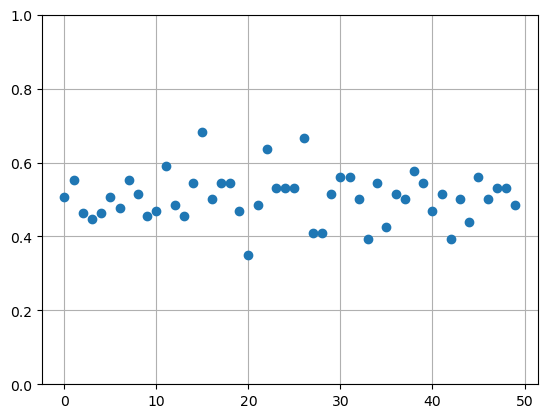

In [95]:
if DO_NB:
    import matplotlib.pyplot as plt
    plt.plot(scores, "o")
    plt.grid()
    plt.ylim(0,1)

In [96]:
# if TICKERS == 'NFLX' and DO_NB:
#     # Demo of lucky date (2019-04-16)
#     X_test_part = X_test[X_test[COL__DateStr] == '2019-04-16']
#     y_test_part = y_test[X_test[COL__DateStr] == '2019-04-16']

#     features = nb_tfidf.transform(X_test_part.message)
#     y_pred = nb_model.predict(features)
#     score = accuracy_score(y_test_part, y_pred)
#     dump_score_line(score, model_tag='-')

#     # 0.6524945770065076

In [97]:
# if TICKERS == 'NFLX' and DO_NB:
#     # Demo of unlucky date (2019-04-17)
#     X_test_part = X_test[X_test[COL__DateStr] == '2019-04-17']
#     y_test_part = y_test[X_test[COL__DateStr] == '2019-04-17']

#     features = nb_tfidf.transform(X_test_part.message)
#     y_pred = nb_model.predict(features)
#     score = accuracy_score(y_test_part, y_pred)
#     dump_score_line(score, model_tag=model_tag)

#     # 0.3927473878303626

## Calc on test set V3 (3 classes)

In [98]:
all_models__probas = []
all_models__full_tags = []
all_models__accs = []

### Defs

In [99]:
def estimate_probas(probas: np.ndarray, X_3classes, pcr_values_3classes, strategy: StrategyParams):
    assert isinstance(probas, np.ndarray)
    assert isinstance(pcr_values_3classes, pd.Series)
    assert len(probas) == len(pcr_values_3classes)

    # Show distribution of probas
    plt.hist(probas[:, 1], bins=20)
    plt.grid()
    plt.xlim(0, 1)
    plt.show()

    # Combine probas and pcr into one df
    df_tmp = X_3classes.copy()
    df_tmp['class1_proba'] = probas[:, 1]
    df_tmp['pcr'] = pcr_values_3classes
    
    # Aggregate by date and ticker
    #    AMZN  2020-07-22   <average_predicted_proba> <std of predicted proba>  <GT_PCR>  
    df_grp = df_tmp.groupby(by=['symbol', COL__DateStr]).agg(
        prob_mean=('class1_proba', np.mean),
        prob_std=('class1_proba', np.std),
        pcr=('pcr', np.mean)
    ).reset_index()
    
    # Sort by proba and build pcr cum chart (price change ratio)
    df_grp_sorted = df_grp.sort_values(by=['prob_mean']).reset_index(drop=True)
    df_grp_sorted['pcr_cum'] =  df_grp_sorted.pcr.cumsum()
    
    # Show chart with probas
    df_grp_sorted.prob_mean.plot()
    plt.grid()
    plt.show()
        
    # Show chart with pcr values
    df_grp_sorted.pcr_cum.plot()
    plt.grid()
    plt.show()
    
    # Apply rule1 strategy  
    #    if average_predicted_proba > 0.5+gap, then long (buy the next day morning, sell the next day evening, 
    #       profit = GT_PCR - commission)
    #    elif average_predicted_proba < 0.5-gap, then short (sell the next day morning, buy back the next day evening,
    #       profit = -GT_PCR - commission)
    #    else: skip this day
    print(LABEL_DATA)
    for gap in [0.05, 0.04, 0.03, 0.02, 0.01, 0.00]:
        df_shorts = df_grp[df_grp.prob_mean < 0.5-gap]
        # prof_shorts_pct = -df_shorts.pcr.sum()
        prof_shorts_pct = -(((df_shorts.pcr / 100.0) + 1.0).prod() - 1.0) * 100.0  # Use product instead of sum
        cnt_shorts = len(df_shorts)
        # Append commissions - for position opening and closing
        # TBD: account for overnight commission for shorts
        prof_shorts_with_comm_pct = prof_shorts_pct - cnt_shorts * 2 * DEFAULT_COMMISSION_PER_TRADE_PCT

        df_longs = df_grp[df_grp.prob_mean > 0.5+gap]
        # prof_longs_pct = +df_longs.pcr.sum()
        prof_longs_pct = +(((df_longs.pcr / 100.0) + 1.0).prod() - 1.0) * 100.0
        cnt_longs = len(df_longs)
        # Append commissions - for position opening and closing
        prof_longs_with_comm_pct = prof_longs_pct - cnt_longs * 2 * DEFAULT_COMMISSION_PER_TRADE_PCT
        
        suffix = " [current strategy]" if gap == strategy.prob_gap else ""
        
        print(f"<{0.5-gap}, >{0.5+gap}: {prof_shorts_pct:.1f}% ({cnt_shorts}), {prof_longs_pct:.1f}% ({cnt_longs})"
              f", Total: {prof_shorts_pct + prof_longs_pct:.1f}% ({cnt_shorts + cnt_longs})"
              f", Total_with_comm: {prof_shorts_with_comm_pct + prof_longs_with_comm_pct:.1f}% ({cnt_shorts + cnt_longs})"
              f"{suffix}")
    

### Estimate probas of NB

In [100]:
# Do model.predict_proba on the test set, give estimation 0..1 for all messages
# Example for 1 ticker:
# Ticker Message Date                 GT  GT_PCR(%)        PredictedProba 
# AMZN msg1  2020-07-22 22:36:53+00:00 -1 -3.602092        0.2
# AMZN msg2  2020-07-22 22:36:44+00:00 -1	-3.602092        0.6
# AMZN msg3  2020-07-23 xxx            0   0.3             0.4
# AMZN msg4  2020-07-24 xxx            1   0.7             0.5

In [101]:
%%time
if DO_NB:
    # Train tf-idf + model and get them, use standard test set
    print(LABEL_DATA)
    model_tag = "NaiveBayes_words_ng1-3_alhpa0.1"
    model_tag_full = model_tag
    out_model_path = None  # f"naive_bayes_model__seed{seed}"

    y_pred, nb_model, nb_tfidf = train_model_and_get_predictions__NB_classifier(model_tag, X_train, y_train, X_test, out_model_path, return_models=True)
    score = accuracy_score(y_test, y_pred)
    dump_score_line(score, model_tag=model_tag)    

    features = nb_tfidf.transform(X_test_3classes.message)
    probas = nb_model.predict_proba(features)
    print(probas)
    
    all_models__probas.append(probas)
    all_models__full_tags.append(model_tag_full)
    all_models__accs.append(score)

AMZN_NFLX_2018-07_2019-07_f7
-	2023-02-27T22:49:39	DESKTOP-418ISSH	User11	0,50665	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	-	-	nan
[[0.39725597 0.60274403]
 [0.47174326 0.52825674]
 [0.39301058 0.60698942]
 ...
 [0.42041668 0.57958332]
 [0.82479722 0.17520278]
 [0.64461451 0.35538549]]
Wall time: 4.02 s


In [102]:
# NFLX_2018-07_2019-07 for week changes
# 0.5001553470452992

# NFLX_2018-07_2019-07
# 0.5103258569614896

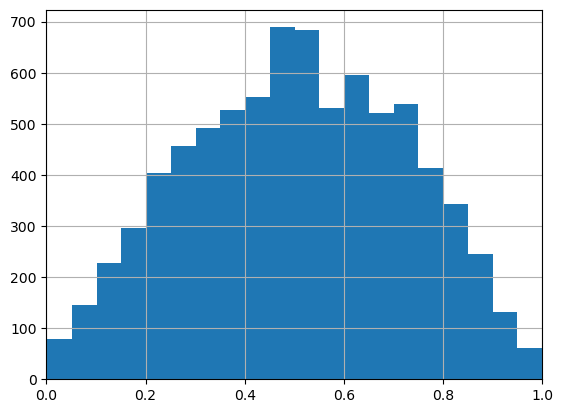

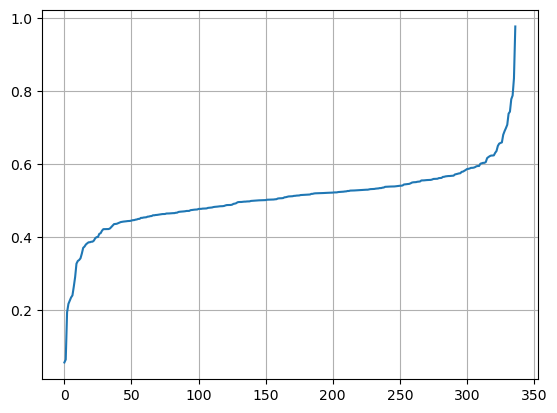

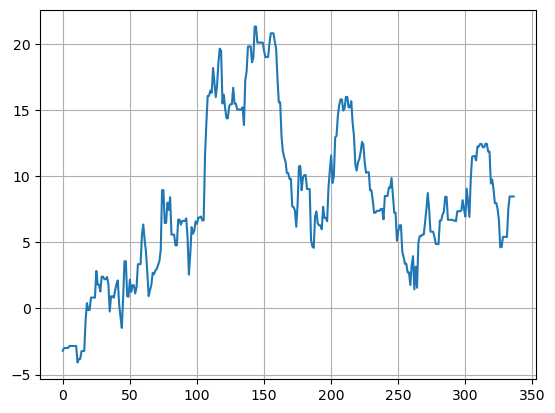

AMZN_NFLX_2018-07_2019-07_f7
<0.45, >0.55: -3.1% (57), 4.2% (75), Total: 1.1% (132), Total_with_comm: -12.1% (132)
<0.46, >0.54: -2.2% (69), 2.9% (87), Total: 0.7% (156), Total_with_comm: -14.9% (156)
<0.47, >0.53: -6.2% (90), -2.3% (110), Total: -8.5% (200), Total_with_comm: -28.5% (200)
<0.48, >0.52: -16.4% (110), 1.3% (146), Total: -15.1% (256), Total_with_comm: -40.7% (256)
<0.49, >0.51: -15.5% (126), -3.5% (170), Total: -19.0% (296), Total_with_comm: -48.6% (296) [current strategy]
<0.5, >0.5: -22.3% (144), -13.0% (193), Total: -35.3% (337), Total_with_comm: -69.0% (337)


In [103]:
if DO_NB:
    estimate_probas(probas, X_test_3classes, pcr_test_3classes, strategy)

In [104]:
# NFLX_2018-07_2019-07 for week changes
# <0.45, >0.55: 45.4% (15), 13.8% (17), Total: 59.2% (32), Total_with_comm: 56.0% (32)
# <0.46, >0.54: 52.4% (23), 37.2% (21), Total: 89.6% (44), Total_with_comm: 85.2% (44)
# <0.47, >0.53: 64.0% (37), 45.4% (29), Total: 109.5% (66), Total_with_comm: 102.9% (66)
# <0.48, >0.52: 65.7% (52), 111.7% (44), Total: 177.4% (96), Total_with_comm: 167.8% (96)
# <0.49, >0.51: 66.7% (74), 139.0% (60), Total: 205.7% (134), Total_with_comm: 192.3% (134)
# <0.5, >0.5: 69.4% (101), 145.4% (77), Total: 214.8% (178), Total_with_comm: 197.0% (178) <<<<

# NFLX_2018-07_2019-07
# <0.45, >0.55: 2.3% (5), 3.8% (22), Total: 6.1% (27), Total_with_comm: 3.4% (27)
# <0.46, >0.54: 3.3% (9), 7.6% (32), Total: 11.0% (41), Total_with_comm: 6.9% (41)
# <0.47, >0.53: 5.4% (16), 6.7% (44), Total: 12.1% (60), Total_with_comm: 6.1% (60)
# <0.48, >0.52: 11.4% (27), 7.6% (65), Total: 19.0% (92), Total_with_comm: 9.8% (92) <<<<<
# <0.49, >0.51: 9.0% (47), 11.5% (88), Total: 20.5% (135), Total_with_comm: 7.0% (135)
# <0.5, >0.5: 4.4% (65), 4.4% (113), Total: 8.8% (178), Total_with_comm: -9.0% (178)

### Estimate probas of CB

In [105]:
seed = None
print("Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance")

# Note: equal hash means binary equality, equal sum means the same rows but shuffled
print(f"After split: {seed}, {X_train.shape}; {X_test.shape};"
    + f" {y_train.shape},{calc_hash_for_seq(y_train)},{sum(y_train)},{calc_class_balance(y_train)};"
    + f" {y_test.shape},{calc_hash_for_seq(y_test)},{sum(y_test)},{calc_class_balance(y_test)}")

Legend: seed; X_train shape; X_test_shape; y_train shape,hash,sum,balance; y_test shape,hash,sum,balance
After split: None, (5292, 7); (3308, 7); (5292,),964791,2646,50.0%:50.0%; (3308,),384230,1654,50.0%:50.0%


In [106]:
#COLS__CB_FEATURES = ['message'] #, 'user', 'message_id', 'Weekday'] #+ ENG_FEATURES
#COLS__CB_FEATURES = ['message', 'user', 'message_id', 'Weekday'] #+ ENG_FEATURES
#COLS__CB_FEATURES = ['message', 'Weekday']  + ENG_FEATURES
#COLS__CB_FEATURES = [COL_PRICE_CHANGE_PERCENT]
#COLS__CB_FEATURES = [COL_PRICE_CHANGE_PERCENT_PREV_DAY]
#COLS__CB_FEATURES = [COL_PRICE_CHANGE_PERCENT, 'Weekday']
#COLS__CB_FEATURES = ['Weekday']
#COLS__CB_FEATURES = ['message', 'Weekday']
#print(COLS__CB_FEATURES)

In [107]:
# Show value counts, including labels
# X_test_with_y = X_test[COLS__CB_FEATURES]
# X_test_with_y['L'] = y_test
# X_test_with_y.value_counts()

In [108]:
# Top value influence
2305/len(X_test)

0.6967956469165659

In [109]:
y_test.value_counts()

1    1654
0    1654
Name: label, dtype: int64

In [110]:
X_test[COLS__CB_FEATURES]

,message
159674,spy nflx this is the color
54078,amzn cnbc sucks they do anything to create fea...
54061,3 blue chip stocks that will power through mar...
54045,amzn forecast green gl
54040,amzn ibm
...,...
112175,msft double dig it q1 outlook give me a better...
112169,nflx
112167,nflx i guess longer term will prevail when oth...
112150,nflx stop just reading headlines and not the f...


In [111]:
y_test

159674    1
54078     1
54061     1
54045     1
54040     1
         ..
112175    0
112169    0
112167    0
112150    0
112148    0
Name: label, Length: 3308, dtype: int64

In [112]:
try:
    X_test[COLS__CB_FEATURES].hist(bins=20)
except Exception as e:
    print(e)

hist method requires numerical or datetime columns, nothing to plot.


In [113]:
%%time
# Train CB model and get it, use standard test set
print(LABEL_DATA)
print(COLS__CB_FEATURES)

model_tag = "catboost"
model_tag_full = f"{model_tag} for {COLS__CB_FEATURES}"
y_pred, cb_model = train_model_and_get_predictions__catboost(model_tag, X_train, y_train, X_test, seed=42, return_models=True)
score = accuracy_score(y_test, y_pred)
dump_score_line(score, model_tag=model_tag_full)    

probas = cb_model.predict_proba(X_test_3classes.loc[:, COLS__CB_FEATURES])
print(probas)

all_models__probas.append(probas)
all_models__full_tags.append(model_tag_full)
all_models__accs.append(score)

AMZN_NFLX_2018-07_2019-07_f7
['message']
-	2023-02-27T22:50:10	DESKTOP-418ISSH	User11	0,50544	nan	nan	nan	nan	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN_NFLX	-	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	-	-	nan
[[0.45899539 0.54100461]
 [0.68454846 0.31545154]
 [0.56659685 0.43340315]
 ...
 [0.57557423 0.42442577]
 [0.5074397  0.4925603 ]
 [0.42700298 0.57299702]]
Wall time: 22.7 s


In [114]:
# Check accuracy on train set (just for information)
y_pred = cb_model.predict(X_train.loc[:,COLS__CB_FEATURES])
print(accuracy_score(y_train, y_pred))

0.8495842781557067


Text(0.5, 1.0, 'Feature Importance')

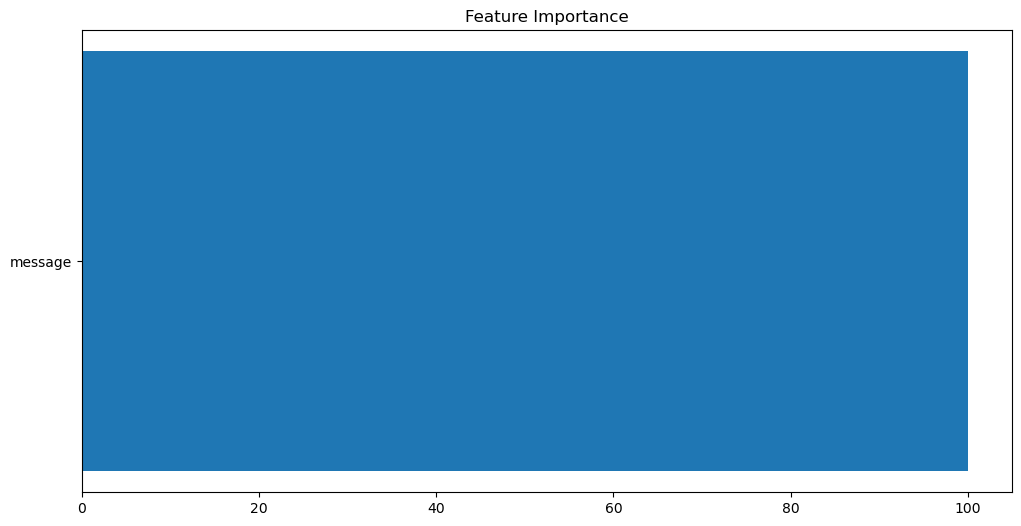

In [115]:
feature_importance = cb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cb_model.feature_names_)[sorted_idx])
plt.title('Feature Importance')

In [116]:
# NFLX_2018-07_2019-07 for week changes
# 0.508326601628037

# NFLX_2018-07_2019-07
# 0.5151502327549725

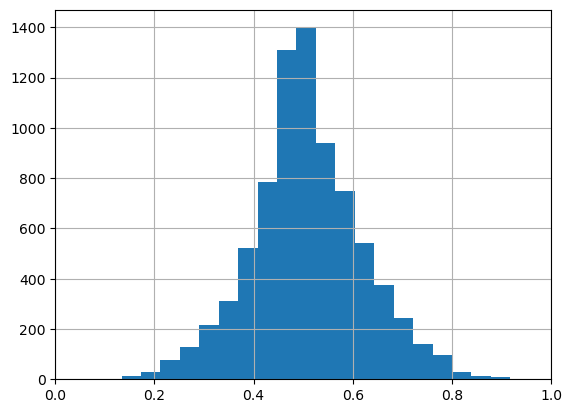

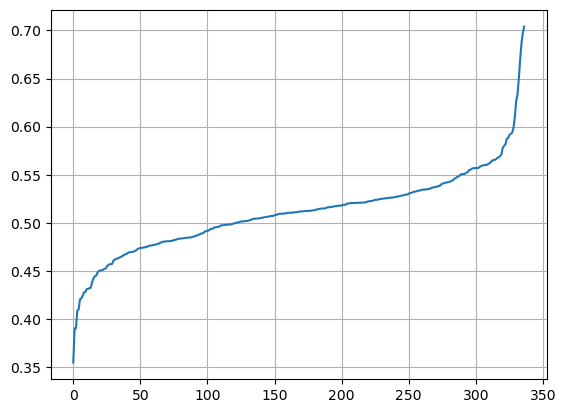

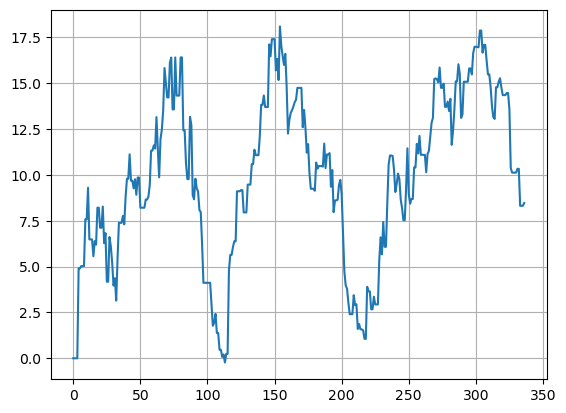

AMZN_NFLX_2018-07_2019-07_f7
<0.45, >0.55: -8.3% (20), -7.0% (48), Total: -15.3% (68), Total_with_comm: -22.1% (68)
<0.46, >0.54: -5.0% (30), -6.3% (62), Total: -11.3% (92), Total_with_comm: -20.5% (92)
<0.47, >0.53: -9.7% (45), -3.3% (87), Total: -13.0% (132), Total_with_comm: -26.2% (132)
<0.48, >0.52: -12.7% (67), 4.1% (132), Total: -8.5% (199), Total_with_comm: -28.4% (199)
<0.49, >0.51: -3.2% (98), -8.6% (178), Total: -11.8% (276), Total_with_comm: -39.4% (276) [current strategy]
<0.5, >0.5: -5.4% (121), 1.0% (216), Total: -4.4% (337), Total_with_comm: -38.1% (337)


In [117]:
estimate_probas(probas, X_test_3classes, pcr_test_3classes, strategy)

In [118]:
# AMZN+NFLX (separate models) 107+59 = 166 trades, (5,2 + 38,7) / 2 = 21,95%  
# Total_with_comm: -0.7% (59), Total_with_comm: 28.0% (107), average: (-0,7 + 28) / 2 = ~14%
# Combined model : 261 trades, 31.3% total profit -> Total_with_comm: 5.2% (261)
# 

# AMZN_NFLX_2018-07_2019-07_f7
# <0.45, >0.55: 2.8% (1), 0.0% (0), Total: 2.8% (1), Total_with_comm: 2.7% (1)
# <0.46, >0.54: 4.2% (6), -2.2% (4), Total: 2.0% (10), Total_with_comm: 1.0% (10)
# <0.47, >0.53: 11.8% (23), 4.1% (23), Total: 15.9% (46), Total_with_comm: 11.3% (46)
# <0.48, >0.52: 9.9% (54), 9.9% (86), Total: 19.8% (140), Total_with_comm: 5.8% (140)
# <0.49, >0.51: 15.9% (97), 15.5% (164), Total: 31.3% (261), Total_with_comm: 5.2% (261) [current strategy]
# <0.5, >0.5: 10.8% (141), 21.6% (202), Total: 32.5% (343), Total_with_comm: -1.8% (343)
            

# AMZN_2018-07_2019-07_f7
# <0.45, >0.55: -0.0% (1), 1.7% (1), Total: 1.7% (2), Total_with_comm: 1.5% (2)
# <0.46, >0.54: -0.0% (1), 1.7% (2), Total: 1.7% (3), Total_with_comm: 1.4% (3)
# <0.47, >0.53: -0.0% (1), 3.9% (4), Total: 3.9% (5), Total_with_comm: 3.4% (5)
# <0.48, >0.52: 0.8% (3), 5.6% (18), Total: 6.4% (21), Total_with_comm: 4.3% (21)
# <0.49, >0.51: -1.2% (9), 6.4% (50), Total: 5.2% (59), Total_with_comm: -0.7% (59) [current strategy]
# <0.5, >0.5: 1.6% (63), 10.5% (102), Total: 12.1% (165), Total_with_comm: -4.4% (165)

# NFLX_2018-07_2019-07_f7
# <0.45, >0.55: 2.8% (1), 0.5% (3), Total: 3.3% (4), Total_with_comm: 2.9% (4)
# <0.46, >0.54: 2.8% (3), -0.6% (4), Total: 2.3% (7), Total_with_comm: 1.6% (7)
# <0.47, >0.53: 3.4% (9), -3.4% (11), Total: -0.0% (20), Total_with_comm: -2.0% (20)
# <0.48, >0.52: 10.1% (36), 14.9% (28), Total: 25.0% (64), Total_with_comm: 18.6% (64)
# <0.49, >0.51: 16.3% (58), 22.4% (49), Total: 38.7% (107), Total_with_comm: 28.0% (107) [current strategy]
# <0.5, >0.5: 14.6% (93), 16.8% (85), Total: 31.4% (178), Total_with_comm: 13.6% (178)


# NFLX_2018-07_2019-07_f10, message+Weekday
# <0.45, >0.55: 7.1% (56), 0.5% (40), Total: 7.6% (96), Total_with_comm: -2.0% (96)
# <0.46, >0.54: 7.5% (63), -0.0% (45), Total: 7.4% (108), Total_with_comm: -3.4% (108)
# <0.47, >0.53: 9.5% (66), 0.5% (51), Total: 10.0% (117), Total_with_comm: -1.7% (117)
# <0.48, >0.52: 13.7% (71), -3.6% (62), Total: 10.2% (133), Total_with_comm: -3.1% (133) <<<
# <0.49, >0.51: 7.3% (82), -3.6% (72), Total: 3.7% (154), Total_with_comm: -11.7% (154)
# <0.5, >0.5: 8.2% (94), 8.6% (84), Total: 16.8% (178), Total_with_comm: -1.0% (178)
            

# NFLX_2018-07_2019-07_f10, Weekday only
# <0.45, >0.55: 3.4% (52), 3.0% (51), Total: 6.5% (103), Total_with_comm: -3.8% (103)
# <0.46, >0.54: 3.2% (77), 3.0% (51), Total: 6.2% (128), Total_with_comm: -6.6% (128)
# <0.47, >0.53: 3.2% (77), 3.0% (101), Total: 6.2% (178), Total_with_comm: -11.6% (178)
# <0.48, >0.52: 3.2% (77), 3.0% (101), Total: 6.2% (178), Total_with_comm: -11.6% (178)
# <0.49, >0.51: 3.2% (77), 3.0% (101), Total: 6.2% (178), Total_with_comm: -11.6% (178)
# <0.5, >0.5: 3.2% (77), 3.0% (101), Total: 6.2% (178), Total_with_comm: -11.6% (178)
            
# NFLX_2018-07_2019-07 with week changes (d7_C/d1_O)
# <0.45, >0.55: 58.1% (11), -5.0% (1), Total: 53.1% (12), Total_with_comm: 51.9% (12)
# <0.46, >0.54: 55.8% (16), 2.9% (7), Total: 58.7% (23), Total_with_comm: 56.4% (23)
# <0.47, >0.53: 57.5% (26), 4.0% (14), Total: 61.4% (40), Total_with_comm: 57.4% (40)
# <0.48, >0.52: 64.8% (44), 25.9% (24), Total: 90.7% (68), Total_with_comm: 83.9% (68)
# <0.49, >0.51: 76.4% (69), 87.6% (47), Total: 164.0% (116), Total_with_comm: 152.4% (116)
# <0.5, >0.5: 66.1% (104), 121.5% (74), Total: 187.7% (178), Total_with_comm: 169.9% (178) <<<

# NFLX_2018-07_2019-07
# <0.45, >0.55: 2.8% (1), 0.5% (3), Total: 3.3% (4), Total_with_comm: 2.9% (4)
# <0.46, >0.54: 2.8% (3), -0.6% (4), Total: 2.3% (7), Total_with_comm: 1.6% (7)
# <0.47, >0.53: 3.4% (9), -3.4% (11), Total: -0.0% (20), Total_with_comm: -2.0% (20)
# <0.48, >0.52: 10.1% (36), 14.9% (28), Total: 25.0% (64), Total_with_comm: 18.6% (64)
# <0.49, >0.51: 16.3% (58), 22.4% (49), Total: 38.7% (107), Total_with_comm: 28.0% (107) <<<
# <0.5, >0.5: 14.6% (93), 16.8% (85), Total: 31.4% (178), Total_with_comm: 13.6% (178)

In [119]:
# CB
# AMZN_NFLX_2018-07_2019-07
# <0.45, >0.55: -0.0% (2), 1.7% (1), Total: 1.7% (3)
# <0.46, >0.54: 2.8% (5), 1.7% (2), Total: 4.5% (7)
# <0.47, >0.53: 6.9% (17), 0.7% (23), Total: 7.6% (40)
# <0.48, >0.52: 10.2% (51), 6.3% (86), Total: 16.5% (137)  <<
# <0.49, >0.51: 16.8% (93), 17.5% (166), Total: 34.3% (259)
# <0.5, >0.5: 10.4% (134), 20.7% (209), Total: 31.1% (343)

# CB:
# AAPL_AMZN_NFLX_2018-07_2019-07
# <0.45, >0.55: 9.7% (62), 2.5% (10), Total: 12.2% (72)
# <0.46, >0.54: 23.2% (115), 3.2% (53), Total: 26.4% (168)  <<<
# <0.47, >0.53: 5.2% (158), 13.2% (135), Total: 18.3% (293)
# <0.48, >0.52: -8.1% (214), 21.0% (172), Total: 12.8% (386) <<
# <0.49, >0.51: -2.4% (301), 19.7% (180), Total: 17.3% (481)
# <0.5, >0.5: -9.4% (331), 22.8% (190), Total: 13.4% (521)

# NB:
# AAPL_AMZN_NFLX_2018-07_2019-07
# <0.45, >0.55: 4.5% (37), 1.0% (18), Total: 5.5% (55)
# <0.46, >0.54: 5.3% (64), -1.6% (48), Total: 3.7% (112)
# <0.47, >0.53: -0.2% (97), 9.1% (95), Total: 8.8% (192)
# <0.48, >0.52: 7.0% (152), 19.6% (166), Total: 26.6% (318)  <<<<<
# <0.49, >0.51: 8.9% (213), 21.8% (207), Total: 30.8% (420)
# <0.5, >0.5: 6.7% (261), 38.8% (260), Total: 45.5% (521)

In [120]:
#np.corrcoef(df_grp_proba_means.class1_proba, df_grp_pcr.pcr)

In [121]:
# Ideas:
# 0) + baseline: (2018-07..2019-07, NFLX) -> 0.554 +- 0.002 NB
# 1) + check non-covid dates (shift 1y back) -> 0.502 NB
# 2) + check other models (CB) -> 0.509 (2019-2020), 0.512 (2018-2019)
# 3) + include feature PCR (leak) and check CB -> 1.0 accuracy :)
# 4) + check for 2018..2020 (2 years) -> 0.505 CB
# 5) + check on NFLX separately -> 0.511 NB on 2018-07..2019-07, NFLX
# 6) + Switch train and test sets -> 0.513 NB on 2018-07..2019-07, NFLX
# 7) +check for shuffling 1y OOT data (probably, accuracy should raise to 0.55+) -> 0.551 +- 0.002 NB on 2018-07..2019-07, NFLX
# 8) +adversarial validation -> 0.69 for OOT, 0.61 for shuffled re-split
# 9) +shrink data to tiny size till the effect exists -> there are "lucky" dates with accuracy >0.6, and unlucky dates with accuracy <0.4


### Portfolio equity - defs

In [122]:
def fill_missing_date_rows(yf_df: pd.DataFrame, col_date='Date', verbose=True) -> pd.DataFrame:
    # Simplified version of fill_missing_date for yf

    # Check data types
    assert col_date in yf_df.columns    
    assert np.issubdtype(yf_df.index.dtype, np.integer)
    # assert np.issubdtype(yf_df[col_date].dtype, np.datetime64)  # This raises exception for tz-aware datetimes
    assert yf_df[col_date].dtype in ['datetime64[ns, UTC]', 'datetime64[ns]']    
    if verbose:
        print('\nBefore reindexing:\n', yf_df.head())

    # Set col_date column as index with filling gaps with NaNs
    new_df = yf_df.set_index(col_date).asfreq('D')  #.reset_index()
    assert type(new_df.index) == pd.DatetimeIndex

    # Set col_date column as index with filling gaps with NaNs, then reset it
    new_df = yf_df.set_index(col_date).asfreq('D').reset_index()
    assert type(new_df.index) == pd.RangeIndex
    
    if verbose:
        print('\nAfter reindexing:\n', new_df.head())

    print(f'.. fill_missing_date_rows: {len(yf_df)} -> {len(new_df)} ({len(new_df) - len(yf_df):+})')
    return new_df

In [123]:
COL__Date = 'Date'  # Date in datetime format
COL__ENTER_LONG = 'enter_long'
COL__ENTER_SHORT = 'enter_short'
COL__EXIT_LONG = 'exit_long'
COL__EXIT_SHORT = 'exit_short'
COL__IS_TRADE_DAY = 'is_trade_day'

class SignalCalculator:
    def __init__(self, strategy: StrategyParams):
        self.prev_date : np.datetime = None
        self.prev_signal = None
        self.prev_signal_date = None
        self.strategy = strategy
        self._clear_signals()

    def _clear_signals(self):
        self.cur_enter_long = 0
        self.cur_exit_long = 0
        self.cur_enter_short = 0
        self.cur_exit_short = 0
        
    def _print_state(self, label: str):
        print(f'{label} prev_date={self.prev_date}, prev_signal={self.prev_signal}, prev_signal_date={self.prev_signal_date}')
        
    def _print_signals(self):
        print(f'Enter/exit_long, enter/exit short: {self.cur_enter_long},{self.cur_exit_long}, {self.cur_enter_short},{self.cur_exit_short}')

    def process_current_row(self, r, verbose: bool = False):
                
        if verbose:
            self._print_state('Before: ')
            if pd.isna(r.prob_mean):
                long_ok = None
                short_ok = None
            else:
                long_ok = r.prob_mean > 0.5 + self.strategy.prob_gap
                short_ok = r.prob_mean < 0.5 - self.strategy.prob_gap
            print(f"prob_mean: {r.prob_mean}, long_ok: {long_ok}, short_ok: {short_ok}")

        # Calc and check days diff (must be 1 day)
        days_diff = None if self.prev_date is None else (r.Date - self.prev_date).total_seconds() / (24 * 3600)
        assert days_diff is None or days_diff == 1.0
        # print(f"{ticker}: non-standard diff from prev day: {days_diff}, {r.Date}, {prev_date}")        
        self.prev_date = r.Date
        
        # Clear the signals
        self._clear_signals()

        # Check if prev signal should be deactivated
        if self.prev_signal:
            assert self.prev_signal_date
            if (r.Date - self.prev_signal_date) >= datetime.timedelta(days=strategy.exit__delay_days):
                # Deactivate prev_signal
                if self.prev_signal == COL__ENTER_LONG:
                    self.cur_exit_long = 1
                elif self.prev_signal == COL__ENTER_SHORT:
                    self.cur_exit_short = 1
                else:
                    assert False
                self.prev_signal = None
                self.prev_signal_date = None

        # Case1: Prev signal is still active -> nothing to do
        if self.prev_signal:
            pass

        # Case2: NaT or NaN -> No messages for this day -> nothing to do
        elif pd.isna(r.prob_mean):
            pass
        
        # Case3: Check for new long signal
        elif r.prob_mean > 0.5 + self.strategy.prob_gap:
            # New signal: Enter long
            assert self.prev_signal is None
            assert self.prev_signal_date is None
            self.prev_signal = COL__ENTER_LONG   
            self.prev_signal_date = r.Date
            
            # Check and set the "enter_long" signal
            if self.cur_exit_long == 1:
                # We could just clear exit_long (to avoid extra transactions)
                self.cur_exit_long = 0
            else:
                self.cur_enter_long = 1
                
        # Case4: Check for new short signal
        elif r.prob_mean < 0.5 - self.strategy.prob_gap:
            # New signal: Enter short
            assert self.prev_signal is None
            assert self.prev_signal_date is None
            self.prev_signal = COL__ENTER_SHORT   
            self.prev_signal_date = r.Date
            
            # Check and set the "enter_short" signal
            if self.cur_exit_short == 1:
                # We could just clear exit_short (to avoid extra transactions)
                self.cur_exit_short = 0
            else:
                self.cur_enter_short = 1
                
        self._print_state('After: ') if verbose else None
        self._print_signals() if verbose else None
        print('=') if verbose else None
        

In [124]:
# Populates ticker_df inplace
def populate_buy_trend(ticker_df: pd.DataFrame, strategy: StrategyParams, verbose: bool = False):

    bh_enter_price = None
    bh_exit_price = None
    lst_enter_long = []
    lst_exit_long = []
    lst_enter_short = []
    lst_exit_short = []
    workdays = []

    sig_calc = SignalCalculator(strategy)

    # Cycle for every day
    for id, r in ticker_df.iterrows():
        sig_calc.process_current_row(r, verbose=verbose)

        lst_enter_long.append(sig_calc.cur_enter_long)
        lst_exit_long.append(sig_calc.cur_exit_long)
        lst_enter_short.append(sig_calc.cur_enter_short)
        lst_exit_short.append(sig_calc.cur_exit_short)    

        is_trade_day = (not pd.isna(r.Volume)) and (r.Volume > 0.0)
        workdays.append(is_trade_day)
        
        if bh_enter_price is None:
            bh_enter_price = r.bh_enter_price

    # Cycle from the end and put force "exit long" and "exit short" so that the potential position 
    # is guaranteed to be closed
    trade_day_counter = 0
    for i in reversed(range(len(lst_enter_long))):
        if trade_day_counter == 1:
            lst_exit_long[i] = 1
            lst_exit_short[i] = 1
            break
        if workdays[i]:
            trade_day_counter +=1
            if bh_exit_price is None:
                bh_exit_price = r.bh_exit_price

    ticker_df[COL__ENTER_LONG] = lst_enter_long
    ticker_df[COL__EXIT_LONG] = lst_exit_long
    ticker_df[COL__ENTER_SHORT] = lst_enter_short
    ticker_df[COL__EXIT_SHORT] = lst_exit_short
    ticker_df[COL__IS_TRADE_DAY] = workdays
    
    # Calc buy-and-hold profit for the test period
    assert bh_enter_price is not None
    assert bh_exit_price is not None
    bh_profit = bh_exit_price / bh_enter_price - 1.0
    
    status = f".. populate_buy_trend results (enter/exit longs, enter/exit shorts): " + \
        f" {sum(lst_enter_long)},{sum(lst_exit_long)}, {sum(lst_enter_short)},{sum(lst_exit_short)}"
    return status, bh_profit


In [125]:
def calc_portfolio_equity_by_signals(ticker_df: pd.DataFrame, strategy: StrategyParams, verbose: bool = True):
    
    # Prepare settings
    min_date = ticker_df.Date.min()
    max_date = ticker_df.Date.max()
    starting_balance = 1000.0
    timeframe = 'D'

    # Prepare portfolio_history object with full range of trade dates
    portfolio_history = btm.EquityHistory(
        min_date=min_date, max_date=max_date,
        starting_balance=starting_balance, timeframe=timeframe
    )

    cur_trade_tuple = None
    cur_cash = starting_balance
    pending_enter_long = False
    pending_enter_short = False
    pending_exit_long = False
    pending_exit_short = False
    in_position = 0  # -1, 0, 1

    FEE_OPEN = DEFAULT_COMMISSION_PER_TRADE_PCT / 100.0
    FEE_CLOSE = FEE_OPEN

    for id, r in ticker_df.iterrows():
        
        if verbose:
            print(
                f"Start for row {r.Date:%Y-%m-%d} iswrk={r[COL__IS_TRADE_DAY]} {in_position=}" + 
                f" en/ex long, en/ex short:" +
                f" {r[COL__ENTER_LONG]},{r[COL__EXIT_LONG]}, {r[COL__ENTER_SHORT]},{r[COL__EXIT_SHORT]}" + 
                f" pend en/ex long, en/ex short:" +
                f" {str(pending_enter_long)[:1]},{str(pending_exit_long)[:1]}, {str(pending_enter_short)[:1]},{str(pending_exit_short)[:1]}"
            )

        if pending_exit_long and r[COL__IS_TRADE_DAY]:
            # Check and modify states
            pending_exit_long = False

            # Close position (at day start or end, depending on the strategy)
            if cur_trade_tuple is None:
                # Possible cases 1) if too long non-trading days (?Jan holiday)  2) in the end of period
                print('WARNING: exit long signal detected while position is not open -> just ignore the signal')
            else:
                ###########################################################################################################
                # Orinal block start (see copypaste below)
                ###########################################################################################################                
                assert in_position == +1
                in_position = 0

                assert len(cur_trade_tuple) == 3
                amount = cur_trade_tuple[0]
                close_rate = r[strategy.exit__price_field]
                fee_close = amount * close_rate * FEE_CLOSE
                cur_cash = cur_cash + amount * close_rate - fee_close
                if verbose:
                    print(f"Close long position register (trade will be added): {r.Date=} {amount=} {close_rate=} {fee_close=} {cur_cash=}")
                assert cur_cash >= 0.0

                # print(portfolio_history.cash_history_df)
                portfolio_history.append_trade(
                    amount=amount, open_date=cur_trade_tuple[1], close_date=r.Date,
                    open_rate=cur_trade_tuple[2], close_rate=close_rate, 
                    open_fee_ratio=FEE_OPEN, close_fee_ratio = FEE_CLOSE,
                    ticker_history_df=ticker_df,
                    column_for_date='Date', column_for_rate='Close',
                    verbose=verbose
                )
                open_position_registered = False
                # print(portfolio_history.cash_history_df)
                ###########################################################################################################
                # Original block end
                ###########################################################################################################                

        if pending_exit_short and r[COL__IS_TRADE_DAY]:
            # Check and modify states
            pending_exit_short = False

            # Close position (at day start or end, depending on the strategy)
            if cur_trade_tuple is None:
                # Possible cases 1) if too long non-trading days (?Jan holiday)  2) in the end of period
                print('WARNING: exit short signal detected while position is not open -> just ignore the signal')
            else:
                ###########################################################################################################
                # Orinal block start (see copypaste below)
                ###########################################################################################################                
                assert in_position == -1
                in_position = 0

                assert len(cur_trade_tuple) == 3
                amount = cur_trade_tuple[0]
                close_rate = r[strategy.exit__price_field]
                fee_close = amount * close_rate * FEE_CLOSE
                cur_cash = cur_cash - amount * close_rate- fee_close
                assert cur_cash >= 0.0  # In theory, this may be < 0
                if verbose:
                    print(f"Close short position register (trade will be added): {r.Date=} {cur_cash=}")

                # print(portfolio_history.cash_history_df)
                portfolio_history.append_trade(
                    amount=-amount, open_date=cur_trade_tuple[1], close_date=r.Date,
                    open_rate=cur_trade_tuple[2], close_rate=close_rate, 
                    open_fee_ratio=FEE_OPEN, close_fee_ratio = FEE_CLOSE,
                    ticker_history_df=ticker_df,
                    column_for_date='Date', column_for_rate='Close',
                    verbose=verbose
                )
                open_position_registered = False
                # print(portfolio_history.cash_history_df)
                ###########################################################################################################
                # Original block end
                ###########################################################################################################                

        if pending_enter_long and r[COL__IS_TRADE_DAY]:
            # Check and modify states
            pending_enter_long = False
            assert in_position == 0, f"{in_position=}"
            in_position = +1

            # Open position (at day start or end, depending on the strategy)
            enter_rate = r[strategy.enter__price_field]
            amount = (cur_cash * (1 - FEE_OPEN)) // enter_rate
            if verbose:
                print(f"Open long position register: {r.Date=} {cur_cash=}, {amount=}")
            fee_open = amount * enter_rate * FEE_OPEN  # Here we ignore minimum amount of comission
            cur_cash = cur_cash - amount * enter_rate - fee_open
            assert cur_cash >= 0.0
            cur_trade_tuple = (amount, r.Date, enter_rate)

        if pending_enter_short and r[COL__IS_TRADE_DAY]:
            # Check and modify states
            pending_enter_short = False
            assert in_position == 0, f"{in_position=}"
            in_position = -1

            # Open position (at day start or end, depending on the strategy)
            enter_rate = r[strategy.enter__price_field]
            amount = (cur_cash * (1 - FEE_OPEN)) // enter_rate
            if verbose:
                print(f"Open short position register: {r.Date=} {cur_cash=}, {amount=}")
            fee_open = amount * enter_rate * FEE_OPEN  # Here we ignore minimum amount of comission
            cur_cash = cur_cash + amount * enter_rate - fee_open
            assert cur_cash >= 0.0
            cur_trade_tuple = (amount, r.Date, enter_rate)

        # NEW 2023-02-14: new signal and position already OK -> reset all pending vars
        if ((r[COL__ENTER_SHORT] == 1) and (in_position == -1)) or ((r[COL__ENTER_LONG] == 1) and (in_position == +1)):
            pending_enter_long = False
            pending_enter_short = False
            pending_exit_long = False
            pending_exit_short = False
            
        
        if (r[COL__ENTER_LONG] == 1) and (in_position != +1):
            assert not pending_enter_long
            pending_enter_long = True
            # If current position is short -> register additional exit signal
            if in_position == -1:
                if pending_exit_short:
                    # This is possible only when current date is non-working. Leave the signal as is.
                    assert not r[COL__IS_TRADE_DAY]
                else:
                    pending_exit_short = True
        if (r[COL__ENTER_SHORT] == 1) and (in_position != -1):
            assert not pending_enter_short
            pending_enter_short = True
            # If current position is long -> register additional exit signal
            if in_position == +1:
                if pending_exit_long:
                    # This is possible only when current date is non-working. Leave the signal as is.
                    assert not r[COL__IS_TRADE_DAY]
                else:
                    pending_exit_long = True
                            

        if (r[COL__EXIT_LONG] == 1) and (in_position != +1):
            # Case: non-working day and we have pending enter signal -> just switch off it
            if (not r[COL__IS_TRADE_DAY]) and pending_enter_long:
                if verbose:
                    print(f"On non-working day exit long signal received while pending_enter_long is active -> just switch off pending_enter_long")
                pending_enter_long = False
                assert not pending_exit_long
        if (r[COL__EXIT_LONG] == 1) and (in_position == +1):
            # Case: working day and special case - close the position in the evening of the same day if enter/exit day delay are equal
            if r[COL__IS_TRADE_DAY] and (strategy.exit__delay_days == strategy.enter__delay_days):
                assert strategy.exit__price_field == 'Close' and strategy.enter__price_field == 'Open'

                ###########################################################################################################
                # Start of copypaste from above
                ###########################################################################################################                
                assert in_position == +1
                in_position = 0

                assert len(cur_trade_tuple) == 3
                amount = cur_trade_tuple[0]
                close_rate = r[strategy.exit__price_field]
                fee_close = amount * close_rate * FEE_CLOSE
                cur_cash = cur_cash + amount * close_rate - fee_close
                if verbose:
                    print(f"Close long position register (trade will be added): {r.Date=} {amount=} {close_rate=} {fee_close=} {cur_cash=}")
                assert cur_cash >= 0.0

                # print(portfolio_history.cash_history_df)
                portfolio_history.append_trade(
                    amount=amount, open_date=cur_trade_tuple[1], close_date=r.Date,
                    open_rate=cur_trade_tuple[2], close_rate=close_rate, 
                    open_fee_ratio=FEE_OPEN, close_fee_ratio = FEE_CLOSE,
                    ticker_history_df=ticker_df,
                    column_for_date='Date', column_for_rate='Close',
                    verbose=verbose
                )
                open_position_registered = False
                # print(portfolio_history.cash_history_df)
                ###########################################################################################################
                # End of copypaste from above
                ###########################################################################################################                
                pending_exit_long = False
            else:
                pending_exit_long = True
                
            
        if (r[COL__EXIT_SHORT] == 1) and (in_position != -1):
            # Case1: non-working day and we have pending enter signal -> just switch off it
            if (not r[COL__IS_TRADE_DAY]) and pending_enter_short:
                if verbose:
                    print(f"On non-working day exit short signal received while pending_enter_short is active -> just switch off pending_enter_short")
                pending_enter_short = False
                assert not pending_exit_short
        if (r[COL__EXIT_SHORT] == 1) and (in_position == -1):
            # Special case - close the position in the evening of the same day if enter/exit day delay are equal
            if r[COL__IS_TRADE_DAY] and (strategy.exit__delay_days == strategy.enter__delay_days):
                assert strategy.exit__price_field == 'Close' and strategy.enter__price_field == 'Open'

                ###########################################################################################################
                # Start of copypaste from above
                ###########################################################################################################                
                assert in_position == -1
                in_position = 0

                assert len(cur_trade_tuple) == 3
                amount = cur_trade_tuple[0]
                close_rate = r[strategy.exit__price_field]
                fee_close = amount * close_rate * FEE_CLOSE
                cur_cash = cur_cash - amount * close_rate- fee_close
                assert cur_cash >= 0.0  # In theory, this may be < 0
                if verbose:
                    print(f"Close short position register (trade will be added): {r.Date=} {cur_cash=}")

                # print(portfolio_history.cash_history_df)
                portfolio_history.append_trade(
                    amount=-amount, open_date=cur_trade_tuple[1], close_date=r.Date,
                    open_rate=cur_trade_tuple[2], close_rate=close_rate, 
                    open_fee_ratio=FEE_OPEN, close_fee_ratio = FEE_CLOSE,
                    ticker_history_df=ticker_df,
                    column_for_date='Date', column_for_rate='Close',
                    verbose=verbose
                )
                open_position_registered = False
                # print(portfolio_history.cash_history_df)
                ###########################################################################################################
                # End of copypaste from above
                ###########################################################################################################                
                pending_exit_short = False
            else:
                pending_exit_short = True
        
    return portfolio_history

    

In [126]:
def calc_equity_history(
    probas: np.ndarray, 
    X_3classes_full, 
    pcr_values_3classes, 
    strategy: StrategyParams, 
    model_tag_full: str = '',   # Ex: "catboost for ['message']"
    model_params_str: str = '',
    model_accuracy: float = np.nan,
    phase1_shapes: str = '',
    verbose: bool = False):
    
    dump_config_line()
    
    assert isinstance(probas, np.ndarray)
    assert isinstance(pcr_values_3classes, pd.Series)
    assert len(probas) == len(pcr_values_3classes) == len(X_3classes_full)

    # Show distribution of probas
    plt.hist(probas[:, 1], bins=20)
    plt.grid()
    plt.xlim(0, 1)
    plt.show()

    # Combine probas and pcr into one df
    df_tmp = X_3classes_full.copy()
    df_tmp['class1_proba'] = probas[:, 1]
    df_tmp['pcr'] = pcr_values_3classes
    
    # Aggregate by date and ticker, adding OHLCV info
    #    AMZN  2020-07-22   <average_predicted_proba> <std of predicted proba>  <GT_PCR> <OHLCV columns>
    df_grp = df_tmp.groupby(by=['symbol', COL__DateStr]).agg(
        prob_mean=('class1_proba', np.mean),
        prob_std=('class1_proba', np.std),
        pcr=('pcr', np.mean),
        Open=('d0_O', 'first'),
        High=('d0_H', 'first'),
        Low=('d0_L', 'first'),
        Close=('d0_C', 'first'),
        Volume=('d0_V', 'first'),
        bh_enter_price=('bh_enter_price', 'first'),
        bh_exit_price=('bh_exit_price', 'first'),
    ).reset_index()    

    # Add column with datetime type
    df_grp[COL__Date] = pd.to_datetime(df_grp[COL__DateStr], utc=True, infer_datetime_format=True)    
    
    ds_total_equity = None
    total_bh_profit = 0.0
    total_trade_cnt = 0
    total_info = []
    score_line_per_ticker_list = []    
    for ticker in df_grp.symbol.unique():
        print(f"Processing ticker {ticker}")
        # Leave only message for the ticker
        df_grp_ticker = df_grp[df_grp.symbol == ticker].copy()

        # Fill potential gaps in days, when there were no tweets for the current ticker
        df_grp_ticker = fill_missing_date_rows(df_grp_ticker, col_date=COL__Date, verbose=verbose)
        
        res_info, bh_profit = populate_buy_trend(df_grp_ticker, strategy, verbose=verbose)
        print(res_info)
        total_info.append(f"{ticker}: {res_info}")
        
        portfolio_history: EquityHistory = calc_portfolio_equity_by_signals(df_grp_ticker, strategy, verbose=verbose)
        ds_ticker_equity = portfolio_history.get_equity_history()
        # Plot the equity for the ticker
        ds_ticker_equity.plot(title=ticker)
        plt.show()
        # Generate score line for the ticker
        # Convert history to percentage changes and calc Sharpe Ratio
        ds_pct_change = ds_ticker_equity.pct_change(periods=1)
        df_pct_change = pd.DataFrame({'close_date': ds_pct_change.index, 'profit_ratio': ds_pct_change})
        sr = btm.calc_sharpe_ratio__daily(results = df_pct_change)
        profit_rel = (ds_ticker_equity[-1] / ds_ticker_equity[0]) - 1.0  # Commission should have been included
        trades_cnt = portfolio_history.trade_count
        
        score_line_str = dump_score_line(
            acc=model_accuracy, bm_profit=profit_rel, bm_trades=trades_cnt, bm_sharpe=sr, bh_profit=bh_profit,
            test_tickers=ticker,
            model_tag=model_tag_full, 
            model_params=model_params_str,
            phase1_shapes=phase1_shapes
        )

        score_line_per_ticker_list.append(score_line_str)
        
        # Adjust total equity
        if ds_total_equity is None:
            ds_total_equity = ds_ticker_equity
        else:
            ds_total_equity += ds_ticker_equity            
        total_trade_cnt += portfolio_history.trade_count
        
        # Adjust total bh profit
        total_bh_profit += bh_profit
        
        print("Success!")
        
        
    # Convert history to percentage changes and calc Sharpe Ratio
    ds_pct_change = ds_total_equity.pct_change(periods=1)
    df_pct_change = pd.DataFrame({'close_date': ds_pct_change.index, 'profit_ratio': ds_pct_change})
    sr = btm.calc_sharpe_ratio__daily(results = df_pct_change)
    profit_rel = (ds_total_equity[-1] / ds_total_equity[0]) - 1.0  # Commission should have been included

    # Plot the equity for all tickers
    ds_total_equity.plot(title=f"All, prob_gap={strategy.prob_gap}")
    plt.show()

    # Dump final info
    dump_config_line()
    print("\n".join(total_info))
    print(f"Profit: {profit_rel * 100.0:.5g}%")
    print(f"Trades: {total_trade_cnt}")
    print(f"Sharpe Ratio: {sr:.3f}")
    print("Score line for Google Sheet:")
    score_line_str = dump_score_line(
        acc=model_accuracy, bm_profit=profit_rel, bm_trades=total_trade_cnt, bm_sharpe=sr, bh_profit=total_bh_profit,
        test_tickers="all", 
        model_tag=model_tag_full, 
        model_params=model_params_str,
        phase1_shapes=phase1_shapes
    )

    # If more than 1 ticker -> append the total result to "per ticker" list
    if len( df_grp.symbol.unique()) > 1:
        score_line_per_ticker_list.append(score_line_str)
        
    return score_line_str, score_line_per_ticker_list

### Portfolio equity - main cycle launch

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


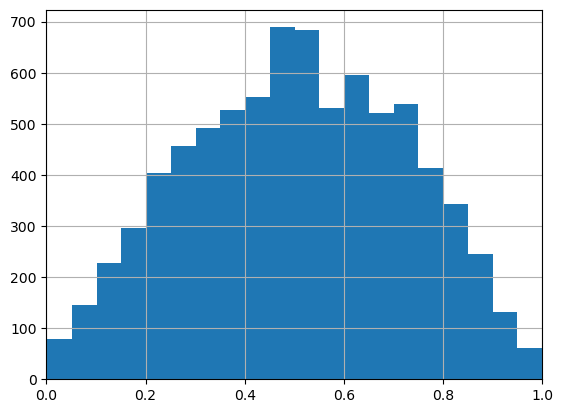

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  12,13, 9,10


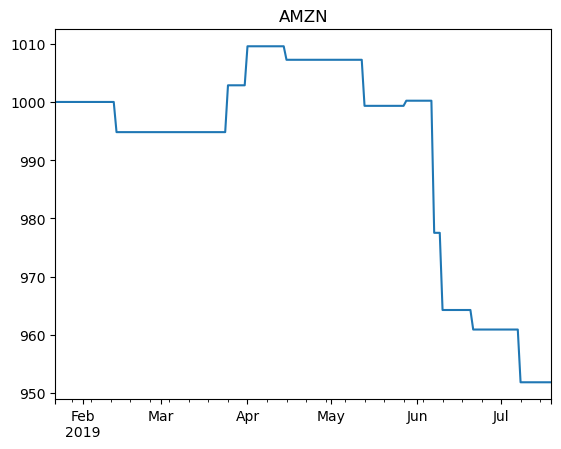

-	2023-02-27T22:50:21	DESKTOP-418ISSH	User11	0,50665	-0,048174	10	-2,2083	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.1	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  12,13, 12,13


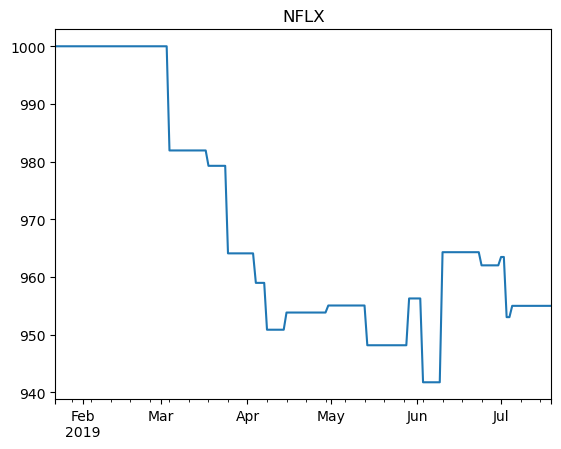

-	2023-02-27T22:50:22	DESKTOP-418ISSH	User11	0,50665	-0,045026	14	-1,5448	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.1	-	nan
Success!


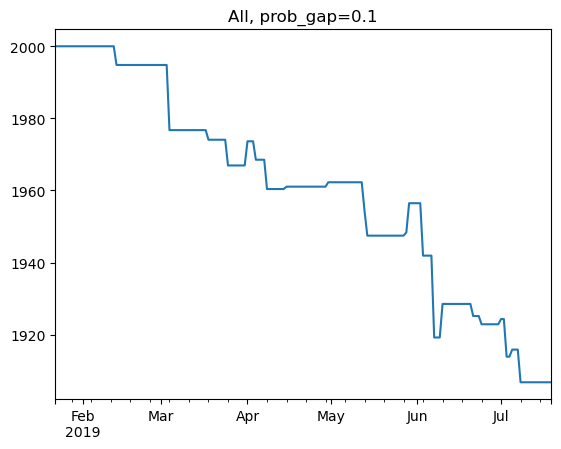

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  12,13, 9,10
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  12,13, 12,13
Profit: -4.66%
Trades: 24
Sharpe Ratio: -3.198
Score line for Google Sheet:
-	2023-02-27T22:50:23	DESKTOP-418ISSH	User11	0,50665	-0,0466	24	-3,1982	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.1	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


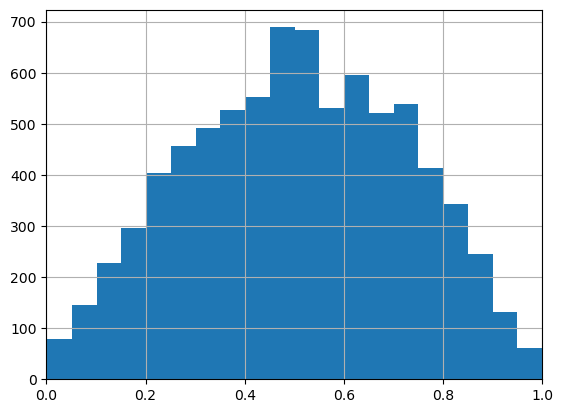

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  15,16, 10,11


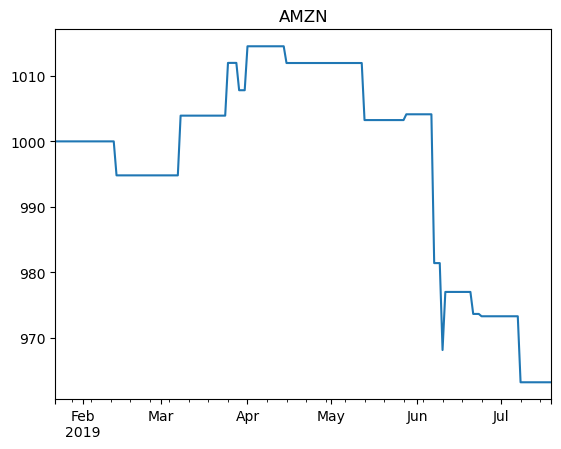

-	2023-02-27T22:50:25	DESKTOP-418ISSH	User11	0,50665	-0,036756	14	-1,5095	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.09	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  13,14, 13,14


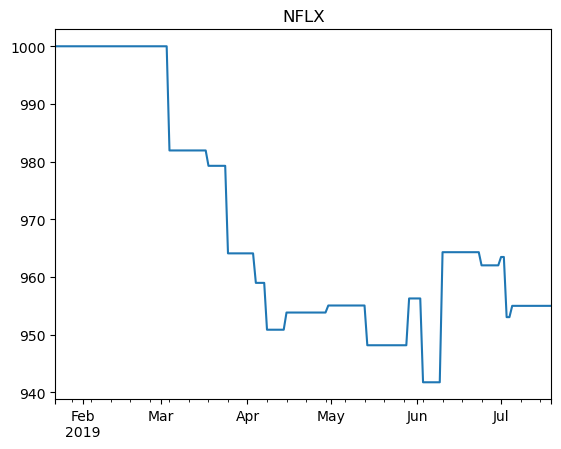

-	2023-02-27T22:50:27	DESKTOP-418ISSH	User11	0,50665	-0,045026	14	-1,5448	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.09	-	nan
Success!


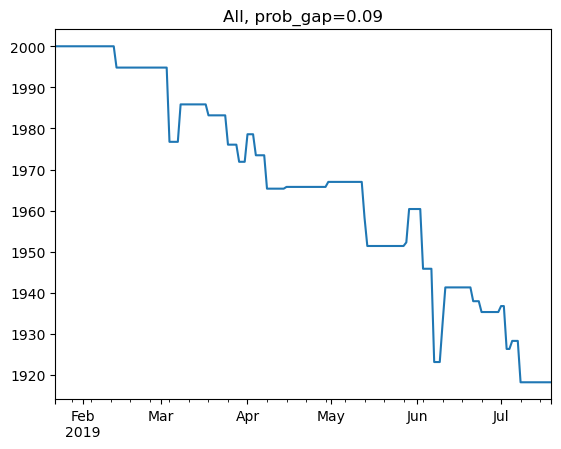

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  15,16, 10,11
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  13,14, 13,14
Profit: -4.0891%
Trades: 28
Sharpe Ratio: -2.633
Score line for Google Sheet:
-	2023-02-27T22:50:27	DESKTOP-418ISSH	User11	0,50665	-0,040891	28	-2,6327	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.09	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


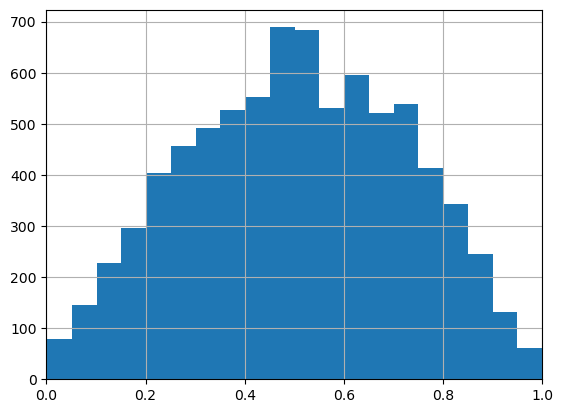

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  19,20, 10,11


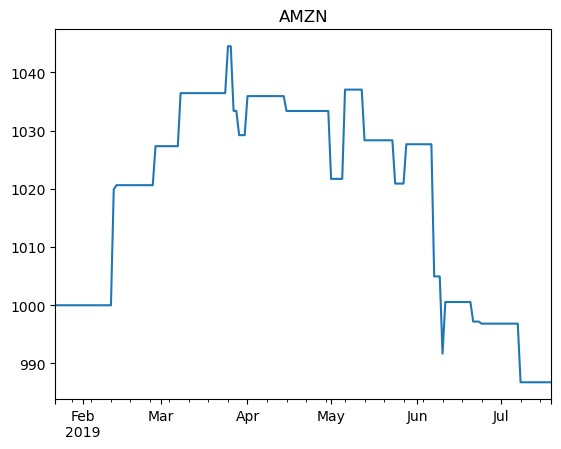

-	2023-02-27T22:50:29	DESKTOP-418ISSH	User11	0,50665	-0,013231	18	-0,37785	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.08	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  15,16, 14,15


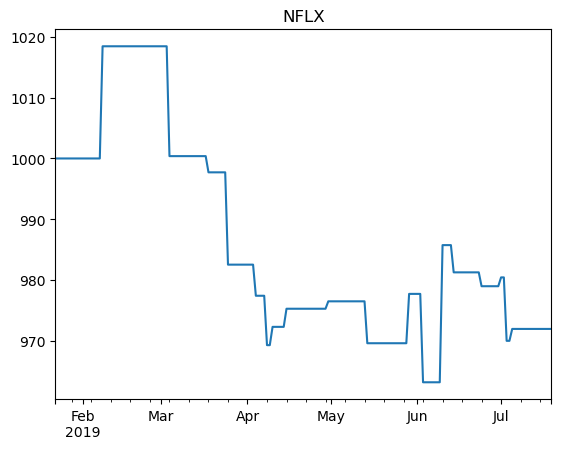

-	2023-02-27T22:50:30	DESKTOP-418ISSH	User11	0,50665	-0,028042	17	-0,86376	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.08	-	nan
Success!


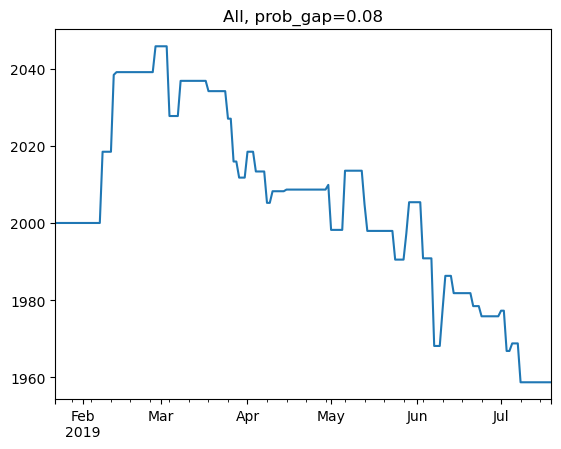

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  19,20, 10,11
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  15,16, 14,15
Profit: -2.0637%
Trades: 35
Sharpe Ratio: -1.010
Score line for Google Sheet:
-	2023-02-27T22:50:31	DESKTOP-418ISSH	User11	0,50665	-0,020637	35	-1,01	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.08	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


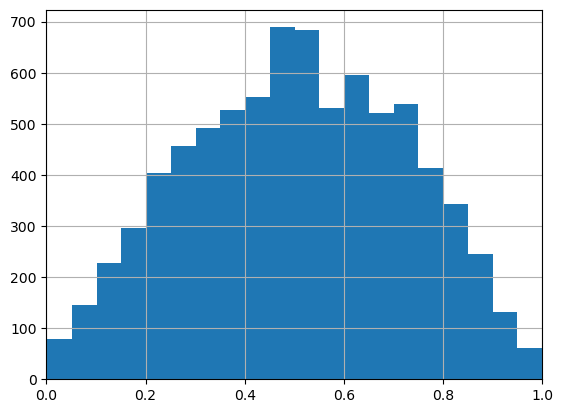

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  22,23, 12,12


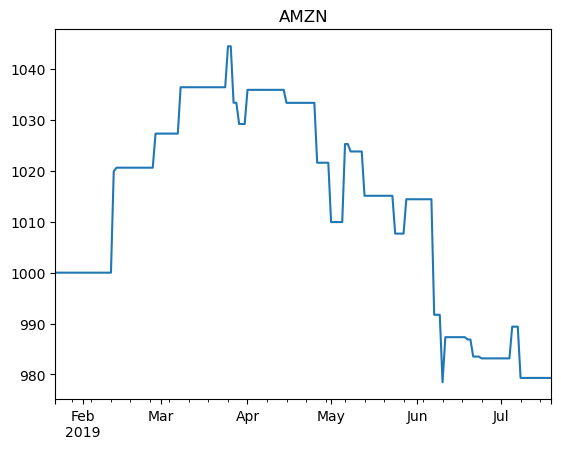

-	2023-02-27T22:50:33	DESKTOP-418ISSH	User11	0,50665	-0,020683	22	-0,58111	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.07	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  17,18, 18,19


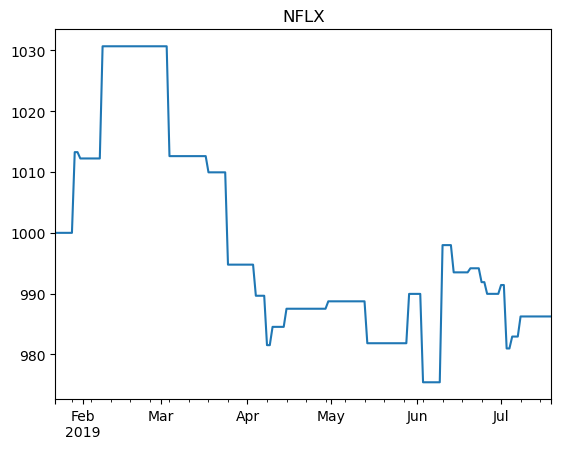

-	2023-02-27T22:50:34	DESKTOP-418ISSH	User11	0,50665	-0,013756	22	-0,38821	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.07	-	nan
Success!


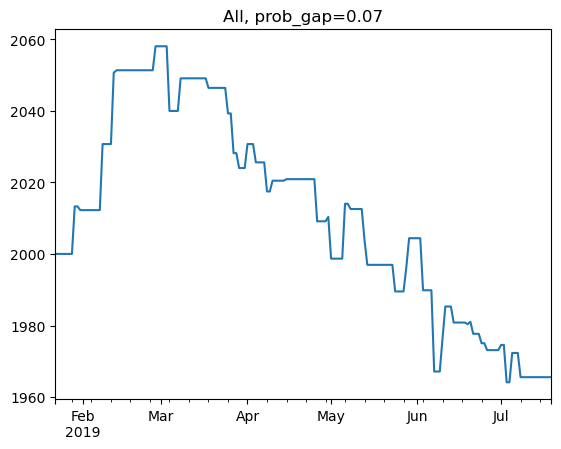

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  22,23, 12,12
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  17,18, 18,19
Profit: -1.7219%
Trades: 44
Sharpe Ratio: -0.799
Score line for Google Sheet:
-	2023-02-27T22:50:35	DESKTOP-418ISSH	User11	0,50665	-0,017219	44	-0,799	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.07	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


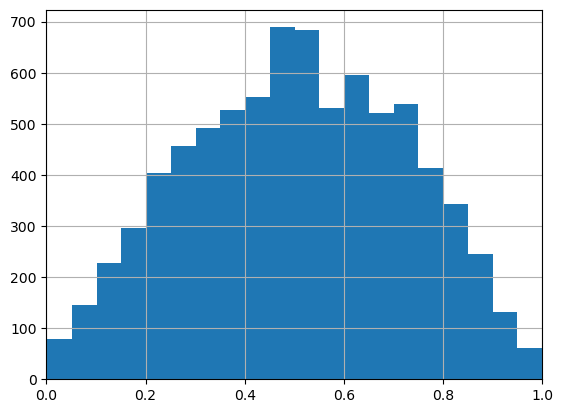

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 14,13


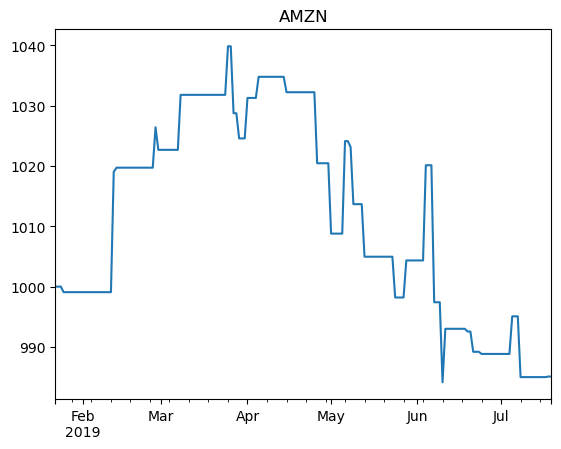

-	2023-02-27T22:50:37	DESKTOP-418ISSH	User11	0,50665	-0,014899	27	-0,37638	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.06	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  22,23, 20,21


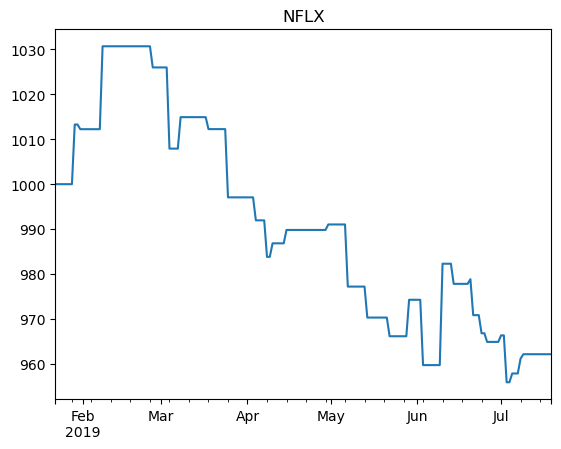

-	2023-02-27T22:50:39	DESKTOP-418ISSH	User11	0,50665	-0,037848	26	-1,0448	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.06	-	nan
Success!


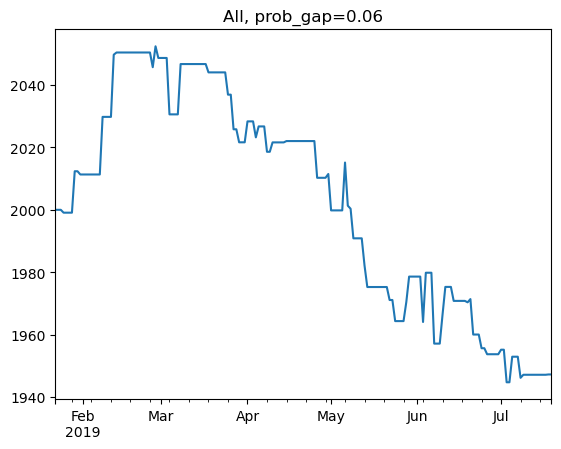

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 14,13
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  22,23, 20,21
Profit: -2.6373%
Trades: 53
Sharpe Ratio: -1.105
Score line for Google Sheet:
-	2023-02-27T22:50:40	DESKTOP-418ISSH	User11	0,50665	-0,026373	53	-1,1051	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.06	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


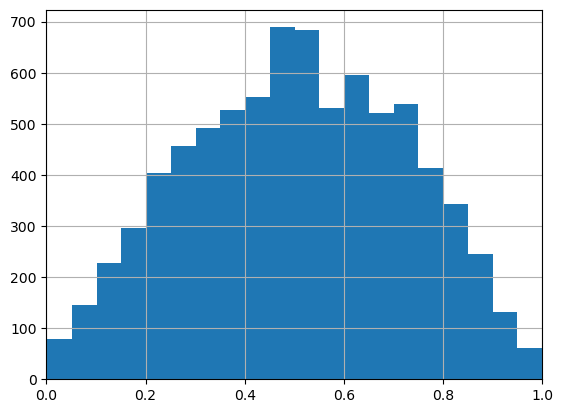

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  32,33, 19,18


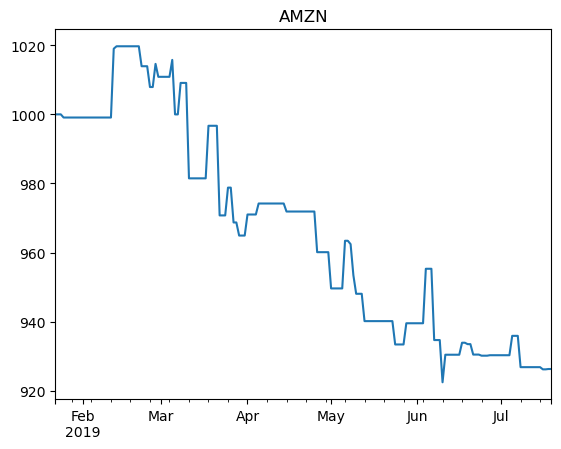

-	2023-02-27T22:50:42	DESKTOP-418ISSH	User11	0,50665	-0,073731	37	-1,5467	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.05	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 29,30


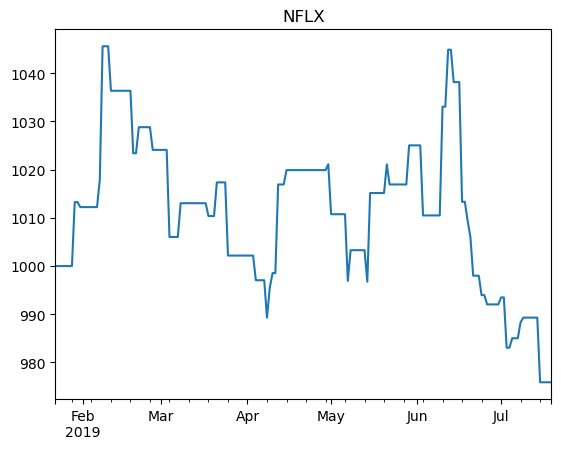

-	2023-02-27T22:50:44	DESKTOP-418ISSH	User11	0,50665	-0,024113	38	-0,43865	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.05	-	nan
Success!


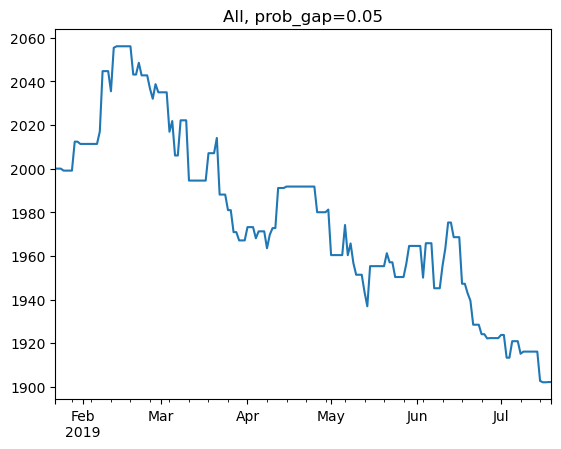

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  32,33, 19,18
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 29,30
Profit: -4.8922%
Trades: 75
Sharpe Ratio: -1.468
Score line for Google Sheet:
-	2023-02-27T22:50:44	DESKTOP-418ISSH	User11	0,50665	-0,048922	75	-1,4676	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.05	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


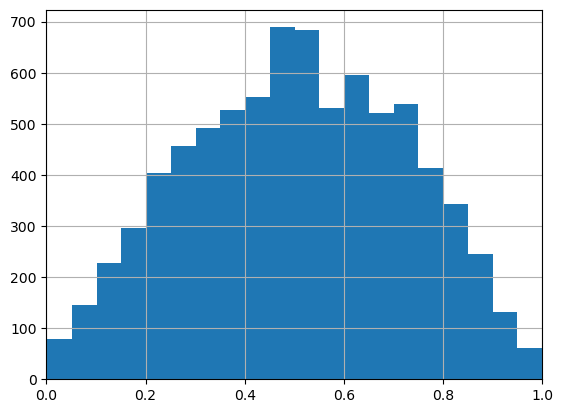

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 24,23


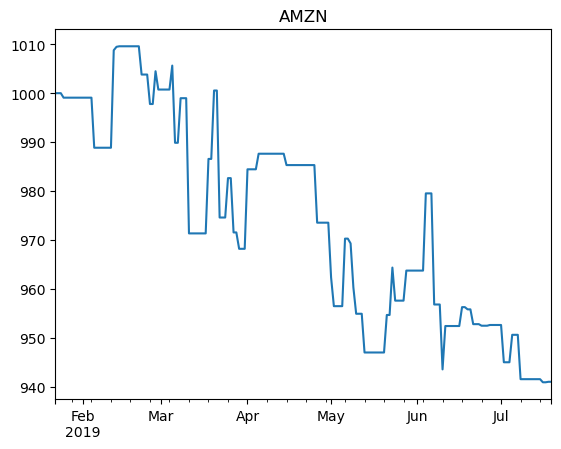

-	2023-02-27T22:50:47	DESKTOP-418ISSH	User11	0,50665	-0,058978	42	-1,0992	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.04	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  29,30, 34,34


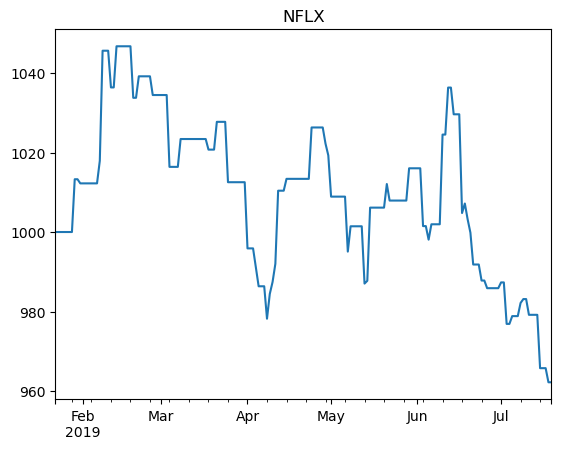

-	2023-02-27T22:50:48	DESKTOP-418ISSH	User11	0,50665	-0,037795	46	-0,65919	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.04	-	nan
Success!


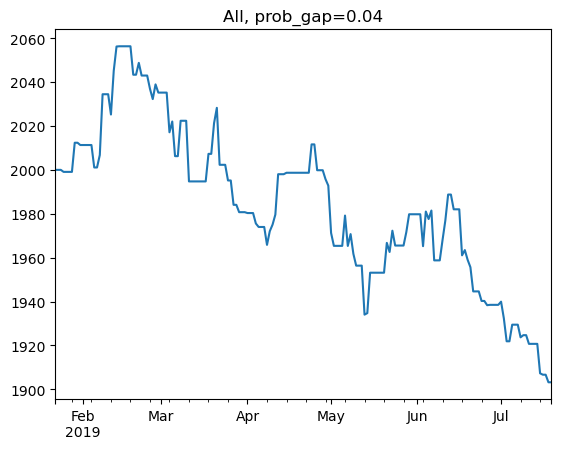

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 24,23
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  29,30, 34,34
Profit: -4.8387%
Trades: 88
Sharpe Ratio: -1.340
Score line for Google Sheet:
-	2023-02-27T22:50:50	DESKTOP-418ISSH	User11	0,50665	-0,048387	88	-1,3398	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.04	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


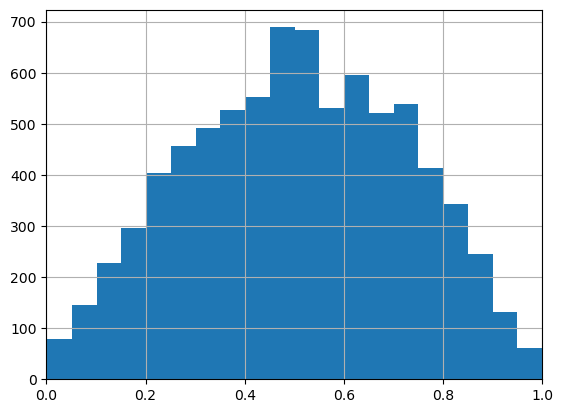

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  36,37, 34,33


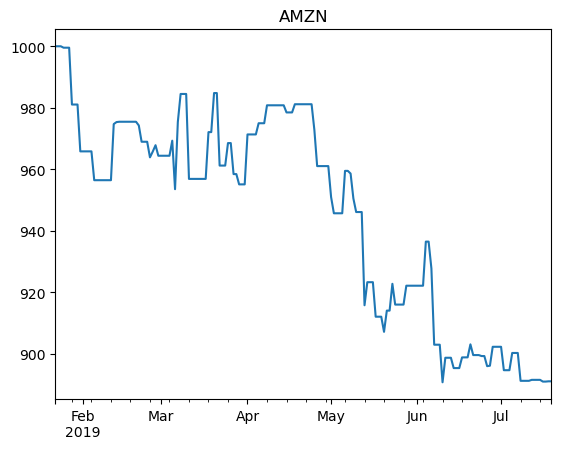

-	2023-02-27T22:50:53	DESKTOP-418ISSH	User11	0,50665	-0,10899	49	-1,76	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.03	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 37,37


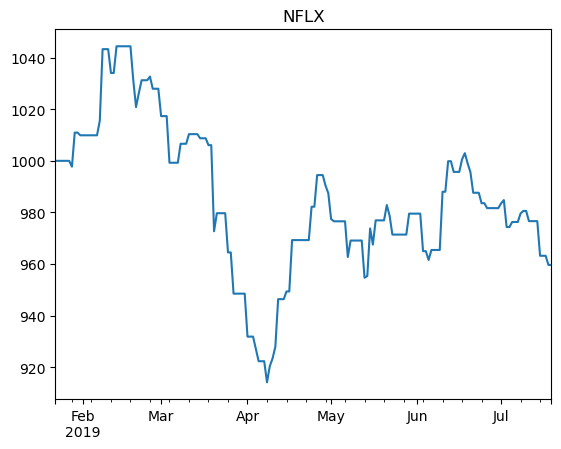

-	2023-02-27T22:50:55	DESKTOP-418ISSH	User11	0,50665	-0,04033	57	-0,5892	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.03	-	nan
Success!


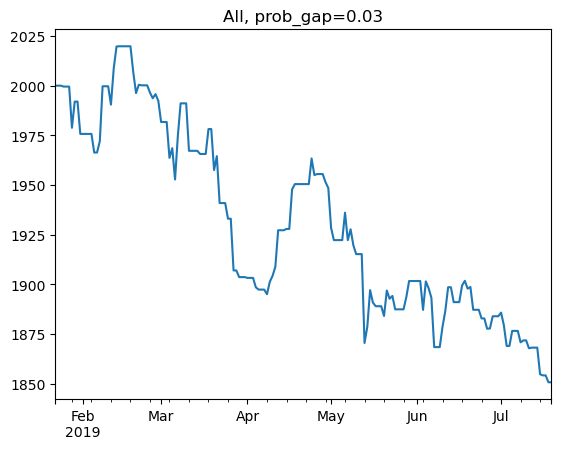

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  36,37, 34,33
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 37,37
Profit: -7.4662%
Trades: 106
Sharpe Ratio: -1.798
Score line for Google Sheet:
-	2023-02-27T22:50:56	DESKTOP-418ISSH	User11	0,50665	-0,074662	106	-1,7983	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.03	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


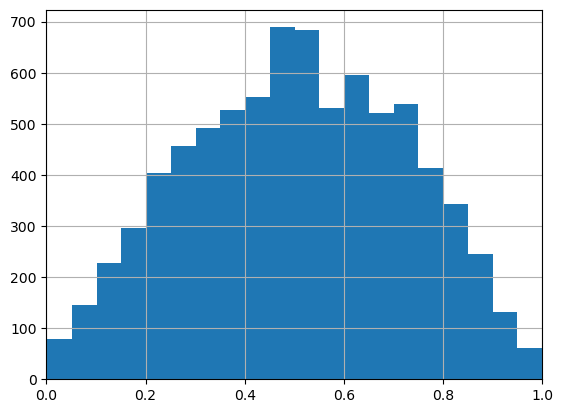

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,43, 39,38


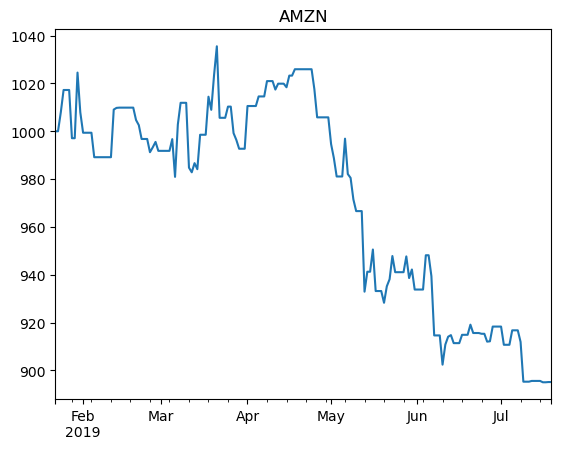

-	2023-02-27T22:50:58	DESKTOP-418ISSH	User11	0,50665	-0,10489	57	-1,4154	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.02	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 37,37


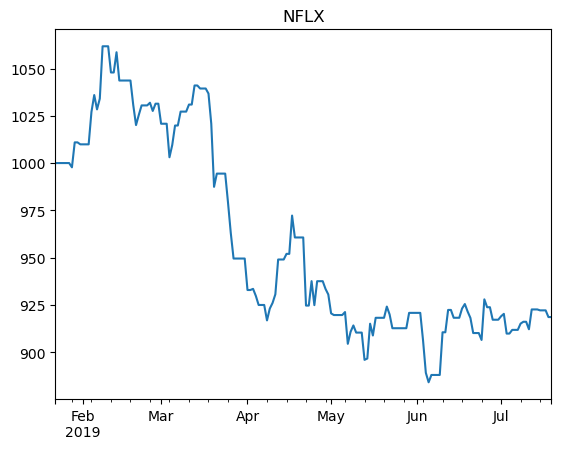

-	2023-02-27T22:51:00	DESKTOP-418ISSH	User11	0,50665	-0,081437	63	-0,99796	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.02	-	nan
Success!


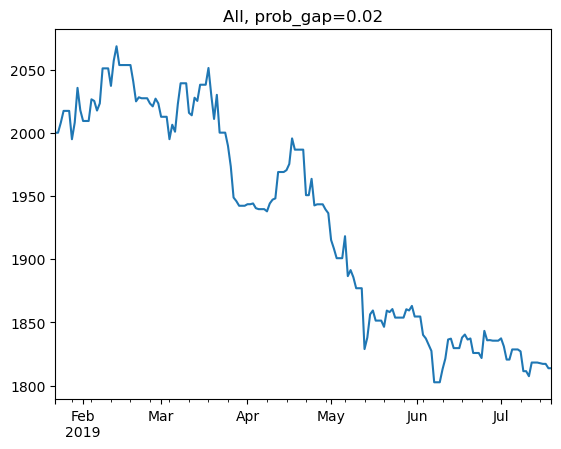

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,43, 39,38
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 37,37
Profit: -9.3164%
Trades: 120
Sharpe Ratio: -1.835
Score line for Google Sheet:
-	2023-02-27T22:51:01	DESKTOP-418ISSH	User11	0,50665	-0,093164	120	-1,8353	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.02	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


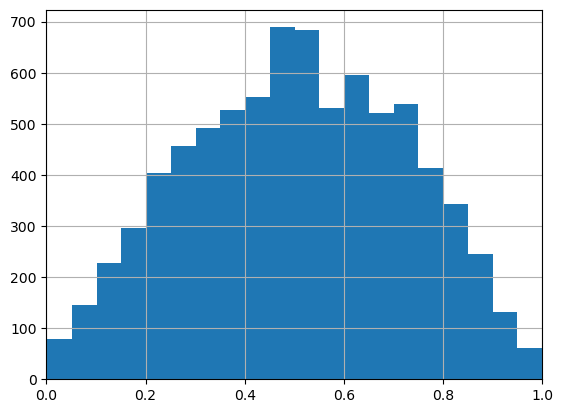

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  45,46, 41,40


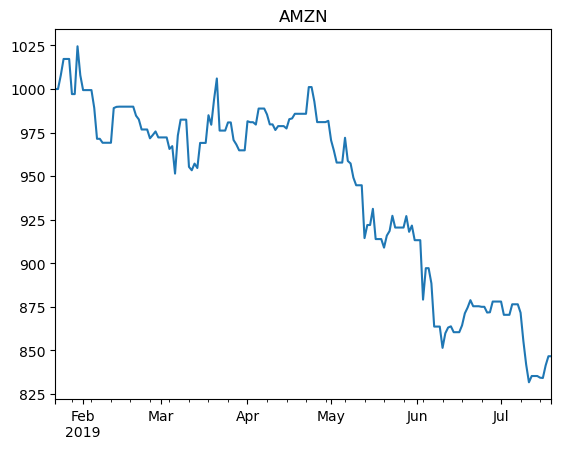

-	2023-02-27T22:51:03	DESKTOP-418ISSH	User11	0,50665	-0,15345	62	-1,9143	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.01	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 38,38


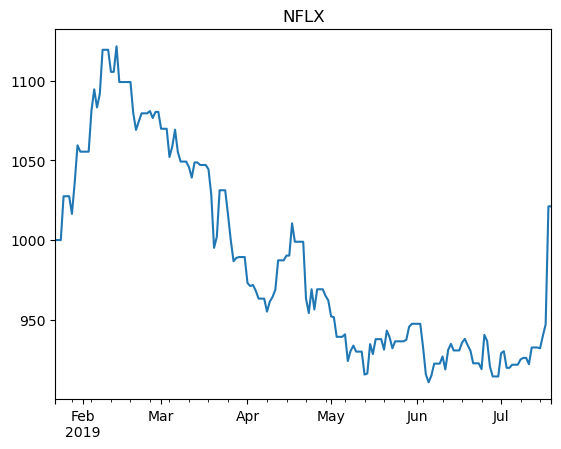

-	2023-02-27T22:51:06	DESKTOP-418ISSH	User11	0,50665	0,021163	65	0,30452	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.01	-	nan
Success!


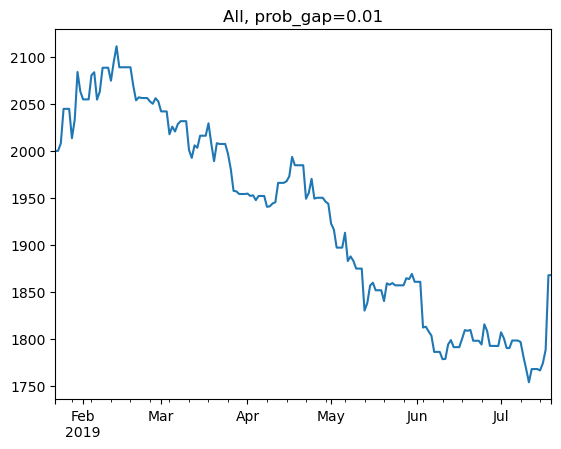

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  45,46, 41,40
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 38,38
Profit: -6.6141%
Trades: 127
Sharpe Ratio: -0.931
Score line for Google Sheet:
-	2023-02-27T22:51:06	DESKTOP-418ISSH	User11	0,50665	-0,066141	127	-0,93088	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.01	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


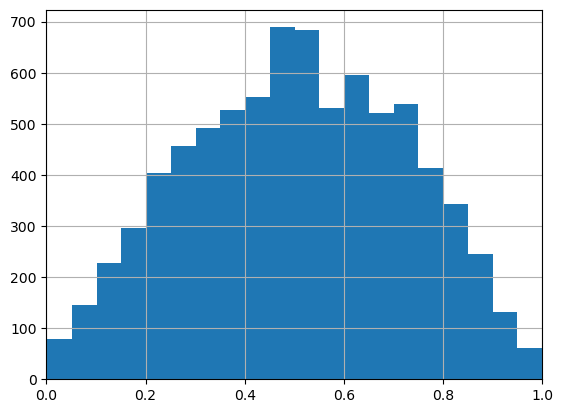

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  46,47, 43,43


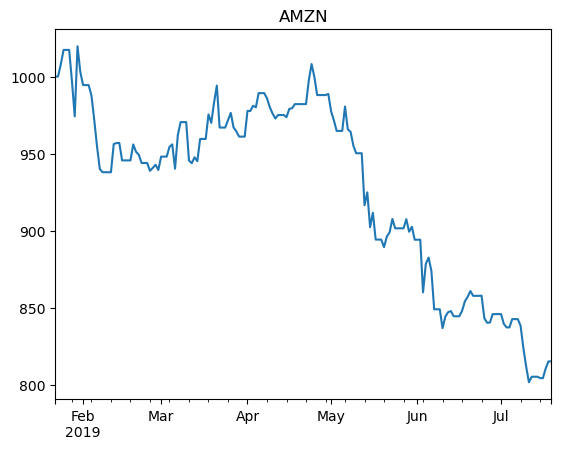

-	2023-02-27T22:51:09	DESKTOP-418ISSH	User11	0,50665	-0,18463	65	-2,0848	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.0	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 41,41


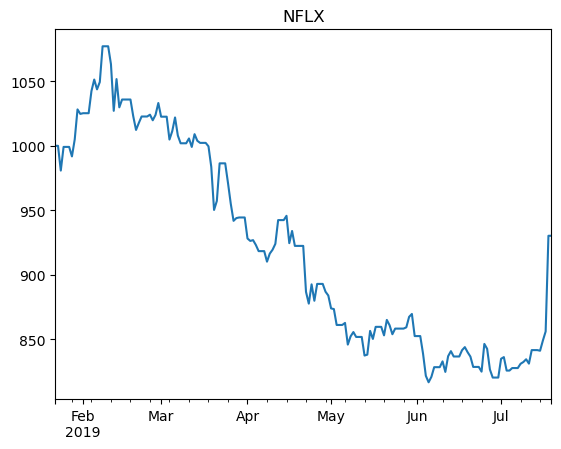

-	2023-02-27T22:51:12	DESKTOP-418ISSH	User11	0,50665	-0,069703	62	-0,51099	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.0	-	nan
Success!


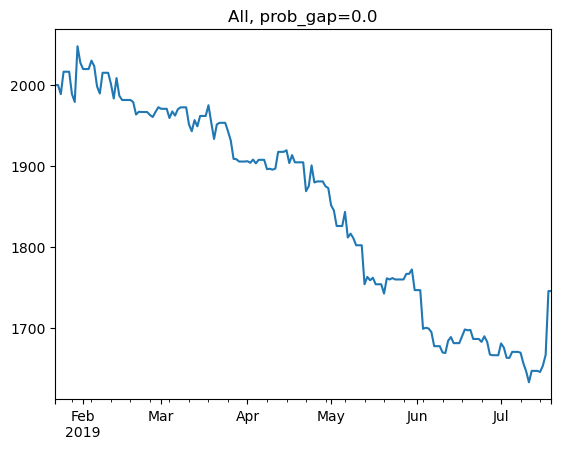

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  46,47, 43,43
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  42,42, 41,41
Profit: -12.717%
Trades: 127
Sharpe Ratio: -1.850
Score line for Google Sheet:
-	2023-02-27T22:51:13	DESKTOP-418ISSH	User11	0,50665	-0,12717	127	-1,8497	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.0	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


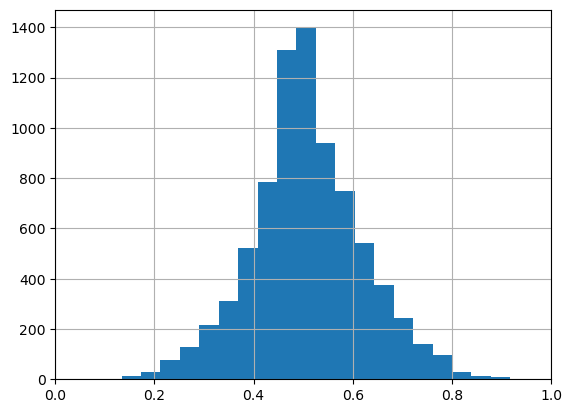

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  3,4, 0,1


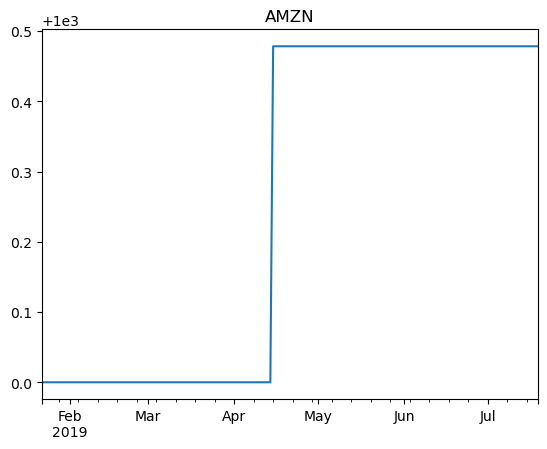

-	2023-02-27T22:51:14	DESKTOP-418ISSH	User11	0,50544	0,0004783	1	1,3891	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.1	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  5,6, 3,4


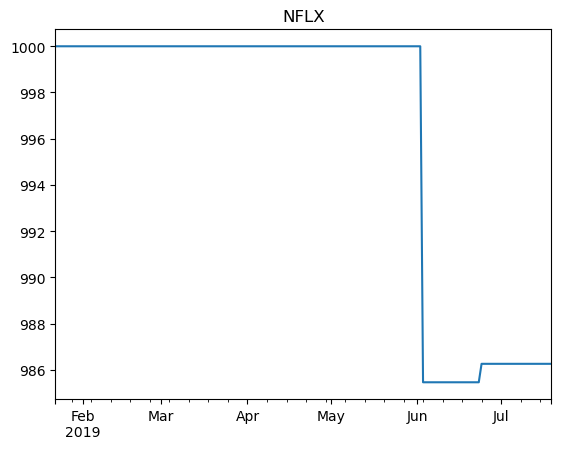

-	2023-02-27T22:51:15	DESKTOP-418ISSH	User11	0,50544	-0,013741	2	-1,3446	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.1	-	nan
Success!


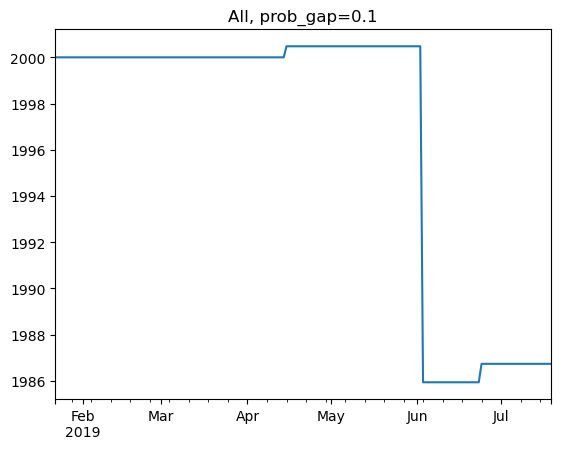

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  3,4, 0,1
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  5,6, 3,4
Profit: -0.66316%
Trades: 3
Sharpe Ratio: -1.296
Score line for Google Sheet:
-	2023-02-27T22:51:15	DESKTOP-418ISSH	User11	0,50544	-0,0066316	3	-1,2963	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.1	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


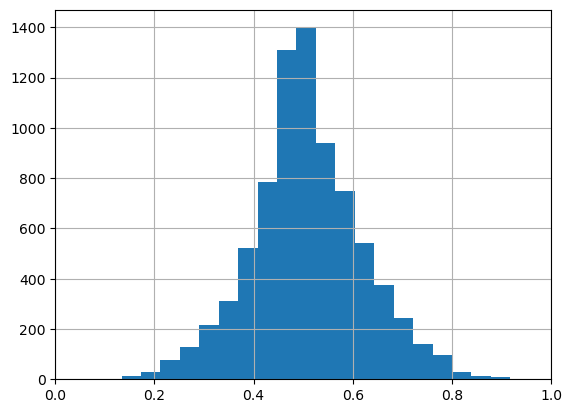

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  5,6, 0,1


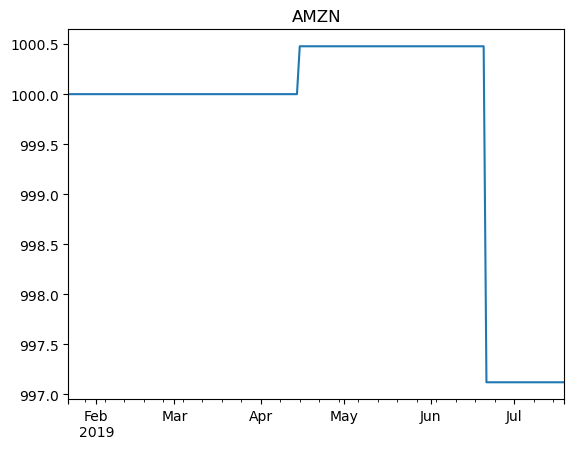

-	2023-02-27T22:51:17	DESKTOP-418ISSH	User11	0,50544	-0,0028786	2	-1,2065	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.09	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  6,7, 5,6


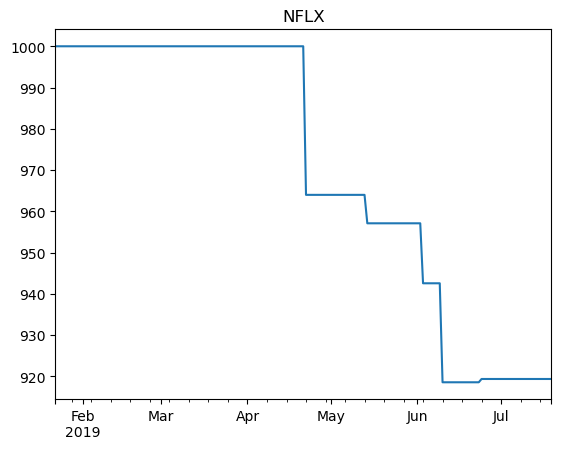

-	2023-02-27T22:51:17	DESKTOP-418ISSH	User11	0,50544	-0,080649	5	-2,5235	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.09	-	nan
Success!


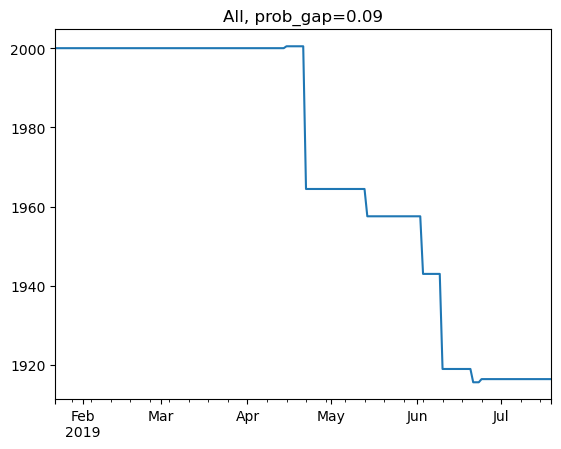

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  5,6, 0,1
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  6,7, 5,6
Profit: -4.1764%
Trades: 7
Sharpe Ratio: -2.602
Score line for Google Sheet:
-	2023-02-27T22:51:18	DESKTOP-418ISSH	User11	0,50544	-0,041764	7	-2,602	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.09	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


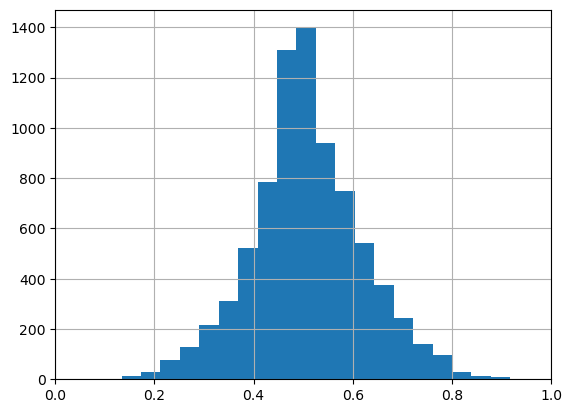

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  8,9, 0,1


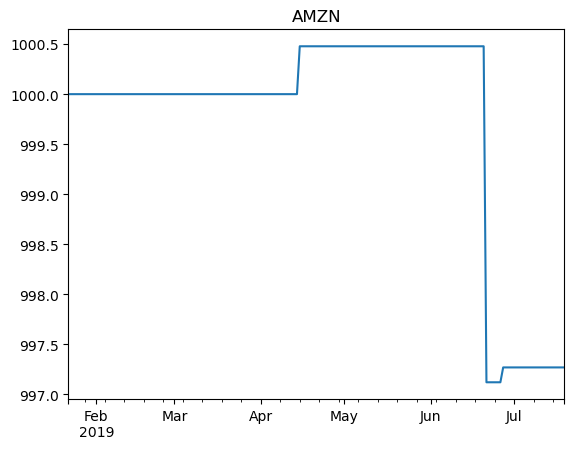

-	2023-02-27T22:51:19	DESKTOP-418ISSH	User11	0,50544	-0,0027302	3	-1,1427	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.08	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  6,7, 5,6


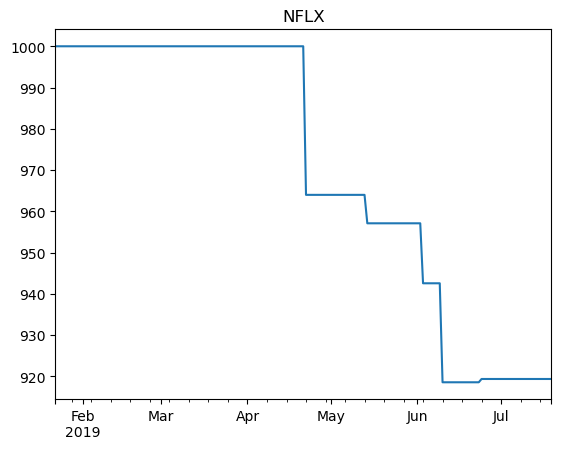

-	2023-02-27T22:51:19	DESKTOP-418ISSH	User11	0,50544	-0,080649	5	-2,5235	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.08	-	nan
Success!


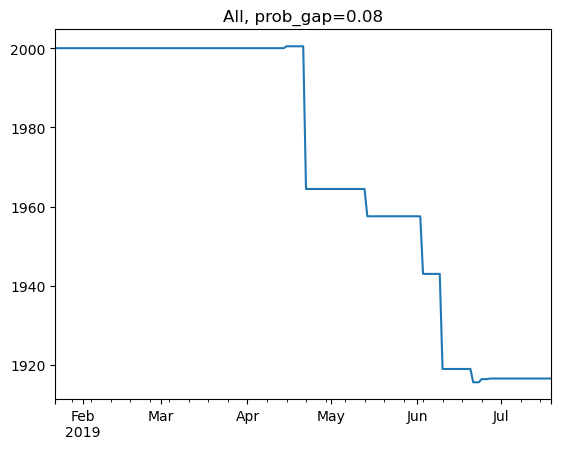

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  8,9, 0,1
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  6,7, 5,6
Profit: -4.1689%
Trades: 8
Sharpe Ratio: -2.597
Score line for Google Sheet:
-	2023-02-27T22:51:20	DESKTOP-418ISSH	User11	0,50544	-0,041689	8	-2,5971	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.08	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


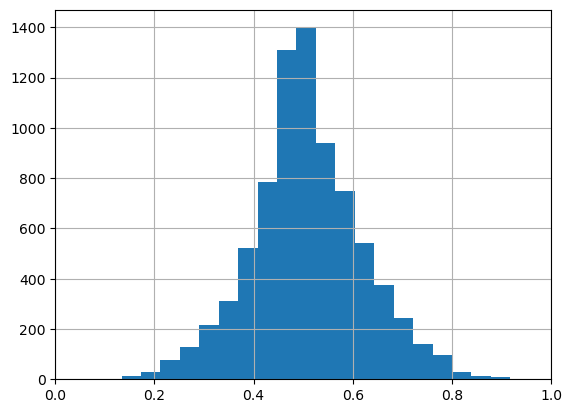

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  10,11, 0,1


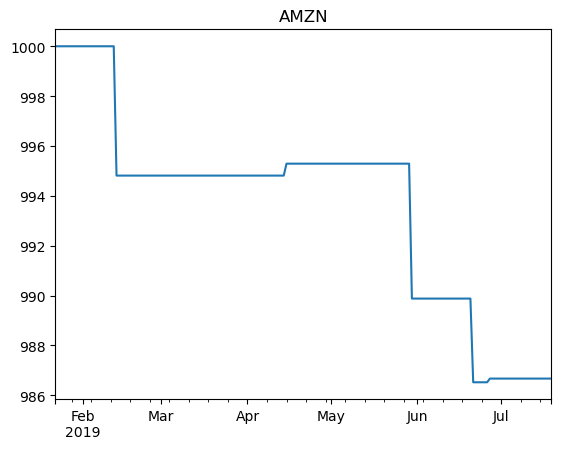

-	2023-02-27T22:51:21	DESKTOP-418ISSH	User11	0,50544	-0,013327	5	-2,3208	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.07	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  7,8, 10,11


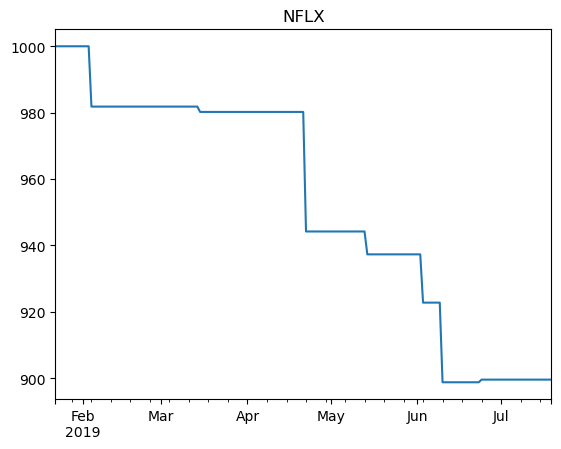

-	2023-02-27T22:51:21	DESKTOP-418ISSH	User11	0,50544	-0,10042	7	-2,9209	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.07	-	nan
Success!


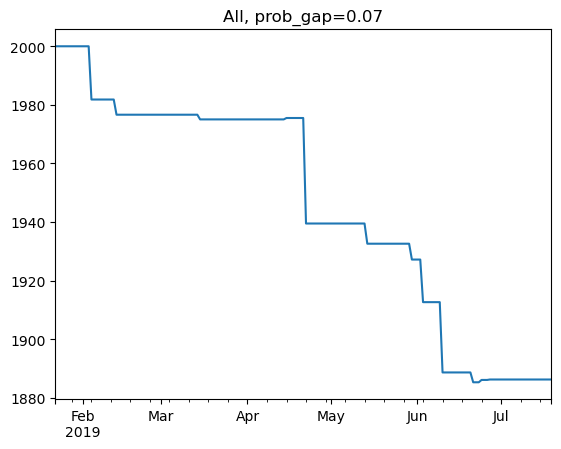

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  10,11, 0,1
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  7,8, 10,11
Profit: -5.6876%
Trades: 12
Sharpe Ratio: -3.271
Score line for Google Sheet:
-	2023-02-27T22:51:22	DESKTOP-418ISSH	User11	0,50544	-0,056876	12	-3,2711	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.07	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


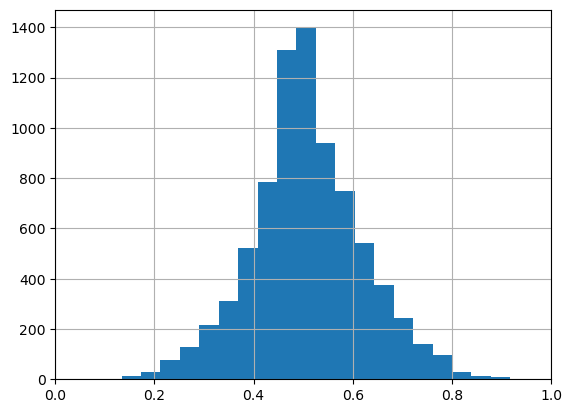

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  16,17, 2,3


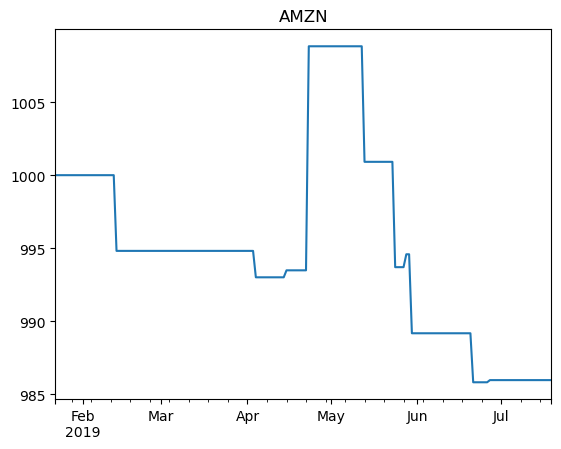

-	2023-02-27T22:51:23	DESKTOP-418ISSH	User11	0,50544	-0,014037	10	-0,96305	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.06	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  11,12, 13,14


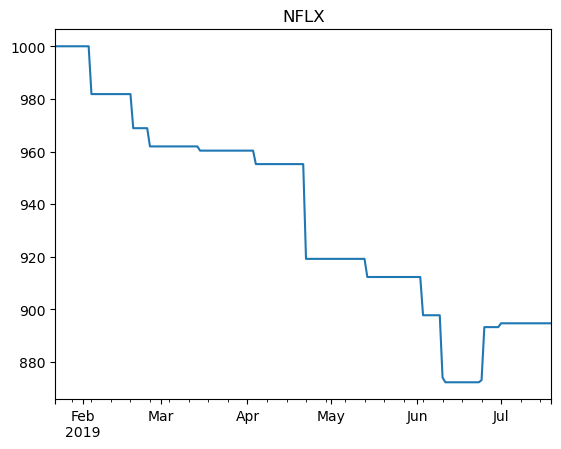

-	2023-02-27T22:51:24	DESKTOP-418ISSH	User11	0,50544	-0,10529	12	-2,6388	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.06	-	nan
Success!


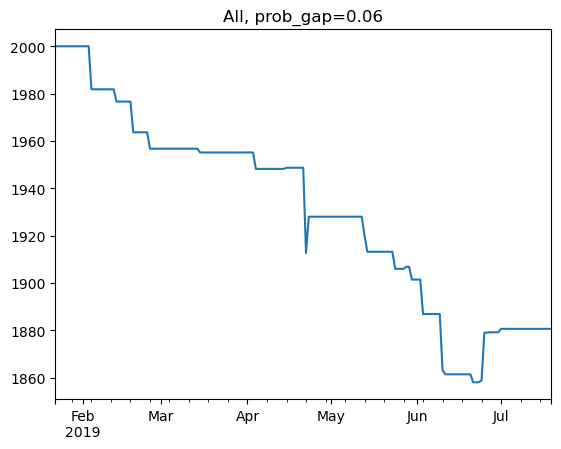

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  16,17, 2,3
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  11,12, 13,14
Profit: -5.9664%
Trades: 22
Sharpe Ratio: -2.843
Score line for Google Sheet:
-	2023-02-27T22:51:24	DESKTOP-418ISSH	User11	0,50544	-0,059664	22	-2,8431	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.06	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


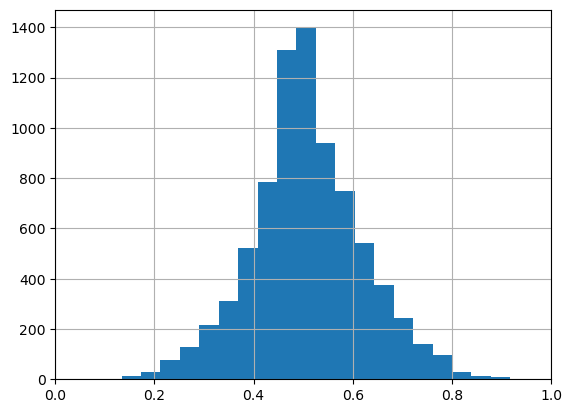

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  26,27, 3,4


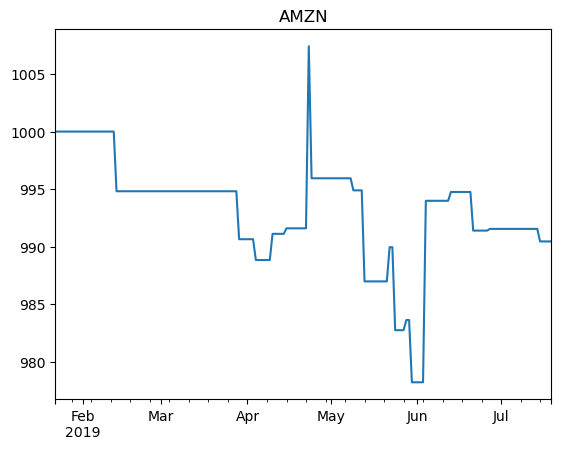

-	2023-02-27T22:51:25	DESKTOP-418ISSH	User11	0,50544	-0,0095493	17	-0,44255	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.05	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  17,18, 17,18


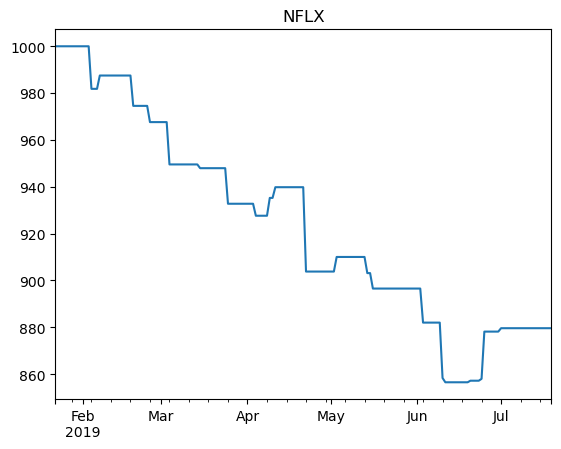

-	2023-02-27T22:51:26	DESKTOP-418ISSH	User11	0,50544	-0,12037	20	-2,7047	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.05	-	nan
Success!


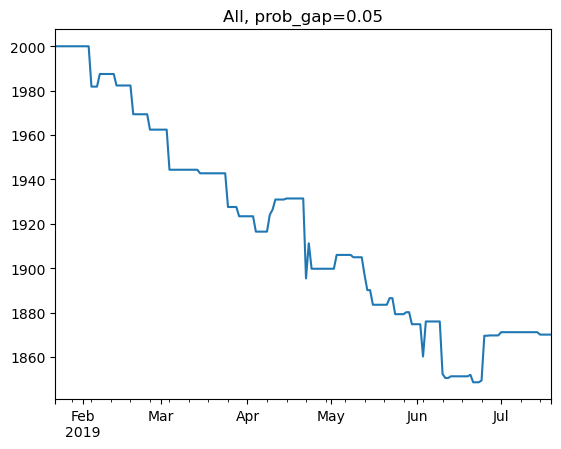

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  26,27, 3,4
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  17,18, 17,18
Profit: -6.496%
Trades: 37
Sharpe Ratio: -2.664
Score line for Google Sheet:
-	2023-02-27T22:51:27	DESKTOP-418ISSH	User11	0,50544	-0,06496	37	-2,6637	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.05	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


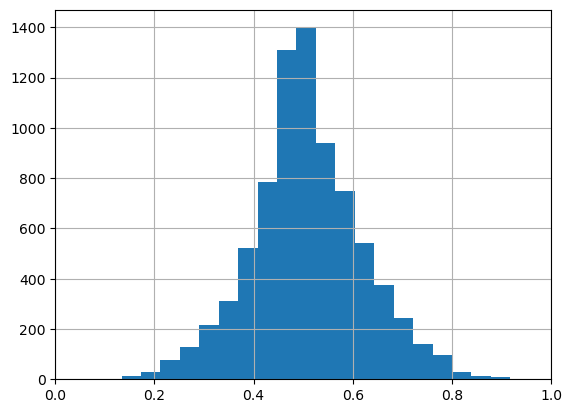

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  30,31, 4,5


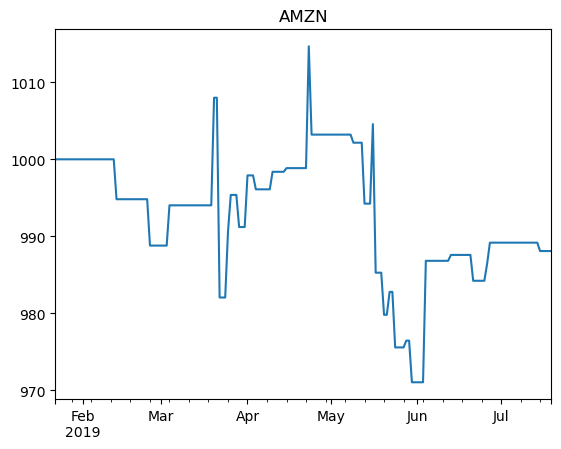

-	2023-02-27T22:51:28	DESKTOP-418ISSH	User11	0,50544	-0,011917	24	-0,30885	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.04	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  20,21, 24,25


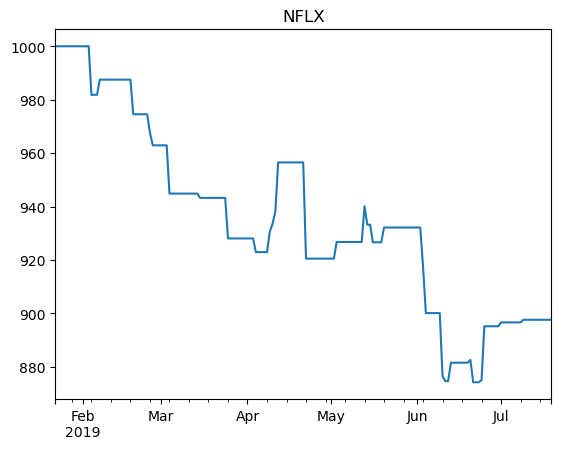

-	2023-02-27T22:51:29	DESKTOP-418ISSH	User11	0,50544	-0,10239	28	-2,0233	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.04	-	nan
Success!


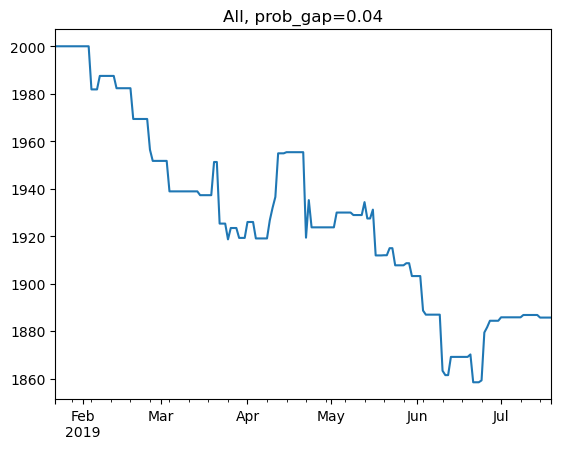

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  30,31, 4,5
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  20,21, 24,25
Profit: -5.7153%
Trades: 52
Sharpe Ratio: -2.059
Score line for Google Sheet:
-	2023-02-27T22:51:29	DESKTOP-418ISSH	User11	0,50544	-0,057153	52	-2,0592	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.04	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


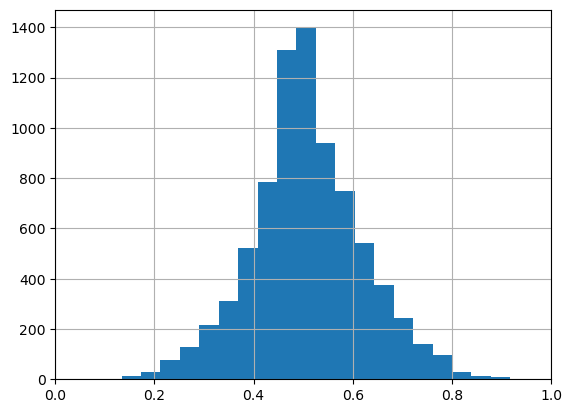

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 5,6


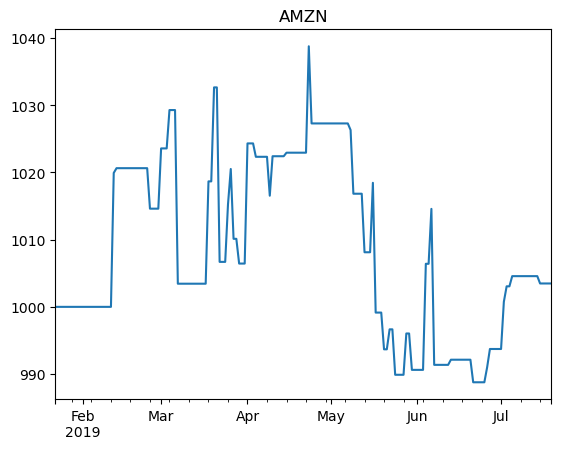

-	2023-02-27T22:51:30	DESKTOP-418ISSH	User11	0,50544	0,0034787	28	0,12067	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.03	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 33,34


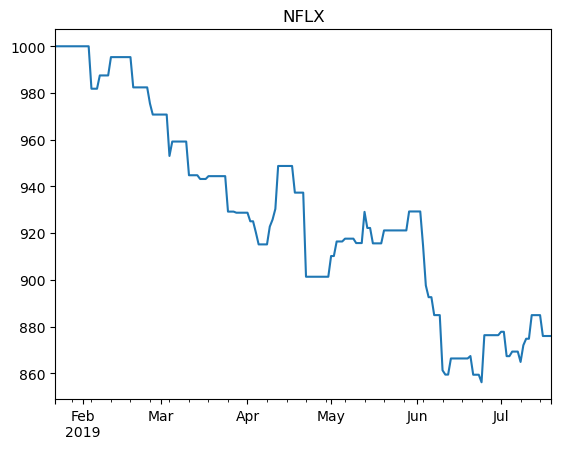

-	2023-02-27T22:51:31	DESKTOP-418ISSH	User11	0,50544	-0,12407	43	-2,2196	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.03	-	nan
Success!


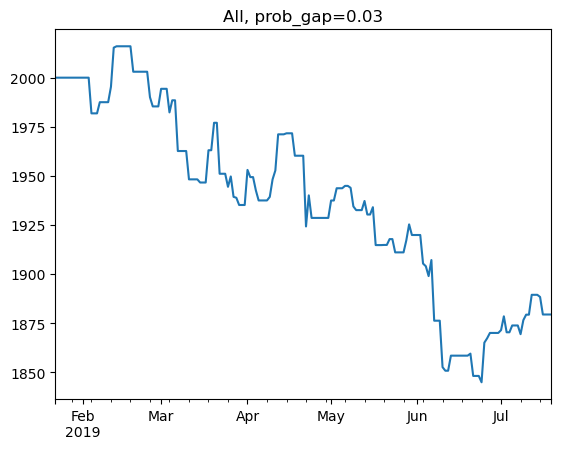

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  35,36, 5,6
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  27,28, 33,34
Profit: -6.0293%
Trades: 71
Sharpe Ratio: -1.688
Score line for Google Sheet:
-	2023-02-27T22:51:32	DESKTOP-418ISSH	User11	0,50544	-0,060293	71	-1,6881	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.03	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


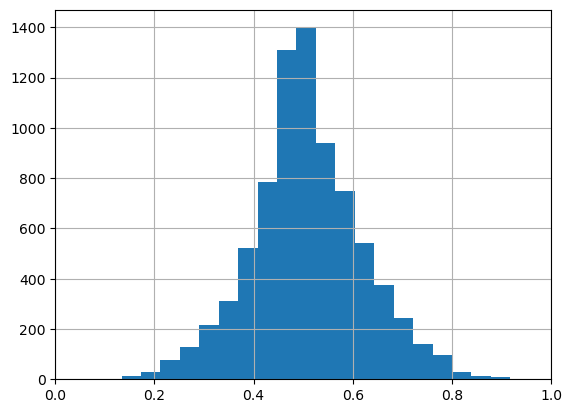

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  40,41, 9,9


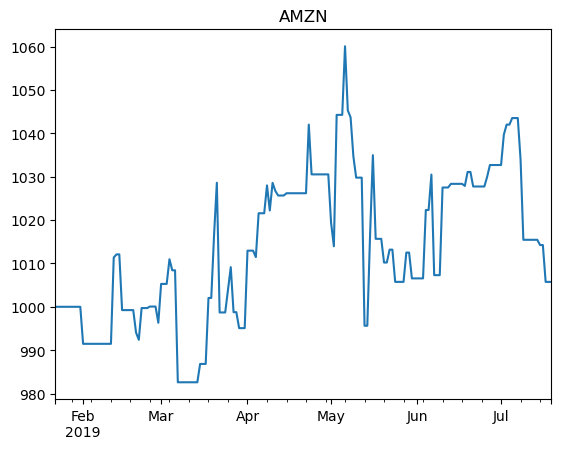

-	2023-02-27T22:51:33	DESKTOP-418ISSH	User11	0,50544	0,0057426	34	0,153	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.02	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  38,39, 40,40


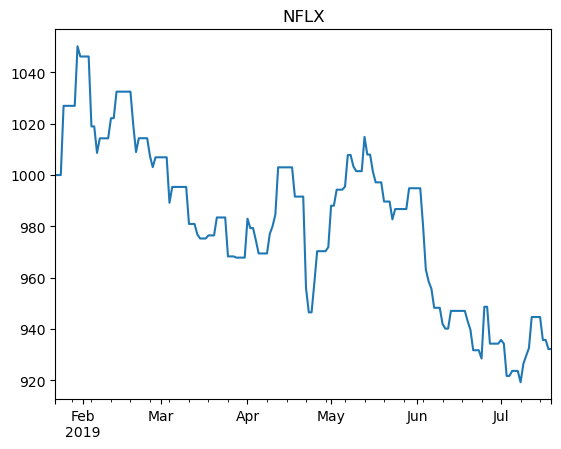

-	2023-02-27T22:51:34	DESKTOP-418ISSH	User11	0,50544	-0,067842	58	-0,97976	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.02	-	nan
Success!


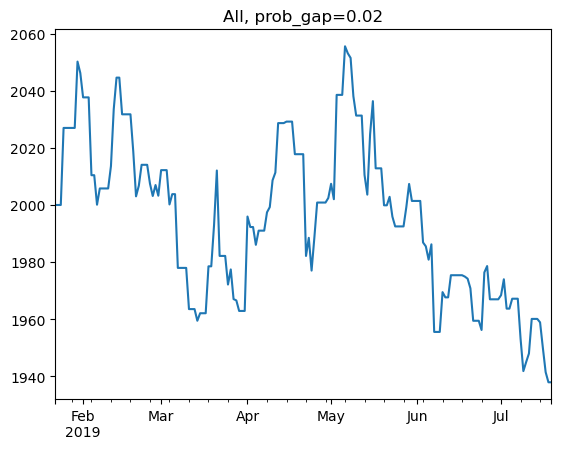

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  40,41, 9,9
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  38,39, 40,40
Profit: -3.105%
Trades: 92
Sharpe Ratio: -0.642
Score line for Google Sheet:
-	2023-02-27T22:51:35	DESKTOP-418ISSH	User11	0,50544	-0,03105	92	-0,64237	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.02	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


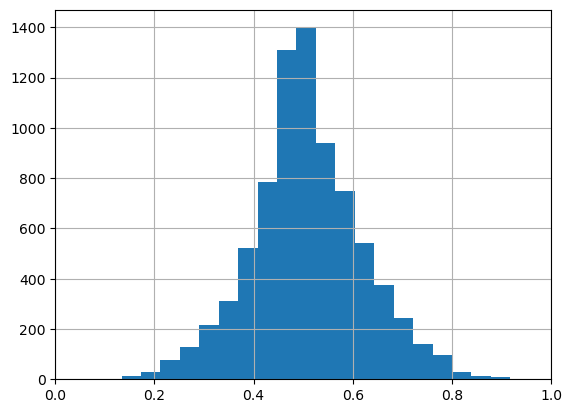

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  37,38, 19,19


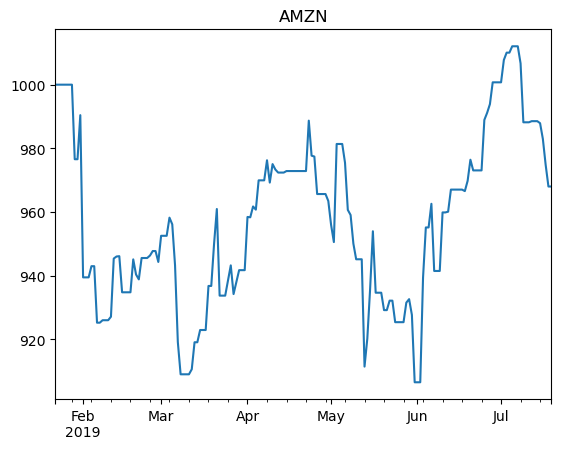

-	2023-02-27T22:51:36	DESKTOP-418ISSH	User11	0,50544	-0,031978	40	-0,26829	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.01	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  45,46, 48,48


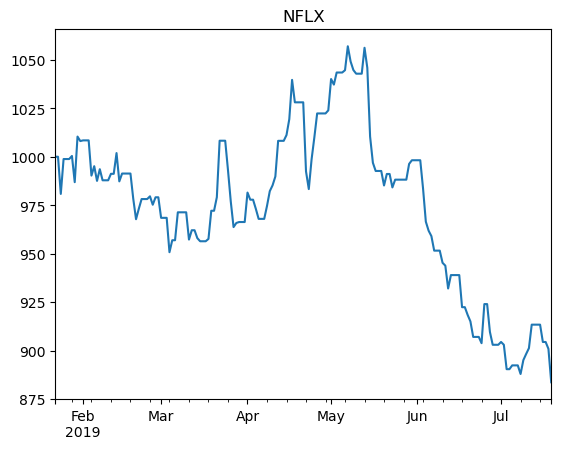

-	2023-02-27T22:51:37	DESKTOP-418ISSH	User11	0,50544	-0,11634	72	-1,401	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.01	-	nan
Success!


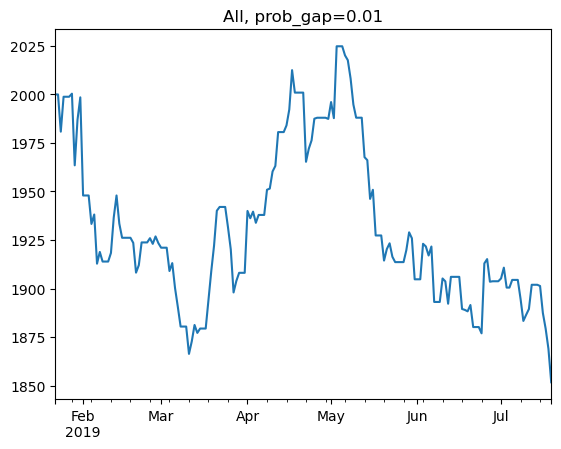

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  37,38, 19,19
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  45,46, 48,48
Profit: -7.4158%
Trades: 112
Sharpe Ratio: -1.369
Score line for Google Sheet:
-	2023-02-27T22:51:38	DESKTOP-418ISSH	User11	0,50544	-0,074158	112	-1,3695	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.01	-	nan
AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls


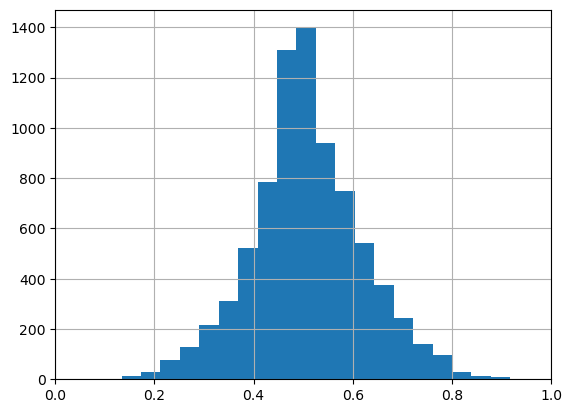

Processing ticker AMZN
.. fill_missing_date_rows: 162 -> 178 (+16)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  31,32, 26,26


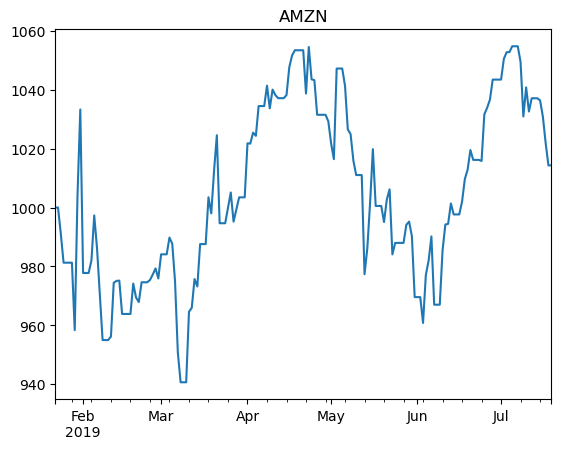

-	2023-02-27T22:51:39	DESKTOP-418ISSH	User11	0,50544	0,014331	40	0,24362	0,1972	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	AMZN	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.0	-	nan
Success!
Processing ticker NFLX
.. fill_missing_date_rows: 175 -> 178 (+3)
.. populate_buy_trend results (enter/exit longs, enter/exit shorts):  47,48, 48,47


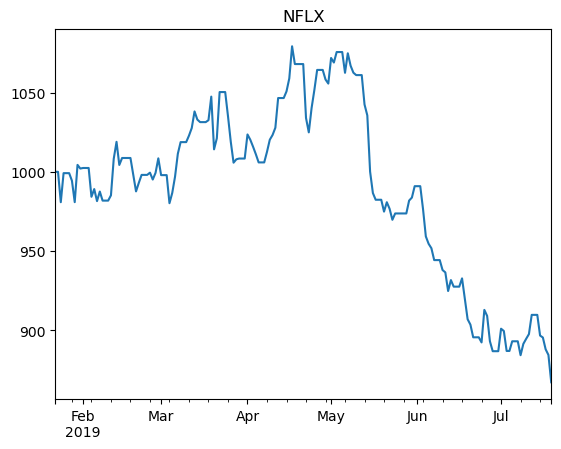

-	2023-02-27T22:51:41	DESKTOP-418ISSH	User11	0,50544	-0,13277	68	-1,4935	-0,017155	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	NFLX	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.0	-	nan
Success!


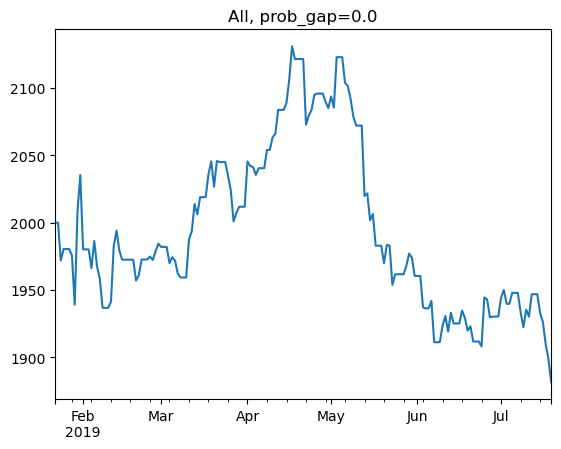

AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  31,32, 26,26
NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  47,48, 48,47
Profit: -5.922%
Trades: 108
Sharpe Ratio: -0.828
Score line for Google Sheet:
-	2023-02-27T22:51:41	DESKTOP-418ISSH	User11	0,50544	-0,05922	108	-0,82788	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	catboost for ['message']	prob_gap=0.0	-	nan
=== All results for Google Sheet ===
-	2023-02-27T22:50:23	DESKTOP-418ISSH	User11	0,50665	-0,0466	24	-3,1982	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019-07	2019-07_2018-07	06+06	d1_C=d1_O=0.5%=2cls	NaiveBayes_words_ng1-3_alhpa0.1	prob_gap=0.1	-	nan
-	2023-02-27T22:50:27	DESKTOP-418ISSH	User11	0,50665	-0,040891	28	-2,6327	0,18004	AMZN_NFLX_2018-07_2019-07_f7	AMZN_NFLX	all	(5292, 7),(3308, 7)	2018-07_2019

In [127]:
total_report_list = []
total_report_per_ticker_list = []
phase1_shapes = f"{X_train.shape},{X_test.shape}"
for probas, model_tag_full, model_acc in zip(all_models__probas, all_models__full_tags, all_models__accs):
    assert len(probas) == len(X_test_3classes_full) == len(pcr_test_3classes)
    for prob_gap in [0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.00]:
        strategy_copy = copy(strategy)
        strategy_copy.prob_gap = prob_gap    
        
        score_line_str, score_line_per_ticker_list = calc_equity_history(
            probas=probas, X_3classes_full=X_test_3classes_full, pcr_values_3classes=pcr_test_3classes, 
            strategy=strategy_copy, model_tag_full=model_tag_full, model_params_str=f"prob_gap={prob_gap}", 
            model_accuracy=model_acc,
            phase1_shapes=phase1_shapes,
            #verbose=True)
            verbose=False)
        total_report_list.append(score_line_str)
        total_report_per_ticker_list.extend(score_line_per_ticker_list)
            
print("=== All results for Google Sheet ===")
for s in total_report_list:
    print(s)

In [128]:
# Dump the results to csv files
ts = datetime.datetime.now().strftime('%Y-%m-%dT%H%M%S.%f')
recs = [s.split("\t") for s in total_report_list]
df_tmp = pd.DataFrame.from_records(recs, columns=SCORE_LINE_COLS)
df_tmp.to_csv(f"_OUT/{ts}_report_total.csv", index=False)

In [129]:
recs = [s.split("\t") for s in total_report_per_ticker_list]
df_tmp = pd.DataFrame.from_records(recs, columns=SCORE_LINE_COLS)
df_tmp.to_csv(f"_OUT/{ts}_report_per_ticker.csv", index=False)

In [130]:
print(f"Elapsed notebook seconds: {time.time() - start:.1f}")

Elapsed notebook seconds: 290.2


In [131]:

# Copy from "Estimate probas":
# AMZN+NFLX (separate models) 107+59 = 166 trades, (5,2 + 38,7) / 2 = 21,95%  
# Total_with_comm: -0.7% (59), Total_with_comm: 28.0% (107), average: (-0,7 + 28) / 2 = ~14%
# Combined model : 261 trades, 31.3% total profit -> Total_with_comm: 5.2% (261)
# 

# AMZN_NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
# AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  22,23, 2,3
# NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  12,13, 24,25
# Profit: +15.705256%

# AMZN_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
# AMZN: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  31,32, 9,10
# Profit: +8.138386%

# NFLX_2018-07_2019-07_f7, d1_C=d1_O=0.5%=2cls
# NFLX: .. populate_buy_trend results (enter/exit longs, enter/exit shorts):  24,25, 19,19
# Profit: +42.745948%
# Average profit: ~25%



In [132]:
#dataframe.enter_long.plot()

In [133]:
#dataframe.enter_short.plot()

In [134]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Calc price changes for test set

In [ ]:
import yfinance

In [ ]:
X_test_3classes

In [ ]:
min_date = X_test_3classes[COL__DateStr].min()
#max_date = X_test_3classes[COL__DateStr].max()
max_date = '2019-08-01'


yahoo_data = yfinance.download('NFLX', start=min_date, end=max_date, keepna=True, auto_adjust=True)
yahoo_data.reset_index(level=0, inplace=True)

In [ ]:
df_filled = fill_missing_dates(yahoo_data)

In [ ]:
df_filled.Close.plot()
plt.grid()

# Part 5: Model blending

In [ ]:
assert False, "Model blending should be launched manually"

## Make test set for specific seed

In [ ]:
BLEND_SEED = 42
print("Legend: seed; X_test_shape; hash,sum; y_test shape,hash,sum")

_, X_test, _, y_test = train_test_split(
    df_final[COLS__FEATURES + [COL__PCR]], df_final[COL__LABEL],
    # stratify=df[COL__LABEL], # Note: stratification leads to the same test set (though shuffled)
    shuffle=True,
    random_state = BLEND_SEED, 
    test_size = TEST_SIZE
)
# Note: equal hash means binary equality, equal sum means the same rows but shuffled
print(f"After split: {BLEND_SEED} {X_test.shape}; "
      + f" {y_test.shape},{calc_hash_for_seq(y_test)},{sum(y_test)}")

## Load the models (NB, CB, TR)

In [ ]:
# Load NB model
! cp $PATH_MAIN_DIR/../models/naive_bayes_model__seed42_*.pkl /content/ 

In [ ]:
model_nb = pickle.load(open('naive_bayes_model__seed42_NB.pkl', 'rb'))
model_tfidf = pickle.load(open('naive_bayes_model__seed42_TFIDF.pkl', 'rb'))

In [ ]:
features = model_tfidf.transform(X_test.message)
score_nb = model_nb.score(features, y_test)
assert np.isclose(score_nb, 0.572, atol=0.001)

In [ ]:
# Get probabilities
probs_nb = model_nb.predict_proba(features)[:, 1]
probs_nb

In [ ]:
# Load CB model
! cp $PATH_MAIN_DIR/../models/catboost_model_0559.cbm /content/ 

In [ ]:
from catboost import CatBoostClassifier
model_cb = CatBoostClassifier()
model_cb.load_model("catboost_model_0559.cbm")

In [ ]:
score_cb = model_cb.score(X_test.loc[:,['message']], y_test)
assert np.isclose(score_cb, 0.559, atol=0.001)

In [ ]:
# Get probabilities
probs_cb = model_cb.predict_proba(X_test.loc[:,['message']])[:, 1]
probs_cb

In [ ]:
# Load transformer
! cp $PATH_MAIN_DIR/../models/roberta_model_0548.zip /content/ 

In [ ]:
! unzip roberta_model_0548.zip

In [ ]:
!pip install wandb --quiet
!pip install simpletransformers --quiet
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
is_cuda = True if torch.cuda.is_available() else False

model_args = ClassificationArgs()
model_args.num_train_epochs = 2
model_args.regression = False
model_args.use_multiprocessing=is_cuda
model_args.use_multiprocessing_for_evaluation=is_cuda
model_args.overwrite_output_dir=True
model_args.train_batch_size = 128

model_tr = ClassificationModel(
                            "roberta",
                            "content/roberta_model/checkpoint-2265-epoch-3/", #"distilroberta-base",
                            num_labels=2,
                            use_cuda=is_cuda,
                            args=model_args
                            )


In [ ]:
# Get predictions
y_pred_tr, y_probs_tr = model_tr.predict(list(X_test['message']))


In [ ]:
score_tr = accuracy_score(y_pred_tr, y_test)
assert np.isclose(score_tr, 0.548, atol=0.001)

In [ ]:
from scipy.special import softmax

In [ ]:
probs_tr = softmax(y_probs_tr, axis=1)[:, 1]
probs_tr

## Do blending for NB+CB, NB+TR, NB+CB+TR

In [ ]:
for p in np.arange(0, 1+1e-6, 0.1):
    q = 1.0 - p
    probs = (p * probs_nb + q * probs_cb) >= 0.5
    y_pred = probs * 1  # Bools to ints
    score = accuracy_score(y_test, y_pred)
    print(f"{p:.2f}, {score:.4f}") 

In [ ]:
for p in np.arange(0, 1+1e-6, 0.1):
    q = 1.0 - p
    probs = (p * probs_nb + q * probs_tr) >= 0.5
    y_pred = probs * 1  # Bools to ints
    score = accuracy_score(y_test, y_pred)
    print(f"{p:.2f}, {score:.4f}") 

In [ ]:
# 0 0 100
# 0 50 50
# 0 100 0
# 50 0 50
# 50 50 0
# 100 0 0

max_score = 0
max_pqz = ()
for p in range(0, 101, 10):
    for q in range(0, 101, 10):
      z = 100-p-q
      if p < 0 or q <0 or z < 0:
          continue
      #print(p, q, z, 100-p-q-z)

      pp = p / 100.0
      qq = q / 100.0
      zz = z / 100.0
      probs = (pp * probs_nb + qq * probs_cb + zz * probs_tr) >= 0.5
      y_pred = probs * 1  # Bools to ints
      score = accuracy_score(y_test, y_pred)
      if max_score < score:
          max_score = score
          max_pqz = (pp, qq, zz)
      print(f"{pp:.2f}, {qq:.2f}, {zz:.2f}: {score:.4f}, {max_score:.5f}") 

      # q = 1.0 - p
      # probs = (p * probs_nb + q * probs_cb) >= 0.5
      # y_pred = probs * 1  # Bools to ints
      # score = accuracy_score(y_test, y_pred)
      # print(p, score)

print(f"Best: {max_score:.5f}, {max_pqz}") 